# Stochastic volatility 1998

In [3]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

rand_seed = 22101
np.random.seed(rand_seed)

yuima = importr("yuima")
n_stvol_sim_string = """
n_stvol = function(random_seed, num_sim,
                    mu11, mu21, mu22, mu31, mu41, mu42, 
                    sigma11, sigma12, sigma13, sigma14,
                    sigma21, sigma22, sigma23, sigma24,
                    sigma31, sigma32, sigma33, sigma34,
                    sigma41, sigma42, sigma43, sigma44,
                    xinit_vec, vinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11-(1/2)*(v1)^2", "mu21-mu22*v1", "mu31-(1/2)*(v2)^2", "mu41-mu42*v2")
  diffusion = matrix(c("sigma11*v1", "sigma12*v1", "sigma13*v1", "sigma14*v1", 
                       "sigma21", "sigma22", "sigma23", "sigma24", 
                       "sigma31*v2", "sigma32*v2", "sigma33*v2", "sigma34*v2", 
                       "sigma41", "sigma42", "sigma43", "sigma44"), 
                     4, 4, byrow=TRUE)
  
  stvol_model = setModel(drift=drift, diffusion=diffusion,
                          time.variable = "t",
                          state.variable=c("X1", "v1", "X2", "v2"),
                          solve.variable=c("X1", "v1", "X2", "v2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    stvol_sim = simulate(stvol_model, 
                          true.par=list(
                            mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                            sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                            sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                            sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                            sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44), 
                          xinit=c(xinit_vec[[i]][1], vinit_vec[[i]][1], xinit_vec[[i]][2], vinit_vec[[i]][2]), 
                          sampling=newsamp)
    original_data = stvol_sim@data@original.data
    one_sim_stvol = data.frame(original_data[,1], original_data[,3])
    colnames(one_sim_stvol) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_stvol
  }
  return(n_sim_data)
}
"""

n_stvol_sim = SignatureTranslatedAnonymousPackage(n_stvol_sim_string, "n_stvol_sim")
def n_stvol_simulation(random_seed, num_sim,
                        mu11, mu21, mu22, mu31, mu41, mu42, 
                        sigma11, sigma12, sigma13, sigma14,
                        sigma21, sigma22, sigma23, sigma24,
                        sigma31, sigma32, sigma33, sigma34,
                        sigma41, sigma42, sigma43, sigma44,
                        xinit_vec, vinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_stvol_sim.n_stvol(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                              sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                              sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                              sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                              sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44,
                              xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef
    
def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
    autocorr1 = return_series1.apply(lambda x: x.autocorr(lag=1))    
    
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    autocorr2 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # adf test on original prices: test if the price difference of the two time series is stationary
    p_values = []
    for i in range(248):
        reg = LinearRegression().fit(np.array(price_series1.iloc[:, i]).reshape((-1, 1)), np.array(price_series2.iloc[:, i]))
        y_pred = reg.predict(np.array(price_series1.iloc[:, i]).reshape((-1, 1)))
        res = np.array(price_series2.iloc[:, i]) - y_pred
        adf_result = adfuller(res)[1]
        p_values.append(adf_result)
    p_values = pd.Series(p_values)
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1, autocorr2, corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               p_values])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation1', 'return_autocorrelation2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price_adf_p_values']
    return stats_data



def loss_function(params):
    
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    print(int(np.random.randint(low=0, high=980608, size=(1,))))
    print(int(np.random.randint(low=0, high=980608, size=(1,))))
    n_sim_log_price = n_stvol_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu21=params[1], mu22=params[2], mu31=params[3], mu41=params[4], mu42=params[5],  
        sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
        sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
        sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
        sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
        xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_log_price=n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_return=n_sim_return, n_price=n_sim_price)


    for i in range(n_real_stats.shape[0]):
        for j in range(n_real_stats.shape[1]):
            moment_loss.iloc[i, j] = np.sqrt((n_real_stats.iloc[i, j] - n_sim_stats.iloc[i, j])**2)
    sum_all = np.sum(moment_loss)
    print(sum_all)
    print(np.sum(sum_all))
    print('----------')

    return np.sum(sum_all)



real_price = pd.read_csv("sp500_20180101_20181231_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("sp500_20180101_20181231_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)


num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats




initial0 = [0.1, 1, 1, 0.1, 1, 1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1] 0.1 1.0 1.0 0.1 1.0 1.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
[20] 0.1 0.1 0.1

450452
97804
return_mean1                      20.426841
return_mean2                      19.488771
return_sd1                       298.215684
return_sd2                       312.023818
return_skew1                     161.028648
return_skew2                     161.028648
return_kurtosis1                 862.968163
return_kurtosis2                1390.623156
return_autocorrelation1           19.089863
return_autocorrelation2           21.047505
return_correlation_ts1_lag_0     157.643059
return_correlation_ts1_lag_1      19.579955
return_correlation_ts1_lag_2      19.907890
return_correlation_ts1_lag_3      22.509876
return_correlation_ts2_lag_1      20.755811
return_correlation_ts2_lag_2      20.916793
return_correlation_ts2_lag_3      22.260433
price_adf_p_values               100.786508
dtype: float64
3650.3014214377617
----------
 [1] 0.1 1.0 1.0 0.1 1.0 1.0 0.1 0.1 0.1 0.1 0.1 0.

return_mean1                      68.899755
return_mean2                      20.085419
return_sd1                       296.710914
return_sd2                       310.510656
return_skew1                     147.752927
return_skew2                     147.752927
return_kurtosis1                 837.186336
return_kurtosis2                1420.073470
return_autocorrelation1           21.036969
return_autocorrelation2           21.847835
return_correlation_ts1_lag_0     157.644440
return_correlation_ts1_lag_1      20.397024
return_correlation_ts1_lag_2      20.028266
return_correlation_ts1_lag_3      22.500538
return_correlation_ts2_lag_1      21.407643
return_correlation_ts2_lag_2      22.108316
return_correlation_ts2_lag_3      22.439867
price_adf_p_values                77.352705
dtype: float64
3655.736007187373
----------
 [1] -0.4292149  1.0000000  1.0000000  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                      45.535430
return_mean2                      20.885215
return_sd1                       295.540628
return_sd2                       309.345670
return_skew1                     157.747881
return_skew2                     157.747881
return_kurtosis1                 846.002986
return_kurtosis2                1374.071000
return_autocorrelation1           21.438314
return_autocorrelation2           19.661974
return_correlation_ts1_lag_0     157.645141
return_correlation_ts1_lag_1      19.971639
return_correlation_ts1_lag_2      19.878525
return_correlation_ts1_lag_3      22.389961
return_correlation_ts2_lag_1      22.297359
return_correlation_ts2_lag_2      19.747715
return_correlation_ts2_lag_3      20.839130
price_adf_p_values                85.158302
dtype: float64
3615.9047493691837
----------
 [1] -0.4277319  1.0000000  1.0000000  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                      46.249136
return_mean2                      20.273001
return_sd1                       299.410901
return_sd2                       313.220540
return_skew1                     155.231706
return_skew2                     155.231706
return_kurtosis1                 851.059547
return_kurtosis2                1396.523414
return_autocorrelation1           20.444950
return_autocorrelation2           21.412158
return_correlation_ts1_lag_0     157.644626
return_correlation_ts1_lag_1      20.129216
return_correlation_ts1_lag_2      22.434264
return_correlation_ts1_lag_3      19.894574
return_correlation_ts2_lag_1      20.936351
return_correlation_ts2_lag_2      20.258856
return_correlation_ts2_lag_3      20.894414
price_adf_p_values                80.708405
dtype: float64
3641.9577678121896
----------
 [1] -0.4292149  2.0000000  1.0000000  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     118.909789
return_mean2                      19.768401
return_sd1                        91.855619
return_sd2                       309.929569
return_skew1                     146.638353
return_skew2                     146.638353
return_kurtosis1                 818.671629
return_kurtosis2                1393.567594
return_autocorrelation1           20.944399
return_autocorrelation2           21.698455
return_correlation_ts1_lag_0     155.072170
return_correlation_ts1_lag_1      20.479740
return_correlation_ts1_lag_2      20.400782
return_correlation_ts1_lag_3      20.753353
return_correlation_ts2_lag_1      21.619671
return_correlation_ts2_lag_2      20.641027
return_correlation_ts2_lag_3      21.338916
price_adf_p_values                75.897407
dtype: float64
3444.8252276434882
----------
 [1] -0.4292149  3.2343872  1.0000000  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     125.069472
return_mean2                      19.973442
return_sd1                        91.768292
return_sd2                       311.976120
return_skew1                     155.211796
return_skew2                     155.211796
return_kurtosis1                 822.048871
return_kurtosis2                1364.195725
return_autocorrelation1           21.239412
return_autocorrelation2           20.088029
return_correlation_ts1_lag_0     154.797165
return_correlation_ts1_lag_1      19.347769
return_correlation_ts1_lag_2      19.369807
return_correlation_ts1_lag_3      20.777708
return_correlation_ts2_lag_1      21.939197
return_correlation_ts2_lag_2      20.361944
return_correlation_ts2_lag_3      19.882177
price_adf_p_values                80.606201
dtype: float64
3443.8649223593557
----------
 [1] -0.4292149  3.2251759  1.0000000  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     168.745943
return_mean2                      19.913061
return_sd1                       131.330548
return_sd2                       309.729066
return_skew1                     158.919856
return_skew2                     158.919856
return_kurtosis1                 808.388710
return_kurtosis2                1393.970774
return_autocorrelation1           24.008911
return_autocorrelation2           20.681178
return_correlation_ts1_lag_0     152.321284
return_correlation_ts1_lag_1      20.211589
return_correlation_ts1_lag_2      19.410856
return_correlation_ts1_lag_3      20.531392
return_correlation_ts2_lag_1      21.607638
return_correlation_ts2_lag_2      20.753775
return_correlation_ts2_lag_3      20.414505
price_adf_p_values                81.718906
dtype: float64
3551.577848717249
----------
 [1] -0.4292149  3.2243439  1.3819660  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     113.694875
return_mean2                      19.823527
return_sd1                        84.467037
return_sd2                       309.766198
return_skew1                     147.766639
return_skew2                     147.766639
return_kurtosis1                 830.748866
return_kurtosis2                1366.173351
return_autocorrelation1           20.635374
return_autocorrelation2           20.608234
return_correlation_ts1_lag_0     155.313213
return_correlation_ts1_lag_1      18.605867
return_correlation_ts1_lag_2      20.670589
return_correlation_ts1_lag_3      21.862514
return_correlation_ts2_lag_1      20.715066
return_correlation_ts2_lag_2      21.790797
return_correlation_ts2_lag_3      20.746829
price_adf_p_values                71.628639
dtype: float64
3412.784252928201
----------
 [1] -0.4292149  3.2243439  1.1818726  0.1000000  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     114.653161
return_mean2                      86.685368
return_sd1                        91.516612
return_sd2                       310.252411
return_skew1                     149.307473
return_skew2                     149.307473
return_kurtosis1                 834.144574
return_kurtosis2                1396.873823
return_autocorrelation1           20.332533
return_autocorrelation2           20.699665
return_correlation_ts1_lag_0     155.098968
return_correlation_ts1_lag_1      18.382742
return_correlation_ts1_lag_2      20.371632
return_correlation_ts1_lag_3      19.300777
return_correlation_ts2_lag_1      21.303244
return_correlation_ts2_lag_2      19.827161
return_correlation_ts2_lag_3      19.746520
price_adf_p_values                51.774833
dtype: float64
3499.578968158027
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.3682734  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     114.877480
return_mean2                      49.838403
return_sd1                        86.948656
return_sd2                       307.501295
return_skew1                     153.473962
return_skew2                     153.473962
return_kurtosis1                 830.135773
return_kurtosis2                1381.484270
return_autocorrelation1           21.706801
return_autocorrelation2           18.301616
return_correlation_ts1_lag_0     155.384999
return_correlation_ts1_lag_1      19.037925
return_correlation_ts1_lag_2      19.489303
return_correlation_ts1_lag_3      20.418238
return_correlation_ts2_lag_1      20.356226
return_correlation_ts2_lag_2      20.109929
return_correlation_ts2_lag_3      20.889702
price_adf_p_values                44.175353
dtype: float64
3437.603892754666
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5177383  1.0000000  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     115.408824
return_mean2                     116.646061
return_sd1                        85.390237
return_sd2                        96.656349
return_skew1                     149.251209
return_skew2                     149.251209
return_kurtosis1                 837.745907
return_kurtosis2                1394.457538
return_autocorrelation1           19.731076
return_autocorrelation2           19.195095
return_correlation_ts1_lag_0     157.622823
return_correlation_ts1_lag_1      18.461410
return_correlation_ts1_lag_2      19.490286
return_correlation_ts1_lag_3      21.519843
return_correlation_ts2_lag_1      19.790549
return_correlation_ts2_lag_2      21.468442
return_correlation_ts2_lag_3      21.554632
price_adf_p_values                53.284641
dtype: float64
3316.9261306636076
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.6711826  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     114.684842
return_mean2                      95.324165
return_sd1                        93.873997
return_sd2                       128.030210
return_skew1                     146.116573
return_skew2                     146.116573
return_kurtosis1                 854.092837
return_kurtosis2                1408.809084
return_autocorrelation1           19.654389
return_autocorrelation2           19.813023
return_correlation_ts1_lag_0     157.568987
return_correlation_ts1_lag_1      18.901358
return_correlation_ts1_lag_2      20.572726
return_correlation_ts1_lag_3      20.227260
return_correlation_ts2_lag_1      18.989321
return_correlation_ts2_lag_2      20.396051
return_correlation_ts2_lag_3      19.847748
price_adf_p_values                39.344247
dtype: float64
3342.3633909269724
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     114.135640
return_mean2                      94.448002
return_sd1                        92.697902
return_sd2                       126.599655
return_skew1                     149.752371
return_skew2                     149.752371
return_kurtosis1                 843.771554
return_kurtosis2                1409.422219
return_autocorrelation1           19.282794
return_autocorrelation2           21.030439
return_correlation_ts1_lag_0     157.563077
return_correlation_ts1_lag_1      19.545523
return_correlation_ts1_lag_2      21.919963
return_correlation_ts1_lag_3      19.952102
return_correlation_ts2_lag_1      19.289579
return_correlation_ts2_lag_2      21.213037
return_correlation_ts2_lag_3      20.186529
price_adf_p_values                39.586441
dtype: float64
3340.149200238307
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  2.0000000
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     116.068550
return_mean2                      98.241650
return_sd1                        91.707947
return_sd2                       120.857479
return_skew1                     152.800568
return_skew2                     152.800568
return_kurtosis1                 862.101411
return_kurtosis2                1391.617916
return_autocorrelation1           19.959955
return_autocorrelation2           20.051275
return_correlation_ts1_lag_0     157.567779
return_correlation_ts1_lag_1      19.707280
return_correlation_ts1_lag_2      21.093010
return_correlation_ts1_lag_3      20.747422
return_correlation_ts2_lag_1      19.873296
return_correlation_ts2_lag_2      21.928678
return_correlation_ts2_lag_3      19.791407
price_adf_p_values                36.462982
dtype: float64
3343.3791719555547
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0557281
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     115.801255
return_mean2                      95.750948
return_sd1                        88.897051
return_sd2                       125.388672
return_skew1                     145.989015
return_skew2                     145.989015
return_kurtosis1                 846.325038
return_kurtosis2                1396.131703
return_autocorrelation1           19.976151
return_autocorrelation2           21.532123
return_correlation_ts1_lag_0     157.565289
return_correlation_ts1_lag_1      19.647248
return_correlation_ts1_lag_2      20.468013
return_correlation_ts1_lag_3      20.840689
return_correlation_ts2_lag_1      21.743868
return_correlation_ts2_lag_2      21.234531
return_correlation_ts2_lag_3      20.144315
price_adf_p_values                36.297492
dtype: float64
3319.7224159538537
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0038388
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     115.642579
return_mean2                      95.619295
return_sd1                        89.811332
return_sd2                       124.731552
return_skew1                     147.748380
return_skew2                     147.748380
return_kurtosis1                 826.493736
return_kurtosis2                1402.300744
return_autocorrelation1           21.416768
return_autocorrelation2           19.720775
return_correlation_ts1_lag_0     157.567809
return_correlation_ts1_lag_1      20.306764
return_correlation_ts1_lag_2      21.132818
return_correlation_ts1_lag_3      19.757697
return_correlation_ts2_lag_1      20.894371
return_correlation_ts2_lag_2      21.511637
return_correlation_ts2_lag_3      20.626379
price_adf_p_values                39.263636
dtype: float64
3312.2946531554194
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0030356
 [7]  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     114.058077
return_mean2                      94.387183
return_sd1                        96.718394
return_sd2                       125.498617
return_skew1                     150.995072
return_skew2                     150.995072
return_kurtosis1                 842.498437
return_kurtosis2                1404.443153
return_autocorrelation1           22.807492
return_autocorrelation2           24.150473
return_correlation_ts1_lag_0     153.072804
return_correlation_ts1_lag_1      20.146284
return_correlation_ts1_lag_2      21.181103
return_correlation_ts1_lag_3      21.680799
return_correlation_ts2_lag_1      22.601987
return_correlation_ts2_lag_2      22.649217
return_correlation_ts2_lag_3      20.922097
price_adf_p_values                54.512716
dtype: float64
3363.3189747183155
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0030395
 [7]  0.1399471  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     114.505525
return_mean2                      94.748000
return_sd1                        88.189035
return_sd2                       124.751818
return_skew1                     145.232187
return_skew2                     145.232187
return_kurtosis1                 832.888956
return_kurtosis2                1373.548675
return_autocorrelation1           20.215674
return_autocorrelation2           20.971954
return_correlation_ts1_lag_0     157.233772
return_correlation_ts1_lag_1      20.293923
return_correlation_ts1_lag_2      20.151177
return_correlation_ts1_lag_3      19.246716
return_correlation_ts2_lag_1      21.859216
return_correlation_ts2_lag_2      21.069741
return_correlation_ts2_lag_3      21.552994
price_adf_p_values                36.744454
dtype: float64
3278.436002677091
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0030395
 [7]  0.1124268  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     116.562957
return_mean2                      96.630270
return_sd1                        89.759856
return_sd2                       124.858801
return_skew1                     147.971160
return_skew2                     147.971160
return_kurtosis1                 851.787947
return_kurtosis2                1408.109336
return_autocorrelation1           21.019623
return_autocorrelation2           20.028518
return_correlation_ts1_lag_0     157.230952
return_correlation_ts1_lag_1      20.155922
return_correlation_ts1_lag_2      19.439258
return_correlation_ts1_lag_3      21.734247
return_correlation_ts2_lag_1      21.064129
return_correlation_ts2_lag_2      22.057463
return_correlation_ts2_lag_3      21.094690
price_adf_p_values                37.665309
dtype: float64
3345.141598766069
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0030395
 [7]  0.1127712  0.1000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.100

return_mean1                     114.224715
return_mean2                      94.350247
return_sd1                        87.957300
return_sd2                       123.928062
return_skew1                     153.760972
return_skew2                     153.760972
return_kurtosis1                 834.196324
return_kurtosis2                1402.540244
return_autocorrelation1           20.418238
return_autocorrelation2           18.345585
return_correlation_ts1_lag_0     157.225600
return_correlation_ts1_lag_1      19.042132
return_correlation_ts1_lag_2      19.881615
return_correlation_ts1_lag_3      20.379955
return_correlation_ts2_lag_1      20.518542
return_correlation_ts2_lag_2      21.349753
return_correlation_ts2_lag_3      19.929807
price_adf_p_values                34.038759
dtype: float64
3315.8488231377764
----------
 [1] -0.4292149  3.2243439  1.1818245 -0.5180340  2.5460447  1.0030395
 [7]  0.1127787  0.6972462  0.1000000  0.1000000  0.1000000  0.1000000
[13]  0.1000000  0.10

return_mean1                     114.268203
return_mean2                      94.704340
return_sd1                        90.570730
return_sd2                       126.746583
return_skew1                     144.216824
return_skew2                     144.216824
return_kurtosis1                 823.410143
return_kurtosis2                1389.964931
return_autocorrelation1           20.766659
return_autocorrelation2           20.881363
return_correlation_ts1_lag_0     151.147744
return_correlation_ts1_lag_1      19.970961
return_correlation_ts1_lag_2      19.498977
return_correlation_ts1_lag_3      21.323047
return_correlation_ts2_lag_1      22.405085
return_correlation_ts2_lag_2      22.098038
return_correlation_ts2_lag_3      20.012430
price_adf_p_values                62.023709
dtype: float64
3308.226590751713
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.08876109  0.10000000  0.10000000  0.10000000  0.10000000
[13]  0.10

return_mean1                     117.276176
return_mean2                      97.056862
return_sd1                        88.437075
return_sd2                       127.024176
return_skew1                     146.615903
return_skew2                     146.615903
return_kurtosis1                 847.660628
return_kurtosis2                1413.656250
return_autocorrelation1           20.452580
return_autocorrelation2           20.317176
return_correlation_ts1_lag_0     156.842961
return_correlation_ts1_lag_1      18.414714
return_correlation_ts1_lag_2      20.270873
return_correlation_ts1_lag_3      20.932899
return_correlation_ts2_lag_1      19.392334
return_correlation_ts2_lag_2      22.169354
return_correlation_ts2_lag_3      21.188416
price_adf_p_values                35.262436
dtype: float64
3339.586715435071
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09063503  0.10000000  0.10000000  0.10000000  0.10000000
[13]  0.10

return_mean1                     113.833791
return_mean2                      94.556082
return_sd1                       186.248608
return_sd2                       125.229456
return_skew1                     147.383913
return_skew2                     147.383913
return_kurtosis1                 813.963639
return_kurtosis2                1396.644842
return_autocorrelation1           19.984100
return_autocorrelation2           18.041657
return_correlation_ts1_lag_0     135.234525
return_correlation_ts1_lag_1      19.114896
return_correlation_ts1_lag_2      22.275860
return_correlation_ts1_lag_3      20.380363
return_correlation_ts2_lag_1      19.789655
return_correlation_ts2_lag_2      21.083011
return_correlation_ts2_lag_3      20.161562
price_adf_p_values                64.736174
dtype: float64
3386.0460473485678
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.15100123  0.10000000  0.10000000  0.10000000
[13]  0.1

return_mean1                     113.831519
return_mean2                      94.609258
return_sd1                        97.986160
return_sd2                       123.096298
return_skew1                     152.345207
return_skew2                     152.345207
return_kurtosis1                 831.940894
return_kurtosis2                1388.583481
return_autocorrelation1           21.213092
return_autocorrelation2           19.800846
return_correlation_ts1_lag_0     154.159664
return_correlation_ts1_lag_1      19.001273
return_correlation_ts1_lag_2      20.958618
return_correlation_ts1_lag_3      19.693510
return_correlation_ts2_lag_1      20.986242
return_correlation_ts2_lag_2      20.503444
return_correlation_ts2_lag_3      20.485164
price_adf_p_values                49.853336
dtype: float64
3321.393213193049
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14377763  0.10000000  0.10000000  0.10000000
[13]  0.10

return_mean1                     116.440411
return_mean2                      96.225158
return_sd1                        97.766733
return_sd2                       123.369340
return_skew1                     144.773754
return_skew2                     144.773754
return_kurtosis1                 826.560818
return_kurtosis2                1412.643519
return_autocorrelation1           19.156145
return_autocorrelation2           20.516315
return_correlation_ts1_lag_0     153.968834
return_correlation_ts1_lag_1      19.941565
return_correlation_ts1_lag_2      18.900419
return_correlation_ts1_lag_3      17.822209
return_correlation_ts2_lag_1      21.375258
return_correlation_ts2_lag_2      19.995394
return_correlation_ts2_lag_3      19.392653
price_adf_p_values                54.078205
dtype: float64
3327.700484000387
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14257042  0.10000000  0.10000000  0.10000000
[13]  0.10

return_mean1                     114.663447
return_mean2                      94.916925
return_sd1                        94.525189
return_sd2                       126.186068
return_skew1                     152.219443
return_skew2                     152.219443
return_kurtosis1                 833.749256
return_kurtosis2                1407.046168
return_autocorrelation1           21.165881
return_autocorrelation2           19.833834
return_correlation_ts1_lag_0     153.947450
return_correlation_ts1_lag_1      19.907447
return_correlation_ts1_lag_2      19.504139
return_correlation_ts1_lag_3      21.670904
return_correlation_ts2_lag_1      21.527344
return_correlation_ts2_lag_2      20.187165
return_correlation_ts2_lag_3      19.967170
price_adf_p_values                50.665116
dtype: float64
3343.9023878628727
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253220  0.10000000  0.10000000  0.10000000
[13]  0.1

return_mean1                     114.492390
return_mean2                      94.948271
return_sd1                       100.062573
return_sd2                       126.222182
return_skew1                     157.654731
return_skew2                     157.654731
return_kurtosis1                 854.299629
return_kurtosis2                1394.842219
return_autocorrelation1           19.176808
return_autocorrelation2           17.714143
return_correlation_ts1_lag_0     154.260690
return_correlation_ts1_lag_1      17.489823
return_correlation_ts1_lag_2      19.613607
return_correlation_ts1_lag_3      21.318635
return_correlation_ts2_lag_1      19.085905
return_correlation_ts2_lag_2      21.197570
return_correlation_ts2_lag_3      19.101550
price_adf_p_values                54.172584
dtype: float64
3363.308040849091
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.04595583  0.10000000  0.10000000
[13]  0.10

return_mean1                     115.877235
return_mean2                      95.958934
return_sd1                        93.060767
return_sd2                       124.091209
return_skew1                     151.490491
return_skew2                     151.490491
return_kurtosis1                 851.895186
return_kurtosis2                1400.754748
return_autocorrelation1           19.713349
return_autocorrelation2           21.268154
return_correlation_ts1_lag_0     148.228105
return_correlation_ts1_lag_1      19.180074
return_correlation_ts1_lag_2      19.879781
return_correlation_ts1_lag_3      20.810624
return_correlation_ts2_lag_1      20.340140
return_correlation_ts2_lag_2      20.440359
return_correlation_ts2_lag_3      20.070767
price_adf_p_values                57.227509
dtype: float64
3351.7779231983304
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06450797  0.10000000  0.10000000
[13]  0.1

return_mean1                     117.479024
return_mean2                      96.672351
return_sd1                        88.645298
return_sd2                       124.779931
return_skew1                     158.254286
return_skew2                     158.254286
return_kurtosis1                 823.694475
return_kurtosis2                1410.935638
return_autocorrelation1           22.671972
return_autocorrelation2           22.108330
return_correlation_ts1_lag_0     148.731805
return_correlation_ts1_lag_1      19.978352
return_correlation_ts1_lag_2      22.070408
return_correlation_ts1_lag_3      18.642181
return_correlation_ts2_lag_1      21.693350
return_correlation_ts2_lag_2      21.736577
return_correlation_ts2_lag_3      19.559763
price_adf_p_values                56.375851
dtype: float64
3352.283877189378
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453242  0.10000000  0.10000000
[13]  0.10

return_mean1                     113.896807
return_mean2                      93.402984
return_sd1                        92.487114
return_sd2                       123.555657
return_skew1                     150.024094
return_skew2                     150.024094
return_kurtosis1                 838.161356
return_kurtosis2                1388.008247
return_autocorrelation1           19.129830
return_autocorrelation2           19.578836
return_correlation_ts1_lag_0     148.481043
return_correlation_ts1_lag_1      18.012204
return_correlation_ts1_lag_2      19.538683
return_correlation_ts1_lag_3      19.784063
return_correlation_ts2_lag_1      20.595212
return_correlation_ts2_lag_2      20.222804
return_correlation_ts2_lag_3      19.447837
price_adf_p_values                67.449218
dtype: float64
3321.8000838424027
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.36044717  0.10000000
[13]  0.1

return_mean1                     117.602144
return_mean2                      96.312954
return_sd1                        99.093200
return_sd2                       124.621357
return_skew1                     148.743532
return_skew2                     148.743532
return_kurtosis1                 824.469338
return_kurtosis2                1382.182138
return_autocorrelation1           20.396844
return_autocorrelation2           20.096740
return_correlation_ts1_lag_0     147.975948
return_correlation_ts1_lag_1      18.923372
return_correlation_ts1_lag_2      20.003519
return_correlation_ts1_lag_3      21.164975
return_correlation_ts2_lag_1      19.845323
return_correlation_ts2_lag_2      22.539817
return_correlation_ts2_lag_3      20.338248
price_adf_p_values                79.496499
dtype: float64
3332.54948199711
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40567627  0.10000000
[13]  0.100

return_mean1                     116.957347
return_mean2                      93.797963
return_sd1                       105.582767
return_sd2                       125.253560
return_skew1                     149.763319
return_skew2                     149.763319
return_kurtosis1                 828.136443
return_kurtosis2                1406.079524
return_autocorrelation1           21.367534
return_autocorrelation2           21.299351
return_correlation_ts1_lag_0     147.925897
return_correlation_ts1_lag_1      20.001197
return_correlation_ts1_lag_2      20.933258
return_correlation_ts1_lag_3      20.748450
return_correlation_ts2_lag_1      22.741926
return_correlation_ts2_lag_2      20.520449
return_correlation_ts2_lag_3      21.021453
price_adf_p_values                82.422890
dtype: float64
3374.316647130866
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40355692  0.10000000
[13]  0.10

return_mean1                     116.000498
return_mean2                      94.711779
return_sd1                        99.700210
return_sd2                       127.159892
return_skew1                     149.198235
return_skew2                     149.198235
return_kurtosis1                 849.224843
return_kurtosis2                1395.996670
return_autocorrelation1           19.829644
return_autocorrelation2           19.325861
return_correlation_ts1_lag_0     147.902632
return_correlation_ts1_lag_1      18.152893
return_correlation_ts1_lag_2      20.356389
return_correlation_ts1_lag_3      23.448427
return_correlation_ts2_lag_1      19.560967
return_correlation_ts2_lag_2      20.123032
return_correlation_ts2_lag_3      22.420599
price_adf_p_values                83.454049
dtype: float64
3375.7648561081073
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351183  0.10000000
[13]  0.1

return_mean1                     117.561372
return_mean2                      93.814413
return_sd1                       101.405813
return_sd2                       123.336394
return_skew1                     149.987588
return_skew2                     149.987588
return_kurtosis1                 837.358876
return_kurtosis2                1394.268370
return_autocorrelation1           20.207910
return_autocorrelation2           20.248701
return_correlation_ts1_lag_0     147.836265
return_correlation_ts1_lag_1      18.751741
return_correlation_ts1_lag_2      18.348987
return_correlation_ts1_lag_3      19.926677
return_correlation_ts2_lag_1      19.828031
return_correlation_ts2_lag_2      19.614457
return_correlation_ts2_lag_3      20.741990
price_adf_p_values                86.284709
dtype: float64
3359.509880833045
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.14959494
[13]  0.10

return_mean1                     117.505835
return_mean2                      95.469870
return_sd1                        99.378504
return_sd2                       125.469403
return_skew1                     154.817898
return_skew2                     154.817898
return_kurtosis1                 833.349609
return_kurtosis2                1402.148110
return_autocorrelation1           21.168807
return_autocorrelation2           18.573785
return_correlation_ts1_lag_0     148.054175
return_correlation_ts1_lag_1      19.403957
return_correlation_ts1_lag_2      18.671287
return_correlation_ts1_lag_3      20.994622
return_correlation_ts2_lag_1      21.158975
return_correlation_ts2_lag_2      21.507836
return_correlation_ts2_lag_3      20.601675
price_adf_p_values                78.978674
dtype: float64
3372.0709197282804
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16509764
[13]  0.1

return_mean1                     118.248075
return_mean2                      94.138549
return_sd1                       105.196756
return_sd2                       124.533799
return_skew1                     154.320044
return_skew2                     154.320044
return_kurtosis1                 848.411524
return_kurtosis2                1393.095478
return_autocorrelation1           21.163717
return_autocorrelation2           20.665590
return_correlation_ts1_lag_0     147.941794
return_correlation_ts1_lag_1      18.610444
return_correlation_ts1_lag_2      19.218674
return_correlation_ts1_lag_3      20.944974
return_correlation_ts2_lag_1      20.962805
return_correlation_ts2_lag_2      22.651429
return_correlation_ts2_lag_3      19.903213
price_adf_p_values                78.489924
dtype: float64
3382.816831865595
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16379231
[13]  0.10

return_mean1                     119.303218
return_mean2                      97.251769
return_sd1                       102.709288
return_sd2                       126.494487
return_skew1                     151.187292
return_skew2                     151.187292
return_kurtosis1                 855.917062
return_kurtosis2                1427.642787
return_autocorrelation1           20.437914
return_autocorrelation2           21.076236
return_correlation_ts1_lag_0     147.802013
return_correlation_ts1_lag_1      19.723925
return_correlation_ts1_lag_2      19.747060
return_correlation_ts1_lag_3      20.718827
return_correlation_ts2_lag_1      21.595252
return_correlation_ts2_lag_2      18.693050
return_correlation_ts2_lag_3      19.837252
price_adf_p_values                79.383005
dtype: float64
3420.707729762529
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381384
[13]  0.10

return_mean1                     119.207155
return_mean2                      96.161787
return_sd1                       103.385934
return_sd2                       122.627460
return_skew1                     145.831279
return_skew2                     145.831279
return_kurtosis1                 835.619620
return_kurtosis2                1421.806926
return_autocorrelation1           20.504645
return_autocorrelation2           20.068226
return_correlation_ts1_lag_0     147.889898
return_correlation_ts1_lag_1      19.127670
return_correlation_ts1_lag_2      20.087562
return_correlation_ts1_lag_3      22.602452
return_correlation_ts2_lag_1      20.610785
return_correlation_ts2_lag_2      21.542860
return_correlation_ts2_lag_3      20.083108
price_adf_p_values                75.661888
dtype: float64
3378.650534072283
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.22

return_mean1                     116.868030
return_mean2                      94.382345
return_sd1                       108.367317
return_sd2                       121.684225
return_skew1                     159.057228
return_skew2                     159.057228
return_kurtosis1                 872.884317
return_kurtosis2                1394.504161
return_autocorrelation1           20.480070
return_autocorrelation2           18.828964
return_correlation_ts1_lag_0     147.829471
return_correlation_ts1_lag_1      18.639862
return_correlation_ts1_lag_2      20.288659
return_correlation_ts1_lag_3      20.028094
return_correlation_ts2_lag_1      20.275786
return_correlation_ts2_lag_2      22.372608
return_correlation_ts2_lag_3      19.686090
price_adf_p_values                77.083100
dtype: float64
3412.3175547975443
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     116.154952
return_mean2                      94.973715
return_sd1                       110.449196
return_sd2                       124.747229
return_skew1                     151.465598
return_skew2                     151.465598
return_kurtosis1                 827.460755
return_kurtosis2                1403.174969
return_autocorrelation1           19.526128
return_autocorrelation2           20.463672
return_correlation_ts1_lag_0     147.570997
return_correlation_ts1_lag_1      18.411204
return_correlation_ts1_lag_2      21.130634
return_correlation_ts1_lag_3      20.781458
return_correlation_ts2_lag_1      20.771907
return_correlation_ts2_lag_2      21.787182
return_correlation_ts2_lag_3      20.860447
price_adf_p_values                76.515691
dtype: float64
3367.711334286897
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     134.933667
return_mean2                      95.533881
return_sd1                       188.603716
return_sd2                       128.843230
return_skew1                     167.234712
return_skew2                     167.234712
return_kurtosis1                 885.856922
return_kurtosis2                1408.949778
return_autocorrelation1           22.730265
return_autocorrelation2           19.160462
return_correlation_ts1_lag_0     126.753116
return_correlation_ts1_lag_1      17.731927
return_correlation_ts1_lag_2      19.255405
return_correlation_ts1_lag_3      21.159534
return_correlation_ts2_lag_1      19.463321
return_correlation_ts2_lag_2      20.419938
return_correlation_ts2_lag_3      19.286097
price_adf_p_values               122.235230
dtype: float64
3585.3859131611443
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     115.799680
return_mean2                      95.144617
return_sd1                       108.381009
return_sd2                       125.943119
return_skew1                     151.769107
return_skew2                     151.769107
return_kurtosis1                 842.024091
return_kurtosis2                1403.619732
return_autocorrelation1           21.161024
return_autocorrelation2           20.713423
return_correlation_ts1_lag_0     147.385720
return_correlation_ts1_lag_1      19.098525
return_correlation_ts1_lag_2      20.239030
return_correlation_ts1_lag_3      20.829057
return_correlation_ts2_lag_1      20.391666
return_correlation_ts2_lag_2      21.360352
return_correlation_ts2_lag_3      19.990259
price_adf_p_values                85.465928
dtype: float64
3391.085447842187
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     120.052207
return_mean2                      96.001281
return_sd1                       109.318017
return_sd2                       125.999676
return_skew1                     153.913883
return_skew2                     153.913883
return_kurtosis1                 830.687998
return_kurtosis2                1384.923254
return_autocorrelation1           19.750768
return_autocorrelation2           20.412407
return_correlation_ts1_lag_0     147.789831
return_correlation_ts1_lag_1      19.141512
return_correlation_ts1_lag_2      20.357280
return_correlation_ts1_lag_3      20.320674
return_correlation_ts2_lag_1      21.055404
return_correlation_ts2_lag_2      23.430339
return_correlation_ts2_lag_3      18.879367
price_adf_p_values                77.616272
dtype: float64
3363.5640525279164
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     119.575201
return_mean2                      96.468144
return_sd1                       109.043161
return_sd2                       126.216619
return_skew1                     154.700588
return_skew2                     154.700588
return_kurtosis1                 842.489856
return_kurtosis2                1400.798097
return_autocorrelation1           19.996338
return_autocorrelation2           20.468816
return_correlation_ts1_lag_0     147.488978
return_correlation_ts1_lag_1      19.859544
return_correlation_ts1_lag_2      21.627869
return_correlation_ts1_lag_3      19.646487
return_correlation_ts2_lag_1      20.756084
return_correlation_ts2_lag_2      21.781894
return_correlation_ts2_lag_3      19.474978
price_adf_p_values                89.387723
dtype: float64
3404.480963820416
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     120.347355
return_mean2                      94.843177
return_sd1                       107.976893
return_sd2                       115.739279
return_skew1                     150.420298
return_skew2                     150.420298
return_kurtosis1                 850.457587
return_kurtosis2                1403.601966
return_autocorrelation1           19.740449
return_autocorrelation2           20.204231
return_correlation_ts1_lag_0     148.037983
return_correlation_ts1_lag_1      19.050953
return_correlation_ts1_lag_2      19.893788
return_correlation_ts1_lag_3      21.756493
return_correlation_ts2_lag_1      20.490812
return_correlation_ts2_lag_2      21.744759
return_correlation_ts2_lag_3      22.063167
price_adf_p_values                84.181664
dtype: float64
3390.9711527444274
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     118.169487
return_mean2                      92.738837
return_sd1                       112.537146
return_sd2                       101.659176
return_skew1                     153.358436
return_skew2                     153.358436
return_kurtosis1                 835.062346
return_kurtosis2                1398.641481
return_autocorrelation1           21.115061
return_autocorrelation2           20.580555
return_correlation_ts1_lag_0     141.714714
return_correlation_ts1_lag_1      20.167495
return_correlation_ts1_lag_2      19.933187
return_correlation_ts1_lag_3      20.019978
return_correlation_ts2_lag_1      20.481894
return_correlation_ts2_lag_2      21.061221
return_correlation_ts2_lag_3      18.670815
price_adf_p_values                90.172816
dtype: float64
3359.443080318702
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.214211
return_mean2                      93.510931
return_sd1                       109.176066
return_sd2                       101.528740
return_skew1                     151.752692
return_skew2                     151.752692
return_kurtosis1                 831.040759
return_kurtosis2                1403.654756
return_autocorrelation1           21.428261
return_autocorrelation2           20.921409
return_correlation_ts1_lag_0     141.692619
return_correlation_ts1_lag_1      20.391155
return_correlation_ts1_lag_2      19.095720
return_correlation_ts1_lag_3      21.553900
return_correlation_ts2_lag_1      20.229444
return_correlation_ts2_lag_2      20.098543
return_correlation_ts2_lag_3      21.358777
price_adf_p_values                89.033903
dtype: float64
3355.434579513259
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     119.815249
return_mean2                      98.167294
return_sd1                       108.012856
return_sd2                        97.059076
return_skew1                     148.250750
return_skew2                     148.250750
return_kurtosis1                 842.799242
return_kurtosis2                1404.118908
return_autocorrelation1           20.944560
return_autocorrelation2           20.766541
return_correlation_ts1_lag_0     141.959438
return_correlation_ts1_lag_1      19.684394
return_correlation_ts1_lag_2      20.534874
return_correlation_ts1_lag_3      21.513832
return_correlation_ts2_lag_1      21.617226
return_correlation_ts2_lag_2      21.078479
return_correlation_ts2_lag_3      21.116783
price_adf_p_values                94.411326
dtype: float64
3370.1015786685566
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     117.606320
return_mean2                      91.906244
return_sd1                       111.053446
return_sd2                       105.618466
return_skew1                     151.650277
return_skew2                     151.650277
return_kurtosis1                 836.376363
return_kurtosis2                1408.557275
return_autocorrelation1           20.088198
return_autocorrelation2           19.953576
return_correlation_ts1_lag_0     140.720985
return_correlation_ts1_lag_1      18.997995
return_correlation_ts1_lag_2      17.644123
return_correlation_ts1_lag_3      21.609552
return_correlation_ts2_lag_1      21.305187
return_correlation_ts2_lag_2      20.791139
return_correlation_ts2_lag_3      21.091504
price_adf_p_values                98.212549
dtype: float64
3374.833476046833
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     120.350853
return_mean2                      97.063488
return_sd1                       106.353829
return_sd2                       104.366949
return_skew1                     148.945558
return_skew2                     148.945558
return_kurtosis1                 842.385148
return_kurtosis2                1407.769201
return_autocorrelation1           21.357716
return_autocorrelation2           20.960737
return_correlation_ts1_lag_0     141.742428
return_correlation_ts1_lag_1      20.514266
return_correlation_ts1_lag_2      19.449881
return_correlation_ts1_lag_3      22.128974
return_correlation_ts2_lag_1      20.855628
return_correlation_ts2_lag_2      21.725207
return_correlation_ts2_lag_3      20.723134
price_adf_p_values                86.469526
dtype: float64
3372.108080783475
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     120.371580
return_mean2                      94.168738
return_sd1                       114.916344
return_sd2                       351.975924
return_skew1                     150.712324
return_skew2                     150.712324
return_kurtosis1                 857.650666
return_kurtosis2                1410.884002
return_autocorrelation1           21.888015
return_autocorrelation2           18.914756
return_correlation_ts1_lag_0     145.799495
return_correlation_ts1_lag_1      19.139803
return_correlation_ts1_lag_2      20.829455
return_correlation_ts1_lag_3      20.827082
return_correlation_ts2_lag_1      21.074047
return_correlation_ts2_lag_2      19.433449
return_correlation_ts2_lag_3      21.211980
price_adf_p_values                85.388775
dtype: float64
3645.898758001504
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     118.132001
return_mean2                      96.172987
return_sd1                       110.785878
return_sd2                       116.077363
return_skew1                     149.263727
return_skew2                     149.263727
return_kurtosis1                 846.041881
return_kurtosis2                1395.208259
return_autocorrelation1           19.448332
return_autocorrelation2           18.918179
return_correlation_ts1_lag_0     152.808739
return_correlation_ts1_lag_1      17.959964
return_correlation_ts1_lag_2      21.026475
return_correlation_ts1_lag_3      20.313360
return_correlation_ts2_lag_1      20.198950
return_correlation_ts2_lag_2      23.223411
return_correlation_ts2_lag_3      19.455845
price_adf_p_values               109.111780
dtype: float64
3403.410858610934
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.044159
return_mean2                      95.251715
return_sd1                       113.440758
return_sd2                       117.695048
return_skew1                     154.089602
return_skew2                     154.089602
return_kurtosis1                 840.593728
return_kurtosis2                1415.609734
return_autocorrelation1           20.657869
return_autocorrelation2           19.754662
return_correlation_ts1_lag_0     151.707202
return_correlation_ts1_lag_1      19.986870
return_correlation_ts1_lag_2      17.739319
return_correlation_ts1_lag_3      21.386272
return_correlation_ts2_lag_1      19.249139
return_correlation_ts2_lag_2      20.955544
return_correlation_ts2_lag_3      21.711658
price_adf_p_values               109.015465
dtype: float64
3429.9783460080507
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     119.504478
return_mean2                      94.622551
return_sd1                        97.049989
return_sd2                       115.572198
return_skew1                     147.458183
return_skew2                     147.458183
return_kurtosis1                 865.790568
return_kurtosis2                1401.961329
return_autocorrelation1           21.252016
return_autocorrelation2           19.829400
return_correlation_ts1_lag_0     152.034100
return_correlation_ts1_lag_1      19.390452
return_correlation_ts1_lag_2      20.772133
return_correlation_ts1_lag_3      21.871144
return_correlation_ts2_lag_1      20.639840
return_correlation_ts2_lag_2      21.178513
return_correlation_ts2_lag_3      20.476554
price_adf_p_values               104.434652
dtype: float64
3411.296281734516
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.587189
return_mean2                      96.927786
return_sd1                       108.124636
return_sd2                       162.651298
return_skew1                     145.467613
return_skew2                     145.467613
return_kurtosis1                 835.271611
return_kurtosis2                1415.984688
return_autocorrelation1           23.940536
return_autocorrelation2           20.960406
return_correlation_ts1_lag_0     139.891213
return_correlation_ts1_lag_1      19.976091
return_correlation_ts1_lag_2      19.540924
return_correlation_ts1_lag_3      20.823616
return_correlation_ts2_lag_1      24.567744
return_correlation_ts2_lag_2      20.417639
return_correlation_ts2_lag_3      21.313192
price_adf_p_values                86.405887
dtype: float64
3425.3196828623763
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     115.864938
return_mean2                      94.496621
return_sd1                        99.666869
return_sd2                       178.705793
return_skew1                     147.843154
return_skew2                     147.843154
return_kurtosis1                 855.361255
return_kurtosis2                1380.780891
return_autocorrelation1           20.010188
return_autocorrelation2           20.423472
return_correlation_ts1_lag_0     132.968708
return_correlation_ts1_lag_1      20.904072
return_correlation_ts1_lag_2      21.532711
return_correlation_ts1_lag_3      20.910285
return_correlation_ts2_lag_1      19.547857
return_correlation_ts2_lag_2      22.788920
return_correlation_ts2_lag_3      19.026622
price_adf_p_values                86.546762
dtype: float64
3405.2222721937896
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     117.676544
return_mean2                      93.759562
return_sd1                       107.685022
return_sd2                       184.631367
return_skew1                     150.944422
return_skew2                     150.944422
return_kurtosis1                 844.302862
return_kurtosis2                1389.009858
return_autocorrelation1           20.628701
return_autocorrelation2           20.325889
return_correlation_ts1_lag_0     133.466343
return_correlation_ts1_lag_1      18.502512
return_correlation_ts1_lag_2      21.225343
return_correlation_ts1_lag_3      21.241567
return_correlation_ts2_lag_1      20.845048
return_correlation_ts2_lag_2      21.770589
return_correlation_ts2_lag_3      20.773881
price_adf_p_values                89.940057
dtype: float64
3427.673989710033
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.178826
return_mean2                      96.073663
return_sd1                       104.407306
return_sd2                       180.759270
return_skew1                     152.171792
return_skew2                     152.171792
return_kurtosis1                 845.321002
return_kurtosis2                1392.506712
return_autocorrelation1           20.046038
return_autocorrelation2           21.098948
return_correlation_ts1_lag_0     133.311606
return_correlation_ts1_lag_1      19.913875
return_correlation_ts1_lag_2      19.184110
return_correlation_ts1_lag_3      21.106917
return_correlation_ts2_lag_1      20.253002
return_correlation_ts2_lag_2      21.518159
return_correlation_ts2_lag_3      19.417370
price_adf_p_values                79.246033
dtype: float64
3415.6864216049344
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     118.204955
return_mean2                      98.529803
return_sd1                       110.902845
return_sd2                       201.942510
return_skew1                     148.553233
return_skew2                     148.553233
return_kurtosis1                 867.588806
return_kurtosis2                1387.286354
return_autocorrelation1           20.531294
return_autocorrelation2           19.818106
return_correlation_ts1_lag_0     133.872960
return_correlation_ts1_lag_1      19.567907
return_correlation_ts1_lag_2      18.727242
return_correlation_ts1_lag_3      20.113959
return_correlation_ts2_lag_1      20.072754
return_correlation_ts2_lag_2      20.387144
return_correlation_ts2_lag_3      20.348729
price_adf_p_values                74.999735
dtype: float64
3450.001567224773
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.559974
return_mean2                      98.146748
return_sd1                       114.463666
return_sd2                       197.327800
return_skew1                     153.086141
return_skew2                     153.086141
return_kurtosis1                 830.059936
return_kurtosis2                1397.629630
return_autocorrelation1           20.541683
return_autocorrelation2           20.303461
return_correlation_ts1_lag_0     133.968443
return_correlation_ts1_lag_1      19.995516
return_correlation_ts1_lag_2      20.451543
return_correlation_ts1_lag_3      21.597006
return_correlation_ts2_lag_1      19.448313
return_correlation_ts2_lag_2      20.300549
return_correlation_ts2_lag_3      21.776189
price_adf_p_values                73.788193
dtype: float64
3433.530931879663
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.647036
return_mean2                      95.761055
return_sd1                       110.562399
return_sd2                       186.703235
return_skew1                     145.498955
return_skew2                     145.498955
return_kurtosis1                 822.568967
return_kurtosis2                1390.188729
return_autocorrelation1           21.297188
return_autocorrelation2           20.266882
return_correlation_ts1_lag_0     134.087757
return_correlation_ts1_lag_1      20.389573
return_correlation_ts1_lag_2      19.489191
return_correlation_ts1_lag_3      20.588822
return_correlation_ts2_lag_1      20.430490
return_correlation_ts2_lag_2      22.121187
return_correlation_ts2_lag_3      20.314079
price_adf_p_values                81.555631
dtype: float64
3394.970129155615
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     119.350384
return_mean2                     122.724629
return_sd1                       107.518938
return_sd2                       294.424390
return_skew1                     147.531444
return_skew2                     147.531444
return_kurtosis1                 852.501543
return_kurtosis2                1409.488136
return_autocorrelation1           21.460485
return_autocorrelation2           21.375742
return_correlation_ts1_lag_0     119.485030
return_correlation_ts1_lag_1      19.750939
return_correlation_ts1_lag_2      19.747054
return_correlation_ts1_lag_3      20.008683
return_correlation_ts2_lag_1      20.782392
return_correlation_ts2_lag_2      18.885047
return_correlation_ts2_lag_3      19.432773
price_adf_p_values                75.677742
dtype: float64
3557.6767954814995
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     119.001800
return_mean2                      97.395879
return_sd1                       111.752033
return_sd2                       212.225562
return_skew1                     147.824166
return_skew2                     147.824166
return_kurtosis1                 850.296238
return_kurtosis2                1418.916839
return_autocorrelation1           20.041902
return_autocorrelation2           21.647996
return_correlation_ts1_lag_0     133.678802
return_correlation_ts1_lag_1      19.770194
return_correlation_ts1_lag_2      20.586604
return_correlation_ts1_lag_3      20.908934
return_correlation_ts2_lag_1      20.584301
return_correlation_ts2_lag_2      21.466882
return_correlation_ts2_lag_3      19.996853
price_adf_p_values                79.243998
dtype: float64
3483.1631502099513
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     117.751349
return_mean2                      99.325402
return_sd1                       110.262827
return_sd2                       207.282255
return_skew1                     148.524360
return_skew2                     148.524360
return_kurtosis1                 819.893812
return_kurtosis2                1371.210240
return_autocorrelation1           20.258369
return_autocorrelation2           20.759480
return_correlation_ts1_lag_0     133.470794
return_correlation_ts1_lag_1      20.840935
return_correlation_ts1_lag_2      19.680432
return_correlation_ts1_lag_3      20.766627
return_correlation_ts2_lag_1      20.785549
return_correlation_ts2_lag_2      20.104508
return_correlation_ts2_lag_3      21.104317
price_adf_p_values                83.189451
dtype: float64
3403.735068633243
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     114.862196
return_mean2                      96.539516
return_sd1                       106.503686
return_sd2                       209.835416
return_skew1                     149.894181
return_skew2                     149.894181
return_kurtosis1                 814.958228
return_kurtosis2                1354.754880
return_autocorrelation1           20.057466
return_autocorrelation2           20.594746
return_correlation_ts1_lag_0     133.658674
return_correlation_ts1_lag_1      20.309641
return_correlation_ts1_lag_2      19.500660
return_correlation_ts1_lag_3      21.198554
return_correlation_ts2_lag_1      19.851705
return_correlation_ts2_lag_2      21.601101
return_correlation_ts2_lag_3      21.413072
price_adf_p_values                77.137666
dtype: float64
3372.565569792202
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     117.929482
return_mean2                     100.638912
return_sd1                       101.927575
return_sd2                       207.761326
return_skew1                     152.265502
return_skew2                     152.265502
return_kurtosis1                 833.755809
return_kurtosis2                1362.430162
return_autocorrelation1           19.540186
return_autocorrelation2           20.099168
return_correlation_ts1_lag_0     133.466713
return_correlation_ts1_lag_1      18.438102
return_correlation_ts1_lag_2      20.980171
return_correlation_ts1_lag_3      21.931356
return_correlation_ts2_lag_1      19.586188
return_correlation_ts2_lag_2      22.931192
return_correlation_ts2_lag_3      21.784218
price_adf_p_values                80.419723
dtype: float64
3408.1512852221977
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     119.171456
return_mean2                      97.957495
return_sd1                       104.607829
return_sd2                       209.751336
return_skew1                     152.925333
return_skew2                     152.925333
return_kurtosis1                 846.210796
return_kurtosis2                1384.115948
return_autocorrelation1           20.207054
return_autocorrelation2           19.909993
return_correlation_ts1_lag_0     133.383304
return_correlation_ts1_lag_1      19.740076
return_correlation_ts1_lag_2      21.120492
return_correlation_ts1_lag_3      21.693791
return_correlation_ts2_lag_1      19.565483
return_correlation_ts2_lag_2      20.615479
return_correlation_ts2_lag_3      21.390293
price_adf_p_values                70.381161
dtype: float64
3435.672649851975
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     116.221773
return_mean2                      98.750152
return_sd1                       103.408717
return_sd2                       212.065554
return_skew1                     156.074649
return_skew2                     156.074649
return_kurtosis1                 845.476561
return_kurtosis2                1352.936215
return_autocorrelation1           21.204619
return_autocorrelation2           21.211483
return_correlation_ts1_lag_0     133.429820
return_correlation_ts1_lag_1      20.660399
return_correlation_ts1_lag_2      19.427248
return_correlation_ts1_lag_3      19.764213
return_correlation_ts2_lag_1      22.562650
return_correlation_ts2_lag_2      20.365204
return_correlation_ts2_lag_3      21.493138
price_adf_p_values                77.633604
dtype: float64
3418.7606473586297
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     115.958512
return_mean2                      94.478795
return_sd1                       112.569618
return_sd2                       201.706340
return_skew1                     153.238156
return_skew2                     153.238156
return_kurtosis1                 827.015604
return_kurtosis2                1351.602778
return_autocorrelation1           20.218463
return_autocorrelation2           20.946699
return_correlation_ts1_lag_0     132.969417
return_correlation_ts1_lag_1      18.785265
return_correlation_ts1_lag_2      21.701430
return_correlation_ts1_lag_3      21.337788
return_correlation_ts2_lag_1      20.276246
return_correlation_ts2_lag_2      21.624381
return_correlation_ts2_lag_3      20.714803
price_adf_p_values                82.624383
dtype: float64
3391.0068342573973
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     117.899855
return_mean2                     113.936899
return_sd1                       101.713410
return_sd2                       283.329983
return_skew1                     150.078952
return_skew2                     150.078952
return_kurtosis1                 845.214705
return_kurtosis2                1365.276357
return_autocorrelation1           20.865626
return_autocorrelation2           21.298250
return_correlation_ts1_lag_0     124.065314
return_correlation_ts1_lag_1      20.787446
return_correlation_ts1_lag_2      21.010877
return_correlation_ts1_lag_3      21.066420
return_correlation_ts2_lag_1      21.299441
return_correlation_ts2_lag_2      21.085466
return_correlation_ts2_lag_3      19.843972
price_adf_p_values                69.509797
dtype: float64
3488.3617236758073
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     116.472462
return_mean2                     104.047240
return_sd1                       109.419645
return_sd2                       237.921751
return_skew1                     152.718081
return_skew2                     152.718081
return_kurtosis1                 840.271031
return_kurtosis2                1378.801416
return_autocorrelation1           20.435339
return_autocorrelation2           20.163980
return_correlation_ts1_lag_0     127.537054
return_correlation_ts1_lag_1      18.313693
return_correlation_ts1_lag_2      21.047150
return_correlation_ts1_lag_3      21.716313
return_correlation_ts2_lag_1      21.170126
return_correlation_ts2_lag_2      21.542629
return_correlation_ts2_lag_3      20.887417
price_adf_p_values                71.939857
dtype: float64
3457.1232632590654
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                     118.468038
return_mean2                     105.742343
return_sd1                       104.667711
return_sd2                       236.267060
return_skew1                     147.824053
return_skew2                     147.824053
return_kurtosis1                 849.130620
return_kurtosis2                1400.345187
return_autocorrelation1           20.916931
return_autocorrelation2           21.638622
return_correlation_ts1_lag_0     127.296168
return_correlation_ts1_lag_1      20.296641
return_correlation_ts1_lag_2      21.057418
return_correlation_ts1_lag_3      20.822894
return_correlation_ts2_lag_1      22.183339
return_correlation_ts2_lag_2      21.162040
return_correlation_ts2_lag_3      20.620851
price_adf_p_values                62.751699
dtype: float64
3469.015669806601
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                     114.749162
return_mean2                      99.300830
return_sd1                       103.865266
return_sd2                       227.222387
return_skew1                     154.926538
return_skew2                     154.926538
return_kurtosis1                 843.785329
return_kurtosis2                1357.353502
return_autocorrelation1           19.957077
return_autocorrelation2           21.200575
return_correlation_ts1_lag_0     128.902333
return_correlation_ts1_lag_1      18.885926
return_correlation_ts1_lag_2      21.391916
return_correlation_ts1_lag_3      20.102442
return_correlation_ts2_lag_1      21.254176
return_correlation_ts2_lag_2      23.177206
return_correlation_ts2_lag_3      20.141224
price_adf_p_values                64.245249
dtype: float64
3415.387675857424
----------
 [1] -0.42921492  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                      57.512907
return_mean2                     104.654743
return_sd1                       110.755452
return_sd2                       238.362223
return_skew1                     157.019131
return_skew2                     157.019131
return_kurtosis1                 815.932703
return_kurtosis2                1387.532553
return_autocorrelation1           21.136418
return_autocorrelation2           19.756056
return_correlation_ts1_lag_0     129.121753
return_correlation_ts1_lag_1      19.196391
return_correlation_ts1_lag_2      19.293859
return_correlation_ts1_lag_3      21.512179
return_correlation_ts2_lag_1      18.870830
return_correlation_ts2_lag_2      21.386813
return_correlation_ts2_lag_3      20.727484
price_adf_p_values                57.669194
dtype: float64
3377.4598192488183
----------
 [1]  0.07922881  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                      50.768091
return_mean2                     105.683550
return_sd1                       114.720152
return_sd2                       255.874286
return_skew1                     150.003753
return_skew2                     150.003753
return_kurtosis1                 823.009141
return_kurtosis2                1390.828986
return_autocorrelation1           19.788072
return_autocorrelation2           19.384097
return_correlation_ts1_lag_0     128.303489
return_correlation_ts1_lag_1      18.667104
return_correlation_ts1_lag_2      20.615841
return_correlation_ts1_lag_3      19.930629
return_correlation_ts2_lag_1      18.610065
return_correlation_ts2_lag_2      20.623229
return_correlation_ts2_lag_3      20.180860
price_adf_p_values                48.766413
dtype: float64
3375.7615121057083
----------
 [1]  0.26793057  3.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                      52.559767
return_mean2                     106.769287
return_sd1                        99.523167
return_sd2                       257.895444
return_skew1                     150.437603
return_skew2                     150.437603
return_kurtosis1                 847.735728
return_kurtosis2                1400.166475
return_autocorrelation1           18.672236
return_autocorrelation2           20.967924
return_correlation_ts1_lag_0     130.382778
return_correlation_ts1_lag_1      19.035543
return_correlation_ts1_lag_2      20.005376
return_correlation_ts1_lag_3      19.441965
return_correlation_ts2_lag_1      20.242427
return_correlation_ts2_lag_2      21.022069
return_correlation_ts2_lag_3      19.639418
price_adf_p_values                52.512980
dtype: float64
3407.4477883216673
----------
 [1]  0.27120250  4.22434388  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                      49.117711
return_mean2                     105.206131
return_sd1                       110.806601
return_sd2                       250.305654
return_skew1                     158.770831
return_skew2                     158.770831
return_kurtosis1                 849.239215
return_kurtosis2                1430.458323
return_autocorrelation1           21.059181
return_autocorrelation2           21.027922
return_correlation_ts1_lag_0     126.670030
return_correlation_ts1_lag_1      19.976093
return_correlation_ts1_lag_2      21.028445
return_correlation_ts1_lag_3      19.413958
return_correlation_ts2_lag_1      21.559608
return_correlation_ts2_lag_2      22.290434
return_correlation_ts2_lag_3      20.630855
price_adf_p_values                50.298100
dtype: float64
3456.6299232859637
----------
 [1]  0.27120250  3.19723286  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                      48.624687
return_mean2                     100.566597
return_sd1                       110.294423
return_sd2                       228.988398
return_skew1                     145.648306
return_skew2                     145.648306
return_kurtosis1                 840.222356
return_kurtosis2                1339.646901
return_autocorrelation1           21.160218
return_autocorrelation2           21.485527
return_correlation_ts1_lag_0     127.350995
return_correlation_ts1_lag_1      18.333584
return_correlation_ts1_lag_2      19.759454
return_correlation_ts1_lag_3      21.998831
return_correlation_ts2_lag_1      21.117774
return_correlation_ts2_lag_2      21.165086
return_correlation_ts2_lag_3      21.856186
price_adf_p_values                44.295035
dtype: float64
3298.16266365384
----------
 [1]  0.27120250  3.19571201  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.236

return_mean1                      49.701850
return_mean2                     104.293410
return_sd1                       104.051092
return_sd2                       245.446624
return_skew1                     146.842342
return_skew2                     146.842342
return_kurtosis1                 849.814571
return_kurtosis2                1342.989108
return_autocorrelation1           21.033893
return_autocorrelation2           21.318814
return_correlation_ts1_lag_0     129.141423
return_correlation_ts1_lag_1      20.152856
return_correlation_ts1_lag_2      20.973656
return_correlation_ts1_lag_3      21.031004
return_correlation_ts2_lag_1      20.340586
return_correlation_ts2_lag_2      20.643028
return_correlation_ts2_lag_3      20.059257
price_adf_p_values                48.061053
dtype: float64
3332.736907579249
----------
 [1]  0.27120250  3.19572202  1.18182448 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                      60.677691
return_mean2                     104.988319
return_sd1                       119.687639
return_sd2                       234.454704
return_skew1                     154.239439
return_skew2                     154.239439
return_kurtosis1                 842.322719
return_kurtosis2                1382.569178
return_autocorrelation1           21.030188
return_autocorrelation2           21.165763
return_correlation_ts1_lag_0     128.553586
return_correlation_ts1_lag_1      18.539871
return_correlation_ts1_lag_2      20.801915
return_correlation_ts1_lag_3      20.430464
return_correlation_ts2_lag_1      21.221661
return_correlation_ts2_lag_2      20.974322
return_correlation_ts2_lag_3      20.059693
price_adf_p_values                58.423638
dtype: float64
3404.38022926339
----------
 [1]  0.27120250  3.19572202  1.06899118 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.236

return_mean1                      52.134990
return_mean2                     106.460907
return_sd1                       110.698262
return_sd2                       264.332703
return_skew1                     153.211370
return_skew2                     153.211370
return_kurtosis1                 843.995538
return_kurtosis2                1378.219008
return_autocorrelation1           21.772987
return_autocorrelation2           20.944522
return_correlation_ts1_lag_0     129.705765
return_correlation_ts1_lag_1      19.516858
return_correlation_ts1_lag_2      20.315847
return_correlation_ts1_lag_3      20.677154
return_correlation_ts2_lag_1      21.957363
return_correlation_ts2_lag_2      23.537659
return_correlation_ts2_lag_3      19.060371
price_adf_p_values                48.429200
dtype: float64
3408.181874359923
----------
 [1]  0.27120250  3.19572202  1.16022694 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.23

return_mean1                      49.894879
return_mean2                     103.928548
return_sd1                       104.027852
return_sd2                       238.524714
return_skew1                     154.700041
return_skew2                     154.700041
return_kurtosis1                 817.491821
return_kurtosis2                1378.040548
return_autocorrelation1           21.797876
return_autocorrelation2           20.151370
return_correlation_ts1_lag_0     128.634280
return_correlation_ts1_lag_1      18.803841
return_correlation_ts1_lag_2      20.846822
return_correlation_ts1_lag_3      21.634880
return_correlation_ts2_lag_1      21.088377
return_correlation_ts2_lag_2      21.298523
return_correlation_ts2_lag_3      20.353114
price_adf_p_values                48.750458
dtype: float64
3344.6679833114144
----------
 [1]  0.27120250  3.19572202  1.16093072 -0.51803397  2.54604465  1.00303951
 [7]  0.11277867  0.09062318  0.14253260  0.06453818  0.40351085  0.16381431
[13]  0.2

return_mean1                      49.881223
return_mean2                     155.984985
return_sd1                       112.467623
return_sd2                       256.052699
return_skew1                     154.902686
return_skew2                     154.902686
return_kurtosis1                 849.436207
return_kurtosis2                1377.311265
return_autocorrelation1           19.584014
return_autocorrelation2           21.973322
return_correlation_ts1_lag_0     129.593049
return_correlation_ts1_lag_1      20.961396
return_correlation_ts1_lag_2      20.716334
return_correlation_ts1_lag_3      19.839845
return_correlation_ts2_lag_1      21.163234
return_correlation_ts2_lag_2      20.260703
return_correlation_ts2_lag_3      21.070609
price_adf_p_values                69.757686
dtype: float64
3475.859564928022
----------
 [1] 0.27120250 3.19572202 1.16094603 0.48196603 2.54604465 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      50.062570
return_mean2                      31.162378
return_sd1                       111.947622
return_sd2                       234.432390
return_skew1                     150.524370
return_skew2                     150.524370
return_kurtosis1                 839.810312
return_kurtosis2                1387.411370
return_autocorrelation1           20.023387
return_autocorrelation2           21.185025
return_correlation_ts1_lag_0     129.902362
return_correlation_ts1_lag_1      18.868075
return_correlation_ts1_lag_2      20.251566
return_correlation_ts1_lag_3      20.012009
return_correlation_ts2_lag_1      20.977342
return_correlation_ts2_lag_2      21.787401
return_correlation_ts2_lag_3      19.482528
price_adf_p_values                63.332128
dtype: float64
3311.697205596139
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47181631 2.54604465 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      49.756406
return_mean2                      32.894919
return_sd1                       107.969513
return_sd2                       246.237485
return_skew1                     140.898341
return_skew2                     140.898341
return_kurtosis1                 822.107034
return_kurtosis2                1368.131397
return_autocorrelation1           20.312112
return_autocorrelation2           19.051664
return_correlation_ts1_lag_0     128.812413
return_correlation_ts1_lag_1      19.232414
return_correlation_ts1_lag_2      18.994994
return_correlation_ts1_lag_3      20.526685
return_correlation_ts2_lag_1      20.093030
return_correlation_ts2_lag_2      20.877561
return_correlation_ts2_lag_3      21.305612
price_adf_p_values                69.960642
dtype: float64
3268.0605637627045
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47386276 2.54604465 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      53.563520
return_mean2                      31.434676
return_sd1                       104.563929
return_sd2                       177.369870
return_skew1                     152.077033
return_skew2                     152.077033
return_kurtosis1                 859.082955
return_kurtosis2                1437.487488
return_autocorrelation1           19.765043
return_autocorrelation2           20.718157
return_correlation_ts1_lag_0     118.629097
return_correlation_ts1_lag_1      17.604439
return_correlation_ts1_lag_2      19.798695
return_correlation_ts1_lag_3      22.035592
return_correlation_ts2_lag_1      19.068370
return_correlation_ts2_lag_2      19.886191
return_correlation_ts2_lag_3      20.884134
price_adf_p_values                73.230538
dtype: float64
3319.27675932516
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 1.99509671 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.26162

return_mean1                      52.408047
return_mean2                      31.631204
return_sd1                       107.126291
return_sd2                       227.425164
return_skew1                     149.036442
return_skew2                     149.036442
return_kurtosis1                 840.793711
return_kurtosis2                1385.773899
return_autocorrelation1           20.501956
return_autocorrelation2           22.031275
return_correlation_ts1_lag_0     129.850651
return_correlation_ts1_lag_1      19.436405
return_correlation_ts1_lag_2      19.993029
return_correlation_ts1_lag_3      20.365388
return_correlation_ts2_lag_1      21.613754
return_correlation_ts2_lag_2      20.150540
return_correlation_ts2_lag_3      22.040068
price_adf_p_values                69.703966
dtype: float64
3308.9182324021367
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.32835320 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      52.607134
return_mean2                      29.602396
return_sd1                       108.416997
return_sd2                       219.256304
return_skew1                     152.856472
return_skew2                     152.856472
return_kurtosis1                 845.745625
return_kurtosis2                1366.105284
return_autocorrelation1           20.077845
return_autocorrelation2           20.732283
return_correlation_ts1_lag_0     126.871052
return_correlation_ts1_lag_1      18.823759
return_correlation_ts1_lag_2      19.653299
return_correlation_ts1_lag_3      19.985156
return_correlation_ts2_lag_1      20.878436
return_correlation_ts2_lag_2      22.161330
return_correlation_ts2_lag_3      17.854481
price_adf_p_values                57.914365
dtype: float64
3272.3986922077406
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33600518 1.00303951
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      53.513857
return_mean2                      41.059126
return_sd1                       101.815201
return_sd2                       157.157984
return_skew1                     154.110656
return_skew2                     154.110656
return_kurtosis1                 861.002355
return_kurtosis2                1368.851318
return_autocorrelation1           20.659603
return_autocorrelation2           20.900415
return_correlation_ts1_lag_0     112.654284
return_correlation_ts1_lag_1      19.366891
return_correlation_ts1_lag_2      19.209291
return_correlation_ts1_lag_3      20.993674
return_correlation_ts2_lag_1      20.519436
return_correlation_ts2_lag_2      19.939218
return_correlation_ts2_lag_3      19.713747
price_adf_p_values                62.685088
dtype: float64
3228.262799758994
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.24861858
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      51.756473
return_mean2                      41.174521
return_sd1                       108.669163
return_sd2                       149.097436
return_skew1                     154.398098
return_skew2                     154.398098
return_kurtosis1                 830.020788
return_kurtosis2                1375.204717
return_autocorrelation1           20.831741
return_autocorrelation2           21.672294
return_correlation_ts1_lag_0     116.753618
return_correlation_ts1_lag_1      20.006095
return_correlation_ts1_lag_2      20.844054
return_correlation_ts1_lag_3      21.004776
return_correlation_ts2_lag_1      21.035444
return_correlation_ts2_lag_2      21.468717
return_correlation_ts2_lag_3      21.221585
price_adf_p_values                58.272629
dtype: float64
3207.8302458124845
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.37012750
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      51.248617
return_mean2                      39.912634
return_sd1                       108.005846
return_sd2                       152.047059
return_skew1                     156.227332
return_skew2                     156.227332
return_kurtosis1                 852.769447
return_kurtosis2                1392.970901
return_autocorrelation1           21.815436
return_autocorrelation2           20.660746
return_correlation_ts1_lag_0     115.216973
return_correlation_ts1_lag_1      20.136661
return_correlation_ts1_lag_2      21.645730
return_correlation_ts1_lag_3      18.988832
return_correlation_ts2_lag_1      20.153699
return_correlation_ts2_lag_2      21.117115
return_correlation_ts2_lag_3      19.374970
price_adf_p_values                56.514605
dtype: float64
3245.033935663035
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39319711
 [7] 0.11277867 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      49.568687
return_mean2                      41.090395
return_sd1                       118.580192
return_sd2                       162.417211
return_skew1                     150.699735
return_skew2                     150.699735
return_kurtosis1                 834.335325
return_kurtosis2                1405.590438
return_autocorrelation1           21.655001
return_autocorrelation2           18.888526
return_correlation_ts1_lag_0     112.670052
return_correlation_ts1_lag_1      19.602740
return_correlation_ts1_lag_2      20.350077
return_correlation_ts1_lag_3      20.780493
return_correlation_ts2_lag_1      19.912724
return_correlation_ts2_lag_2      19.935157
return_correlation_ts2_lag_3      19.379514
price_adf_p_values                64.852618
dtype: float64
3251.0086204748427
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.19153030 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      49.116480
return_mean2                      41.540369
return_sd1                       131.140154
return_sd2                       149.651199
return_skew1                     150.478423
return_skew2                     150.478423
return_kurtosis1                 843.838175
return_kurtosis2                1373.125826
return_autocorrelation1           21.513391
return_autocorrelation2           19.650149
return_correlation_ts1_lag_0     114.866943
return_correlation_ts1_lag_1      19.160268
return_correlation_ts1_lag_2      19.152332
return_correlation_ts1_lag_3      20.693947
return_correlation_ts2_lag_1      20.063431
return_correlation_ts2_lag_2      18.944579
return_correlation_ts2_lag_3      20.075390
price_adf_p_values                66.721353
dtype: float64
3230.210830166321
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300763 0.09062318 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      51.481695
return_mean2                      41.925216
return_sd1                       142.930661
return_sd2                       154.862480
return_skew1                     145.462634
return_skew2                     145.462634
return_kurtosis1                 834.671563
return_kurtosis2                1405.157814
return_autocorrelation1           18.525099
return_autocorrelation2           19.960035
return_correlation_ts1_lag_0     114.160572
return_correlation_ts1_lag_1      18.488234
return_correlation_ts1_lag_2      18.489976
return_correlation_ts1_lag_3      21.952011
return_correlation_ts2_lag_1      20.313997
return_correlation_ts2_lag_2      19.195063
return_correlation_ts2_lag_3      19.463279
price_adf_p_values                66.996704
dtype: float64
3259.4996661758937
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.69568781 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      50.390355
return_mean2                      41.500154
return_sd1                       138.115829
return_sd2                       149.136643
return_skew1                     151.998639
return_skew2                     151.998639
return_kurtosis1                 812.833545
return_kurtosis2                1392.744560
return_autocorrelation1           20.212239
return_autocorrelation2           21.511096
return_correlation_ts1_lag_0     112.520893
return_correlation_ts1_lag_1      19.232383
return_correlation_ts1_lag_2      19.672900
return_correlation_ts1_lag_3      20.466492
return_correlation_ts2_lag_1      20.746855
return_correlation_ts2_lag_2      19.170457
return_correlation_ts2_lag_3      19.706555
price_adf_p_values                66.508570
dtype: float64
3228.466805038088
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.07594154 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      50.247078
return_mean2                      40.667662
return_sd1                       135.819295
return_sd2                       156.812777
return_skew1                     150.122405
return_skew2                     150.122405
return_kurtosis1                 831.145354
return_kurtosis2                1358.695906
return_autocorrelation1           20.618736
return_autocorrelation2           19.963525
return_correlation_ts1_lag_0     112.458761
return_correlation_ts1_lag_1      17.771549
return_correlation_ts1_lag_2      20.227316
return_correlation_ts1_lag_3      19.997527
return_correlation_ts2_lag_1      19.776488
return_correlation_ts2_lag_2      20.968843
return_correlation_ts2_lag_3      19.680055
price_adf_p_values                70.365694
dtype: float64
3215.4613762456383
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682469 0.14253260 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      51.678757
return_mean2                      41.211067
return_sd1                       125.342024
return_sd2                       148.032267
return_skew1                     143.061594
return_skew2                     143.061594
return_kurtosis1                 865.573427
return_kurtosis2                1382.541619
return_autocorrelation1           20.566543
return_autocorrelation2           20.571606
return_correlation_ts1_lag_0     114.072580
return_correlation_ts1_lag_1      19.038226
return_correlation_ts1_lag_2      20.250579
return_correlation_ts1_lag_3      20.741629
return_correlation_ts2_lag_1      21.074097
return_correlation_ts2_lag_2      20.084393
return_correlation_ts2_lag_3      20.391458
price_adf_p_values                61.352939
dtype: float64
3238.6464023098897
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12151049 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                      49.525085
return_mean2                      41.536522
return_sd1                       129.974061
return_sd2                       159.190152
return_skew1                     150.661336
return_skew2                     150.661336
return_kurtosis1                 844.682638
return_kurtosis2                1391.561484
return_autocorrelation1           20.075565
return_autocorrelation2           19.168365
return_correlation_ts1_lag_0     114.541732
return_correlation_ts1_lag_1      17.888619
return_correlation_ts1_lag_2      21.828029
return_correlation_ts1_lag_3      22.527612
return_correlation_ts2_lag_1      20.607848
return_correlation_ts2_lag_2      21.656252
return_correlation_ts2_lag_3      22.087201
price_adf_p_values                60.660061
dtype: float64
3258.833897757182
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12712905 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      50.873013
return_mean2                      39.613713
return_sd1                       118.760326
return_sd2                       157.003826
return_skew1                     151.699410
return_skew2                     151.699410
return_kurtosis1                 827.303148
return_kurtosis2                1372.445333
return_autocorrelation1           20.434994
return_autocorrelation2           18.924644
return_correlation_ts1_lag_0     114.432188
return_correlation_ts1_lag_1      20.128661
return_correlation_ts1_lag_2      20.251676
return_correlation_ts1_lag_3      20.322099
return_correlation_ts2_lag_1      19.955245
return_correlation_ts2_lag_2      20.456593
return_correlation_ts2_lag_3      19.843739
price_adf_p_values                66.099141
dtype: float64
3210.2471581078657
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12724863 0.06453818 0.40351085 0.16381431
[13] 0.23615630 0.261

return_mean1                     144.954706
return_mean2                      41.981102
return_sd1                      2530.829962
return_sd2                       157.298265
return_skew1                     158.307120
return_skew2                     158.307120
return_kurtosis1                 841.103855
return_kurtosis2                1422.025986
return_autocorrelation1           19.510652
return_autocorrelation2           21.365040
return_correlation_ts1_lag_0      86.056480
return_correlation_ts1_lag_1      19.231173
return_correlation_ts1_lag_2      21.116433
return_correlation_ts1_lag_3      20.658240
return_correlation_ts2_lag_1      20.079620
return_correlation_ts2_lag_2      21.175169
return_correlation_ts2_lag_3      21.297875
price_adf_p_values                90.043011
dtype: float64
5795.341807902652
----------
 [1] 0.2712025 3.1957220 1.1609460 0.4736467 2.3358509 3.3927553 0.1730073
 [8] 0.0868241 0.1272512 0.3976823 0.4035108 0.1638143 0.2361563 0.2616264
[15] 0.1816902

return_mean1                      50.131198
return_mean2                      40.638560
return_sd1                       124.448975
return_sd2                       160.455107
return_skew1                     145.743873
return_skew2                     145.743873
return_kurtosis1                 848.707384
return_kurtosis2                1399.554842
return_autocorrelation1           19.934750
return_autocorrelation2           20.404648
return_correlation_ts1_lag_0     109.458596
return_correlation_ts1_lag_1      18.088332
return_correlation_ts1_lag_2      19.342773
return_correlation_ts1_lag_3      20.045625
return_correlation_ts2_lag_1      19.871955
return_correlation_ts2_lag_2      19.418584
return_correlation_ts2_lag_3      20.507739
price_adf_p_values                68.672849
dtype: float64
3251.169662337311
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.04423686 0.40351085 0.16381431
[13] 0.23615630 0.2616

return_mean1                      49.257990
return_mean2                      42.185589
return_sd1                       126.588264
return_sd2                       156.597460
return_skew1                     148.564991
return_skew2                     148.564991
return_kurtosis1                 843.229566
return_kurtosis2                1390.223560
return_autocorrelation1           21.320554
return_autocorrelation2           20.180245
return_correlation_ts1_lag_0     110.845904
return_correlation_ts1_lag_1      19.889913
return_correlation_ts1_lag_2      18.399536
return_correlation_ts1_lag_3      21.216755
return_correlation_ts2_lag_1      20.901516
return_correlation_ts2_lag_2      18.528911
return_correlation_ts2_lag_3      20.743202
price_adf_p_values                66.051473
dtype: float64
3243.29041798281
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05177419 0.40351085 0.16381431
[13] 0.23615630 0.26162

return_mean1                      50.086835
return_mean2                      41.501973
return_sd1                       110.824601
return_sd2                       147.479422
return_skew1                     152.293094
return_skew2                     152.293094
return_kurtosis1                 813.775282
return_kurtosis2                1392.981776
return_autocorrelation1           19.557977
return_autocorrelation2           21.085933
return_correlation_ts1_lag_0     106.752762
return_correlation_ts1_lag_1      18.577416
return_correlation_ts1_lag_2      19.720756
return_correlation_ts1_lag_3      18.765671
return_correlation_ts2_lag_1      21.536268
return_correlation_ts2_lag_2      20.527259
return_correlation_ts2_lag_3      18.447376
price_adf_p_values                71.611070
dtype: float64
3197.818564005225
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.27872403 0.16381431
[13] 0.23615630 0.2616

return_mean1                      50.828837
return_mean2                      40.771487
return_sd1                       114.754328
return_sd2                       154.180408
return_skew1                     150.347263
return_skew2                     150.347263
return_kurtosis1                 824.338030
return_kurtosis2                1434.451375
return_autocorrelation1           21.749827
return_autocorrelation2           19.690788
return_correlation_ts1_lag_0     106.724089
return_correlation_ts1_lag_1      17.491442
return_correlation_ts1_lag_2      19.447160
return_correlation_ts1_lag_3      19.612254
return_correlation_ts2_lag_1      21.378833
return_correlation_ts2_lag_2      20.381717
return_correlation_ts2_lag_3      19.801491
price_adf_p_values                71.304393
dtype: float64
3257.60098709881
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11205617 0.16381431
[13] 0.23615630 0.26162

return_mean1                      51.889025
return_mean2                      40.397415
return_sd1                       114.032784
return_sd2                       154.989707
return_skew1                     146.104481
return_skew2                     146.104481
return_kurtosis1                 827.119078
return_kurtosis2                1346.553160
return_autocorrelation1           20.632888
return_autocorrelation2           20.936408
return_correlation_ts1_lag_0     106.811931
return_correlation_ts1_lag_1      17.977885
return_correlation_ts1_lag_2      19.768426
return_correlation_ts1_lag_3      20.309396
return_correlation_ts2_lag_1      20.141481
return_correlation_ts2_lag_2      19.478575
return_correlation_ts2_lag_3      19.020989
price_adf_p_values                68.816432
dtype: float64
3161.08454164203
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11453554 0.16381431
[13] 0.23615630 0.26162

return_mean1                      46.499583
return_mean2                      41.714672
return_sd1                       116.913298
return_sd2                       161.369313
return_skew1                     145.796297
return_skew2                     145.796297
return_kurtosis1                 835.134975
return_kurtosis2                1374.954234
return_autocorrelation1           21.580921
return_autocorrelation2           19.227643
return_correlation_ts1_lag_0     107.762721
return_correlation_ts1_lag_1      20.056283
return_correlation_ts1_lag_2      19.608842
return_correlation_ts1_lag_3      20.984377
return_correlation_ts2_lag_1      19.817797
return_correlation_ts2_lag_2      19.734076
return_correlation_ts2_lag_3      21.873656
price_adf_p_values                73.643316
dtype: float64
3212.4683034268332
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460019 0.16381431
[13] 0.23615630 0.261

return_mean1                      51.855615
return_mean2                      39.381945
return_sd1                       120.301385
return_sd2                       155.916150
return_skew1                     149.473059
return_skew2                     149.473059
return_kurtosis1                 851.869677
return_kurtosis2                1385.429139
return_autocorrelation1           19.522937
return_autocorrelation2           20.821902
return_correlation_ts1_lag_0     109.322185
return_correlation_ts1_lag_1      18.284095
return_correlation_ts1_lag_2      18.088123
return_correlation_ts1_lag_3      21.738848
return_correlation_ts2_lag_1      20.013249
return_correlation_ts2_lag_2      21.878953
return_correlation_ts2_lag_3      21.305134
price_adf_p_values                64.693140
dtype: float64
3239.3685954959137
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.55070474
[13] 0.23615630 0.261

return_mean1                      52.168825
return_mean2                      42.524003
return_sd1                       125.973430
return_sd2                       155.306359
return_skew1                     147.754964
return_skew2                     147.754964
return_kurtosis1                 833.441102
return_kurtosis2                1360.988634
return_autocorrelation1           20.089254
return_autocorrelation2           22.522189
return_correlation_ts1_lag_0     107.857814
return_correlation_ts1_lag_1      19.686135
return_correlation_ts1_lag_2      20.477720
return_correlation_ts1_lag_3      20.764438
return_correlation_ts2_lag_1      18.464829
return_correlation_ts2_lag_2      20.738980
return_correlation_ts2_lag_3      21.563422
price_adf_p_values                74.874119
dtype: float64
3212.951180318945
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49264703
[13] 0.23615630 0.2616

return_mean1                      52.364900
return_mean2                      42.467085
return_sd1                       128.090979
return_sd2                       157.012289
return_skew1                     152.111608
return_skew2                     152.111608
return_kurtosis1                 830.210578
return_kurtosis2                1395.688813
return_autocorrelation1           19.628166
return_autocorrelation2           21.313256
return_correlation_ts1_lag_0     108.890588
return_correlation_ts1_lag_1      19.979132
return_correlation_ts1_lag_2      19.641413
return_correlation_ts1_lag_3      19.122374
return_correlation_ts2_lag_1      18.083683
return_correlation_ts2_lag_2      22.103172
return_correlation_ts2_lag_3      20.341228
price_adf_p_values                71.055735
dtype: float64
3250.2166087244154
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49376108
[13] 0.23615630 0.261

return_mean1                      56.693042
return_mean2                      39.777971
return_sd1                       126.009993
return_sd2                       149.062987
return_skew1                     163.745100
return_skew2                     163.745100
return_kurtosis1                 863.283279
return_kurtosis2                1350.365757
return_autocorrelation1           18.759635
return_autocorrelation2           20.655634
return_correlation_ts1_lag_0     106.378503
return_correlation_ts1_lag_1      19.054860
return_correlation_ts1_lag_2      18.061774
return_correlation_ts1_lag_3      22.579095
return_correlation_ts2_lag_1      18.789104
return_correlation_ts2_lag_2      20.428078
return_correlation_ts2_lag_3      19.743397
price_adf_p_values                67.955408
dtype: float64
3245.0887173581073
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377658
[13] 0.23615630 0.261

return_mean1                      53.319317
return_mean2                      40.898384
return_sd1                       120.605822
return_sd2                       152.752016
return_skew1                     147.568476
return_skew2                     147.568476
return_kurtosis1                 849.593383
return_kurtosis2                1384.486597
return_autocorrelation1           21.091138
return_autocorrelation2           20.490752
return_correlation_ts1_lag_0     111.580597
return_correlation_ts1_lag_1      18.838383
return_correlation_ts1_lag_2      19.215283
return_correlation_ts1_lag_3      21.525078
return_correlation_ts2_lag_1      20.391721
return_correlation_ts2_lag_2      19.356963
return_correlation_ts2_lag_3      21.096964
price_adf_p_values                72.202022
dtype: float64
3242.581372818973
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.20516140 0.2616

return_mean1                      50.768852
return_mean2                      41.026324
return_sd1                       121.115414
return_sd2                       153.663521
return_skew1                     153.432591
return_skew2                     153.432591
return_kurtosis1                 832.882783
return_kurtosis2                1367.760621
return_autocorrelation1           19.542673
return_autocorrelation2           20.660195
return_correlation_ts1_lag_0     109.230655
return_correlation_ts1_lag_1      17.948912
return_correlation_ts1_lag_2      18.628694
return_correlation_ts1_lag_3      20.464425
return_correlation_ts2_lag_1      20.793893
return_correlation_ts2_lag_2      19.780590
return_correlation_ts2_lag_3      19.687746
price_adf_p_values                68.330536
dtype: float64
3209.151018336245
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17281737 0.2616

return_mean1                      54.754145
return_mean2                      42.356468
return_sd1                       130.357894
return_sd2                       167.047167
return_skew1                     147.328239
return_skew2                     147.328239
return_kurtosis1                 823.073014
return_kurtosis2                1373.146344
return_autocorrelation1           19.659693
return_autocorrelation2           19.727185
return_correlation_ts1_lag_0     106.784946
return_correlation_ts1_lag_1      17.792236
return_correlation_ts1_lag_2      19.785917
return_correlation_ts1_lag_3      20.658668
return_correlation_ts2_lag_1      20.093370
return_correlation_ts2_lag_2      19.339328
return_correlation_ts2_lag_3      19.297360
price_adf_p_values                76.424245
dtype: float64
3224.9544560012228
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17232130 0.261

return_mean1                      54.619497
return_mean2                      39.669987
return_sd1                       123.101222
return_sd2                       162.374128
return_skew1                     149.365769
return_skew2                     149.365769
return_kurtosis1                 844.815584
return_kurtosis2                1406.203184
return_autocorrelation1           19.689268
return_autocorrelation2           21.221047
return_correlation_ts1_lag_0     108.069070
return_correlation_ts1_lag_1      19.181871
return_correlation_ts1_lag_2      18.819926
return_correlation_ts1_lag_3      21.084069
return_correlation_ts2_lag_1      19.646851
return_correlation_ts2_lag_2      20.716877
return_correlation_ts2_lag_3      20.658243
price_adf_p_values                64.595125
dtype: float64
3263.1974879282893
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.734

return_mean1                      55.326240
return_mean2                      41.563786
return_sd1                       134.242469
return_sd2                       149.467998
return_skew1                     148.550365
return_skew2                     148.550365
return_kurtosis1                 845.416410
return_kurtosis2                1357.363513
return_autocorrelation1           19.813900
return_autocorrelation2           20.235132
return_correlation_ts1_lag_0     111.737896
return_correlation_ts1_lag_1      18.723039
return_correlation_ts1_lag_2      20.058982
return_correlation_ts1_lag_3      22.602093
return_correlation_ts2_lag_1      18.999837
return_correlation_ts2_lag_2      19.760486
return_correlation_ts2_lag_3      21.453083
price_adf_p_values                70.529412
dtype: float64
3224.3950050561916
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.404

return_mean1                      53.805651
return_mean2                      39.212282
return_sd1                       130.275919
return_sd2                       149.806748
return_skew1                     148.226999
return_skew2                     148.226999
return_kurtosis1                 870.613618
return_kurtosis2                1381.435078
return_autocorrelation1           20.431435
return_autocorrelation2           19.814069
return_correlation_ts1_lag_0     110.141564
return_correlation_ts1_lag_1      17.660209
return_correlation_ts1_lag_2      18.434337
return_correlation_ts1_lag_3      22.005997
return_correlation_ts2_lag_1      21.013253
return_correlation_ts2_lag_2      19.365744
return_correlation_ts2_lag_3      22.275034
price_adf_p_values                69.915113
dtype: float64
3262.6600502990245
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      55.686723
return_mean2                      39.411222
return_sd1                       131.234021
return_sd2                       149.169076
return_skew1                     157.148487
return_skew2                     157.148487
return_kurtosis1                 828.262398
return_kurtosis2                1361.740698
return_autocorrelation1           20.358445
return_autocorrelation2           20.580009
return_correlation_ts1_lag_0     121.296511
return_correlation_ts1_lag_1      18.439565
return_correlation_ts1_lag_2      19.353565
return_correlation_ts1_lag_3      20.980390
return_correlation_ts2_lag_1      19.857280
return_correlation_ts2_lag_2      20.085094
return_correlation_ts2_lag_3      20.942282
price_adf_p_values                71.561317
dtype: float64
3233.255572012455
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      56.195715
return_mean2                      39.769922
return_sd1                       128.099026
return_sd2                       139.270452
return_skew1                     152.242012
return_skew2                     152.242012
return_kurtosis1                 829.396280
return_kurtosis2                1362.318201
return_autocorrelation1           19.267959
return_autocorrelation2           20.791646
return_correlation_ts1_lag_0     120.650148
return_correlation_ts1_lag_1      18.643312
return_correlation_ts1_lag_2      19.341204
return_correlation_ts1_lag_3      20.808995
return_correlation_ts2_lag_1      20.474316
return_correlation_ts2_lag_2      20.483888
return_correlation_ts2_lag_3      20.616340
price_adf_p_values                78.208777
dtype: float64
3218.820204365809
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      52.637613
return_mean2                      39.539350
return_sd1                       124.051682
return_sd2                       140.210388
return_skew1                     159.176380
return_skew2                     159.176380
return_kurtosis1                 843.247333
return_kurtosis2                1356.066002
return_autocorrelation1           20.942085
return_autocorrelation2           20.799739
return_correlation_ts1_lag_0     122.785047
return_correlation_ts1_lag_1      18.815584
return_correlation_ts1_lag_2      19.992035
return_correlation_ts1_lag_3      22.493758
return_correlation_ts2_lag_1      20.839640
return_correlation_ts2_lag_2      19.670603
return_correlation_ts2_lag_3      19.672283
price_adf_p_values                75.153887
dtype: float64
3235.2697891108264
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      56.682520
return_mean2                      42.370803
return_sd1                       134.436355
return_sd2                       157.658725
return_skew1                     155.318140
return_skew2                     155.318140
return_kurtosis1                 863.524819
return_kurtosis2                1421.033710
return_autocorrelation1           21.045385
return_autocorrelation2           20.244310
return_correlation_ts1_lag_0     123.132990
return_correlation_ts1_lag_1      18.369104
return_correlation_ts1_lag_2      19.922486
return_correlation_ts1_lag_3      19.324509
return_correlation_ts2_lag_1      21.279439
return_correlation_ts2_lag_2      19.817037
return_correlation_ts2_lag_3      20.251449
price_adf_p_values                73.336248
dtype: float64
3343.066168694945
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      51.622578
return_mean2                      41.057952
return_sd1                       125.725486
return_sd2                       146.830870
return_skew1                     154.561829
return_skew2                     154.561829
return_kurtosis1                 843.146741
return_kurtosis2                1372.927367
return_autocorrelation1           21.501209
return_autocorrelation2           21.006557
return_correlation_ts1_lag_0     125.869939
return_correlation_ts1_lag_1      20.048104
return_correlation_ts1_lag_2      18.890311
return_correlation_ts1_lag_3      21.575042
return_correlation_ts2_lag_1      20.768356
return_correlation_ts2_lag_2      20.202057
return_correlation_ts2_lag_3      21.953961
price_adf_p_values                72.243221
dtype: float64
3254.4934078735237
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      53.527602
return_mean2                      43.030184
return_sd1                       134.496333
return_sd2                       184.943394
return_skew1                     152.521741
return_skew2                     152.521741
return_kurtosis1                 799.649743
return_kurtosis2                1364.405189
return_autocorrelation1           20.529261
return_autocorrelation2           21.362776
return_correlation_ts1_lag_0     119.536260
return_correlation_ts1_lag_1      19.358443
return_correlation_ts1_lag_2      19.882719
return_correlation_ts1_lag_3      20.801122
return_correlation_ts2_lag_1      20.268101
return_correlation_ts2_lag_2      20.013053
return_correlation_ts2_lag_3      20.674789
price_adf_p_values                83.134892
dtype: float64
3250.657345564697
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      53.061866
return_mean2                      44.162636
return_sd1                       134.903462
return_sd2                       186.883073
return_skew1                     150.401469
return_skew2                     150.401469
return_kurtosis1                 843.870494
return_kurtosis2                1402.794695
return_autocorrelation1           22.337848
return_autocorrelation2           20.812992
return_correlation_ts1_lag_0     119.517269
return_correlation_ts1_lag_1      18.334068
return_correlation_ts1_lag_2      19.416722
return_correlation_ts1_lag_3      21.085875
return_correlation_ts2_lag_1      20.982014
return_correlation_ts2_lag_2      19.780795
return_correlation_ts2_lag_3      21.315094
price_adf_p_values                71.111362
dtype: float64
3321.1732031664747
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      53.823925
return_mean2                      70.685886
return_sd1                       124.050529
return_sd2                       960.476149
return_skew1                     156.007450
return_skew2                     156.007450
return_kurtosis1                 841.624375
return_kurtosis2                1416.163664
return_autocorrelation1           20.978362
return_autocorrelation2           21.819758
return_correlation_ts1_lag_0      89.607320
return_correlation_ts1_lag_1      18.449937
return_correlation_ts1_lag_2      19.101624
return_correlation_ts1_lag_3      19.891224
return_correlation_ts2_lag_1      20.515995
return_correlation_ts2_lag_2      20.608388
return_correlation_ts2_lag_3      21.452159
price_adf_p_values                79.406707
dtype: float64
4110.670901979893
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      54.680708
return_mean2                      43.504273
return_sd1                       130.330010
return_sd2                       184.410343
return_skew1                     143.158128
return_skew2                     143.158128
return_kurtosis1                 827.872177
return_kurtosis2                1391.722280
return_autocorrelation1           21.547679
return_autocorrelation2           20.386173
return_correlation_ts1_lag_0     122.124754
return_correlation_ts1_lag_1      18.129436
return_correlation_ts1_lag_2      19.876360
return_correlation_ts1_lag_3      20.619105
return_correlation_ts2_lag_1      19.612610
return_correlation_ts2_lag_2      19.111475
return_correlation_ts2_lag_3      20.249807
price_adf_p_values                83.069855
dtype: float64
3283.563300784359
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      53.801725
return_mean2                      43.110406
return_sd1                       132.875890
return_sd2                       176.355547
return_skew1                     152.559562
return_skew2                     152.559562
return_kurtosis1                 843.182670
return_kurtosis2                1387.841798
return_autocorrelation1           20.037319
return_autocorrelation2           20.980701
return_correlation_ts1_lag_0     120.055684
return_correlation_ts1_lag_1      19.748706
return_correlation_ts1_lag_2      19.607406
return_correlation_ts1_lag_3      20.241606
return_correlation_ts2_lag_1      19.623921
return_correlation_ts2_lag_2      20.822977
return_correlation_ts2_lag_3      19.832259
price_adf_p_values                72.523514
dtype: float64
3295.761251496539
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      50.690997
return_mean2                      63.441261
return_sd1                       128.878717
return_sd2                       927.274146
return_skew1                     157.261967
return_skew2                     157.261967
return_kurtosis1                 842.746058
return_kurtosis2                1395.737449
return_autocorrelation1           18.771878
return_autocorrelation2           21.398324
return_correlation_ts1_lag_0      44.260917
return_correlation_ts1_lag_1      20.218952
return_correlation_ts1_lag_2      19.532716
return_correlation_ts1_lag_3      21.739619
return_correlation_ts2_lag_1      20.700443
return_correlation_ts2_lag_2      20.694884
return_correlation_ts2_lag_3      21.119457
price_adf_p_values                61.943765
dtype: float64
3993.673516059115
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      56.003584
return_mean2                      45.514258
return_sd1                       132.856821
return_sd2                       266.234654
return_skew1                     149.133172
return_skew2                     149.133172
return_kurtosis1                 840.531707
return_kurtosis2                1388.613712
return_autocorrelation1           20.261974
return_autocorrelation2           21.134479
return_correlation_ts1_lag_0     106.687150
return_correlation_ts1_lag_1      20.108272
return_correlation_ts1_lag_2      19.162458
return_correlation_ts1_lag_3      21.096542
return_correlation_ts2_lag_1      20.771976
return_correlation_ts2_lag_2      20.025354
return_correlation_ts2_lag_3      19.743840
price_adf_p_values                72.771832
dtype: float64
3369.7849605394863
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      56.598279
return_mean2                      39.658828
return_sd1                       129.984539
return_sd2                       231.191663
return_skew1                     148.740457
return_skew2                     148.740457
return_kurtosis1                 837.935165
return_kurtosis2                1375.533377
return_autocorrelation1           20.304597
return_autocorrelation2           20.652092
return_correlation_ts1_lag_0     104.326544
return_correlation_ts1_lag_1      18.956101
return_correlation_ts1_lag_2      20.039264
return_correlation_ts1_lag_3      20.124794
return_correlation_ts2_lag_1      19.641033
return_correlation_ts2_lag_2      20.966672
return_correlation_ts2_lag_3      20.007756
price_adf_p_values                65.179916
dtype: float64
3298.5815337783633
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      49.887172
return_mean2                      43.474830
return_sd1                       125.879557
return_sd2                       232.279837
return_skew1                     153.514726
return_skew2                     153.514726
return_kurtosis1                 804.820478
return_kurtosis2                1354.650574
return_autocorrelation1           19.731265
return_autocorrelation2           20.499948
return_correlation_ts1_lag_0     103.300756
return_correlation_ts1_lag_1      18.371348
return_correlation_ts1_lag_2      19.228064
return_correlation_ts1_lag_3      21.625589
return_correlation_ts2_lag_1      19.891991
return_correlation_ts2_lag_2      18.494112
return_correlation_ts2_lag_3      20.857773
price_adf_p_values                72.626836
dtype: float64
3252.6495813880524
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      54.437545
return_mean2                      39.407293
return_sd1                       120.014293
return_sd2                       256.219022
return_skew1                     143.951122
return_skew2                     143.951122
return_kurtosis1                 862.972664
return_kurtosis2                1372.892147
return_autocorrelation1           21.724056
return_autocorrelation2           20.690390
return_correlation_ts1_lag_0     102.128338
return_correlation_ts1_lag_1      19.068449
return_correlation_ts1_lag_2      19.644021
return_correlation_ts1_lag_3      20.979861
return_correlation_ts2_lag_1      21.427062
return_correlation_ts2_lag_2      19.327875
return_correlation_ts2_lag_3      20.999072
price_adf_p_values                68.326857
dtype: float64
3328.161188622892
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      55.430242
return_mean2                      38.612452
return_sd1                       135.246220
return_sd2                       237.636258
return_skew1                     157.028918
return_skew2                     157.028918
return_kurtosis1                 849.638861
return_kurtosis2                1379.019458
return_autocorrelation1           19.223106
return_autocorrelation2           20.117762
return_correlation_ts1_lag_0     102.967102
return_correlation_ts1_lag_1      18.852747
return_correlation_ts1_lag_2      17.857538
return_correlation_ts1_lag_3      20.491586
return_correlation_ts2_lag_1      19.657089
return_correlation_ts2_lag_2      21.448273
return_correlation_ts2_lag_3      20.881408
price_adf_p_values                71.867205
dtype: float64
3343.0051431946217
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      53.526630
return_mean2                      46.600703
return_sd1                       130.551823
return_sd2                       253.605415
return_skew1                     153.289741
return_skew2                     153.289741
return_kurtosis1                 831.478477
return_kurtosis2                1374.851722
return_autocorrelation1           19.806804
return_autocorrelation2           20.559236
return_correlation_ts1_lag_0     102.132223
return_correlation_ts1_lag_1      20.924401
return_correlation_ts1_lag_2      20.085990
return_correlation_ts1_lag_3      21.330389
return_correlation_ts2_lag_1      20.270457
return_correlation_ts2_lag_2      19.174860
return_correlation_ts2_lag_3      21.521754
price_adf_p_values                80.901296
dtype: float64
3343.9016638830035
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      56.061414
return_mean2                      43.749323
return_sd1                       137.923726
return_sd2                       263.353696
return_skew1                     155.612214
return_skew2                     155.612214
return_kurtosis1                 823.984981
return_kurtosis2                1385.340558
return_autocorrelation1           18.312920
return_autocorrelation2           19.334177
return_correlation_ts1_lag_0     104.245691
return_correlation_ts1_lag_1      17.542573
return_correlation_ts1_lag_2      19.277633
return_correlation_ts1_lag_3      20.467986
return_correlation_ts2_lag_1      19.098903
return_correlation_ts2_lag_2      20.095566
return_correlation_ts2_lag_3      19.655888
price_adf_p_values                73.778191
dtype: float64
3353.4476538119816
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      55.396884
return_mean2                      41.739951
return_sd1                       138.809329
return_sd2                       237.329220
return_skew1                     151.612974
return_skew2                     151.612974
return_kurtosis1                 843.632326
return_kurtosis2                1376.072681
return_autocorrelation1           19.775153
return_autocorrelation2           19.871269
return_correlation_ts1_lag_0     102.539161
return_correlation_ts1_lag_1      18.587294
return_correlation_ts1_lag_2      19.245058
return_correlation_ts1_lag_3      19.283060
return_correlation_ts2_lag_1      20.041347
return_correlation_ts2_lag_2      19.844276
return_correlation_ts2_lag_3      21.211962
price_adf_p_values                69.828282
dtype: float64
3326.433201136548
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      53.716941
return_mean2                      40.697335
return_sd1                       130.752534
return_sd2                       248.366421
return_skew1                     149.642395
return_skew2                     149.642395
return_kurtosis1                 862.043965
return_kurtosis2                1402.145588
return_autocorrelation1           21.175319
return_autocorrelation2           21.063901
return_correlation_ts1_lag_0     101.925281
return_correlation_ts1_lag_1      19.208342
return_correlation_ts1_lag_2      20.236252
return_correlation_ts1_lag_3      20.807541
return_correlation_ts2_lag_1      20.820879
return_correlation_ts2_lag_2      20.587422
return_correlation_ts2_lag_3      19.491982
price_adf_p_values                64.474133
dtype: float64
3366.7986268341697
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      53.570713
return_mean2                      45.994199
return_sd1                       131.263864
return_sd2                       311.436703
return_skew1                     156.610363
return_skew2                     156.610363
return_kurtosis1                 842.351379
return_kurtosis2                1428.687547
return_autocorrelation1           22.402735
return_autocorrelation2           21.475076
return_correlation_ts1_lag_0      94.682883
return_correlation_ts1_lag_1      19.222103
return_correlation_ts1_lag_2      18.912076
return_correlation_ts1_lag_3      19.372987
return_correlation_ts2_lag_1      20.196656
return_correlation_ts2_lag_2      19.696484
return_correlation_ts2_lag_3      19.760522
price_adf_p_values                77.896463
dtype: float64
3460.143116019964
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      57.106657
return_mean2                      43.556409
return_sd1                       137.616614
return_sd2                       294.801670
return_skew1                     153.920381
return_skew2                     153.920381
return_kurtosis1                 850.579048
return_kurtosis2                1340.812151
return_autocorrelation1           19.124208
return_autocorrelation2           20.433511
return_correlation_ts1_lag_0      94.133662
return_correlation_ts1_lag_1      18.226889
return_correlation_ts1_lag_2      18.494717
return_correlation_ts1_lag_3      20.403918
return_correlation_ts2_lag_1      21.380898
return_correlation_ts2_lag_2      19.449804
return_correlation_ts2_lag_3      20.296364
price_adf_p_values                75.707165
dtype: float64
3359.964448399202
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      56.272129
return_mean2                      44.021299
return_sd1                       134.706509
return_sd2                       300.011998
return_skew1                     155.303929
return_skew2                     155.303929
return_kurtosis1                 835.666221
return_kurtosis2                1415.436678
return_autocorrelation1           20.771302
return_autocorrelation2           20.907041
return_correlation_ts1_lag_0      94.911417
return_correlation_ts1_lag_1      18.351775
return_correlation_ts1_lag_2      18.817316
return_correlation_ts1_lag_3      22.639472
return_correlation_ts2_lag_1      19.296488
return_correlation_ts2_lag_2      20.290899
return_correlation_ts2_lag_3      20.899608
price_adf_p_values                67.430485
dtype: float64
3421.038495556297
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      55.048401
return_mean2                      37.473616
return_sd1                       129.405102
return_sd2                       448.316705
return_skew1                     149.914373
return_skew2                     149.914373
return_kurtosis1                 838.432239
return_kurtosis2                1362.459858
return_autocorrelation1           20.545631
return_autocorrelation2           23.015731
return_correlation_ts1_lag_0      84.774840
return_correlation_ts1_lag_1      18.712571
return_correlation_ts1_lag_2      19.834973
return_correlation_ts1_lag_3      22.162542
return_correlation_ts2_lag_1      20.848031
return_correlation_ts2_lag_2      19.432203
return_correlation_ts2_lag_3      19.280167
price_adf_p_values                62.954223
dtype: float64
3482.5255759669067
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      54.703307
return_mean2                      43.310046
return_sd1                       129.962490
return_sd2                       237.302799
return_skew1                     154.863666
return_skew2                     154.863666
return_kurtosis1                 835.575190
return_kurtosis2                1378.360190
return_autocorrelation1           19.789770
return_autocorrelation2           21.340195
return_correlation_ts1_lag_0      99.303334
return_correlation_ts1_lag_1      19.139864
return_correlation_ts1_lag_2      19.914811
return_correlation_ts1_lag_3      20.486061
return_correlation_ts2_lag_1      20.112310
return_correlation_ts2_lag_2      19.991827
return_correlation_ts2_lag_3      20.181048
price_adf_p_values                82.985581
dtype: float64
3332.186154963005
----------
 [1] 0.27120250 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      50.406612
return_mean2                      44.666869
return_sd1                       132.349089
return_sd2                       267.264663
return_skew1                     153.382037
return_skew2                     153.382037
return_kurtosis1                 885.496402
return_kurtosis2                1429.246268
return_autocorrelation1           19.481467
return_autocorrelation2           20.289851
return_correlation_ts1_lag_0     101.241456
return_correlation_ts1_lag_1      18.230088
return_correlation_ts1_lag_2      19.430335
return_correlation_ts1_lag_3      19.905656
return_correlation_ts2_lag_1      19.919948
return_correlation_ts2_lag_2      19.616743
return_correlation_ts2_lag_3      19.949541
price_adf_p_values                98.997717
dtype: float64
3473.2567798548216
----------
 [1] -1.34683150  3.19572202  1.16094603  0.47364671  2.33585089  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      52.703135
return_mean2                      44.586030
return_sd1                       129.127429
return_sd2                       278.467118
return_skew1                     156.806962
return_skew2                     156.806962
return_kurtosis1                 876.507368
return_kurtosis2                1350.019172
return_autocorrelation1           19.132639
return_autocorrelation2           21.278544
return_correlation_ts1_lag_0      98.677923
return_correlation_ts1_lag_1      19.705665
return_correlation_ts1_lag_2      20.080931
return_correlation_ts1_lag_3      20.944115
return_correlation_ts2_lag_1      19.828648
return_correlation_ts2_lag_2      19.784055
return_correlation_ts2_lag_3      21.304343
price_adf_p_values                74.976364
dtype: float64
3380.7374023653615
----------
 [1] 0.25670513 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      56.491697
return_mean2                      40.930861
return_sd1                       120.399527
return_sd2                       239.780682
return_skew1                     149.204421
return_skew2                     149.204421
return_kurtosis1                 851.314201
return_kurtosis2                1385.298265
return_autocorrelation1           20.901957
return_autocorrelation2           21.314359
return_correlation_ts1_lag_0      98.006342
return_correlation_ts1_lag_1      18.625451
return_correlation_ts1_lag_2      19.568416
return_correlation_ts1_lag_3      20.407390
return_correlation_ts2_lag_1      19.446084
return_correlation_ts2_lag_2      21.435480
return_correlation_ts2_lag_3      18.882490
price_adf_p_values                64.940977
dtype: float64
3316.153020397696
----------
 [1] 0.26237154 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      55.832780
return_mean2                      44.181016
return_sd1                       122.269564
return_sd2                       242.648138
return_skew1                     150.999357
return_skew2                     150.999357
return_kurtosis1                 864.955116
return_kurtosis2                1414.558873
return_autocorrelation1           19.202018
return_autocorrelation2           20.900311
return_correlation_ts1_lag_0      98.912880
return_correlation_ts1_lag_1      17.855279
return_correlation_ts1_lag_2      19.069364
return_correlation_ts1_lag_3      20.256826
return_correlation_ts2_lag_1      20.744519
return_correlation_ts2_lag_2      21.170045
return_correlation_ts2_lag_3      20.986036
price_adf_p_values                77.510803
dtype: float64
3383.0522832686624
----------
 [1] 0.26222794 3.19572202 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      36.495028
return_mean2                      43.143162
return_sd1                       119.500028
return_sd2                       233.299642
return_skew1                     159.354303
return_skew2                     159.354303
return_kurtosis1                 846.896336
return_kurtosis2                1391.888390
return_autocorrelation1           20.195268
return_autocorrelation2           21.370589
return_correlation_ts1_lag_0     101.670345
return_correlation_ts1_lag_1      17.883616
return_correlation_ts1_lag_2      20.515055
return_correlation_ts1_lag_3      21.089344
return_correlation_ts2_lag_1      19.498331
return_correlation_ts2_lag_2      19.533464
return_correlation_ts2_lag_3      19.930893
price_adf_p_values                92.670143
dtype: float64
3344.2882400288267
----------
 [1] 0.26222544 2.19572203 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      47.674390
return_mean2                      44.296228
return_sd1                       122.206951
return_sd2                       260.522952
return_skew1                     151.480220
return_skew2                     151.480220
return_kurtosis1                 848.666890
return_kurtosis2                1336.706347
return_autocorrelation1           22.148041
return_autocorrelation2           22.841752
return_correlation_ts1_lag_0     100.700037
return_correlation_ts1_lag_1      19.621240
return_correlation_ts1_lag_2      19.063229
return_correlation_ts1_lag_3      20.754226
return_correlation_ts2_lag_1      20.174215
return_correlation_ts2_lag_2      19.949842
return_correlation_ts2_lag_3      21.343252
price_adf_p_values                75.941106
dtype: float64
3305.5711371490925
----------
 [1] 0.26222544 2.96616640 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      42.371211
return_mean2                      40.638269
return_sd1                       118.449135
return_sd2                       225.417240
return_skew1                     154.146142
return_skew2                     154.146142
return_kurtosis1                 839.233389
return_kurtosis2                1374.835161
return_autocorrelation1           19.560510
return_autocorrelation2           21.561815
return_correlation_ts1_lag_0     100.068799
return_correlation_ts1_lag_1      19.094080
return_correlation_ts1_lag_2      18.701876
return_correlation_ts1_lag_3      21.908298
return_correlation_ts2_lag_1      21.193794
return_correlation_ts2_lag_2      19.769889
return_correlation_ts2_lag_3      21.176566
price_adf_p_values                79.602641
dtype: float64
3291.8749598906907
----------
 [1] 0.26222544 2.96273272 1.16094603 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      26.643298
return_mean2                      44.299706
return_sd1                       120.433163
return_sd2                       244.628370
return_skew1                     151.418647
return_skew2                     151.418647
return_kurtosis1                 877.444366
return_kurtosis2                1430.861140
return_autocorrelation1           21.181494
return_autocorrelation2           19.722041
return_correlation_ts1_lag_0     104.868222
return_correlation_ts1_lag_1      19.255190
return_correlation_ts1_lag_2      19.268690
return_correlation_ts1_lag_3      20.649091
return_correlation_ts2_lag_1      20.209852
return_correlation_ts2_lag_2      18.654011
return_correlation_ts2_lag_3      19.521418
price_adf_p_values                92.488178
dtype: float64
3402.9655244801097
----------
 [1] 0.26222544 2.96284705 2.77898001 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      22.677576
return_mean2                      43.861640
return_sd1                       149.584850
return_sd2                       264.211759
return_skew1                     157.655712
return_skew2                     157.655712
return_kurtosis1                 867.576708
return_kurtosis2                1386.055460
return_autocorrelation1           19.468061
return_autocorrelation2           20.735341
return_correlation_ts1_lag_0     104.496018
return_correlation_ts1_lag_1      19.349715
return_correlation_ts1_lag_2      18.368042
return_correlation_ts1_lag_3      21.230632
return_correlation_ts2_lag_1      21.114734
return_correlation_ts2_lag_2      20.815692
return_correlation_ts2_lag_3      20.970237
price_adf_p_values               101.680826
dtype: float64
3417.508715906635
----------
 [1] 0.26222544 2.96284705 2.78970327 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.3992

return_mean1                      23.377354
return_mean2                      44.553017
return_sd1                       154.404629
return_sd2                       245.705591
return_skew1                     160.437260
return_skew2                     160.437260
return_kurtosis1                 873.295477
return_kurtosis2                1366.953024
return_autocorrelation1           19.028435
return_autocorrelation2           20.996010
return_correlation_ts1_lag_0     104.785770
return_correlation_ts1_lag_1      19.737107
return_correlation_ts1_lag_2      19.110112
return_correlation_ts1_lag_3      21.865646
return_correlation_ts2_lag_1      20.141740
return_correlation_ts2_lag_2      20.949536
return_correlation_ts2_lag_3      19.503490
price_adf_p_values               105.868383
dtype: float64
3401.1498399682882
----------
 [1] 0.26222544 2.96284705 2.79616708 0.47364671 2.33585089 3.39275529
 [7] 0.17300729 0.08682410 0.12725123 0.05178072 0.11460160 0.49377606
[13] 0.17231051 0.399

return_mean1                      22.912908
return_mean2                      28.140484
return_sd1                       147.326972
return_sd2                       238.230607
return_skew1                     147.410733
return_skew2                     147.410733
return_kurtosis1                 879.302692
return_kurtosis2                1396.858890
return_autocorrelation1           20.479244
return_autocorrelation2           19.186558
return_correlation_ts1_lag_0     104.828871
return_correlation_ts1_lag_1      19.012323
return_correlation_ts1_lag_2      18.982958
return_correlation_ts1_lag_3      20.587357
return_correlation_ts2_lag_1      20.369288
return_correlation_ts2_lag_2      21.416632
return_correlation_ts2_lag_3      20.816805
price_adf_p_values                77.500142
dtype: float64
3350.7741972347458
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.29028529  2.33585089  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      24.505004
return_mean2                      49.871564
return_sd1                       148.445091
return_sd2                       232.352909
return_skew1                     152.502187
return_skew2                     152.502187
return_kurtosis1                 864.593788
return_kurtosis2                1383.404727
return_autocorrelation1           18.796976
return_autocorrelation2           21.898102
return_correlation_ts1_lag_0     103.494271
return_correlation_ts1_lag_1      18.277833
return_correlation_ts1_lag_2      17.860777
return_correlation_ts1_lag_3      21.146885
return_correlation_ts2_lag_1      20.822153
return_correlation_ts2_lag_2      20.264407
return_correlation_ts2_lag_3      21.746390
price_adf_p_values                80.257262
dtype: float64
3352.7425137705936
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28717967  2.33585089  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      22.742073
return_mean2                      49.579226
return_sd1                       150.103586
return_sd2                       239.288794
return_skew1                     158.715379
return_skew2                     158.715379
return_kurtosis1                 854.685973
return_kurtosis2                1357.330854
return_autocorrelation1           20.118719
return_autocorrelation2           22.130515
return_correlation_ts1_lag_0     104.831186
return_correlation_ts1_lag_1      19.495885
return_correlation_ts1_lag_2      21.561512
return_correlation_ts1_lag_3      21.563606
return_correlation_ts2_lag_1      20.997711
return_correlation_ts2_lag_2      21.393200
return_correlation_ts2_lag_3      20.945169
price_adf_p_values                83.806738
dtype: float64
3348.0055066434707
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28919583  2.33585089  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      23.627288
return_mean2                      34.612695
return_sd1                       148.298942
return_sd2                       144.496729
return_skew1                     156.681899
return_skew2                     156.681899
return_kurtosis1                 878.632808
return_kurtosis2                1452.337656
return_autocorrelation1           20.781255
return_autocorrelation2           22.385776
return_correlation_ts1_lag_0      86.766668
return_correlation_ts1_lag_1      18.131306
return_correlation_ts1_lag_2      18.132486
return_correlation_ts1_lag_3      20.877534
return_correlation_ts2_lag_1      20.597396
return_correlation_ts2_lag_2      18.281107
return_correlation_ts2_lag_3      19.844151
price_adf_p_values                77.805738
dtype: float64
3318.9733336744453
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.80798683  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      22.743584
return_mean2                      32.777502
return_sd1                       152.027130
return_sd2                       149.901782
return_skew1                     152.217664
return_skew2                     152.217664
return_kurtosis1                 872.434853
return_kurtosis2                1360.133233
return_autocorrelation1           17.898729
return_autocorrelation2           21.771212
return_correlation_ts1_lag_0      87.990782
return_correlation_ts1_lag_1      17.548687
return_correlation_ts1_lag_2      19.220522
return_correlation_ts1_lag_3      19.226816
return_correlation_ts2_lag_1      18.922778
return_correlation_ts2_lag_2      18.630337
return_correlation_ts2_lag_3      20.338280
price_adf_p_values                87.487426
dtype: float64
3223.488979475329
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71728146  3.39275529
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      22.436302
return_mean2                      29.858387
return_sd1                       151.123980
return_sd2                       167.649924
return_skew1                     158.450759
return_skew2                     158.450759
return_kurtosis1                 856.859579
return_kurtosis2                1311.354314
return_autocorrelation1           19.314115
return_autocorrelation2           20.403955
return_correlation_ts1_lag_0      82.011802
return_correlation_ts1_lag_1      18.003885
return_correlation_ts1_lag_2      17.505905
return_correlation_ts1_lag_3      19.993015
return_correlation_ts2_lag_1      20.551569
return_correlation_ts2_lag_2      20.086628
return_correlation_ts2_lag_3      18.381572
price_adf_p_values                81.138519
dtype: float64
3173.574968677119
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.01078929
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      22.898846
return_mean2                      30.763367
return_sd1                       144.527623
return_sd2                       151.501825
return_skew1                     151.344782
return_skew2                     151.344782
return_kurtosis1                 848.640837
return_kurtosis2                1353.703322
return_autocorrelation1           19.633782
return_autocorrelation2           21.427583
return_correlation_ts1_lag_0      79.730568
return_correlation_ts1_lag_1      16.562063
return_correlation_ts1_lag_2      19.375349
return_correlation_ts1_lag_3      19.181192
return_correlation_ts2_lag_1      18.589081
return_correlation_ts2_lag_2      18.956281
return_correlation_ts2_lag_3      20.107755
price_adf_p_values                77.879902
dtype: float64
3166.168940224554
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      23.172021
return_mean2                      31.155655
return_sd1                       149.122677
return_sd2                       159.664720
return_skew1                     154.769484
return_skew2                     154.769484
return_kurtosis1                 864.861814
return_kurtosis2                1325.391747
return_autocorrelation1           19.416159
return_autocorrelation2           22.122424
return_correlation_ts1_lag_0      86.318311
return_correlation_ts1_lag_1      19.025739
return_correlation_ts1_lag_2      18.565082
return_correlation_ts1_lag_3      19.017747
return_correlation_ts2_lag_1      18.859756
return_correlation_ts2_lag_2      19.188458
return_correlation_ts2_lag_3      19.994329
price_adf_p_values                81.106582
dtype: float64
3186.5221902243825
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42021677
 [7]  0.17300729  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      23.682553
return_mean2                      32.343141
return_sd1                       164.017849
return_sd2                       153.652484
return_skew1                     152.370107
return_skew2                     152.370107
return_kurtosis1                 863.787585
return_kurtosis2                1349.971896
return_autocorrelation1           19.640402
return_autocorrelation2           21.046452
return_correlation_ts1_lag_0      79.215814
return_correlation_ts1_lag_1      17.808402
return_correlation_ts1_lag_2      19.067586
return_correlation_ts1_lag_3      19.085231
return_correlation_ts2_lag_1      19.717736
return_correlation_ts2_lag_2      19.242034
return_correlation_ts2_lag_3      19.819878
price_adf_p_values                83.147519
dtype: float64
3209.986774929049
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26689796  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      22.803339
return_mean2                      31.319672
return_sd1                       117.622453
return_sd2                       165.620717
return_skew1                     156.585581
return_skew2                     156.585581
return_kurtosis1                 860.869535
return_kurtosis2                1343.389264
return_autocorrelation1           20.529483
return_autocorrelation2           21.923330
return_correlation_ts1_lag_0      83.095001
return_correlation_ts1_lag_1      18.618887
return_correlation_ts1_lag_2      18.191986
return_correlation_ts1_lag_3      19.552825
return_correlation_ts2_lag_1      20.827820
return_correlation_ts2_lag_2      18.555834
return_correlation_ts2_lag_3      18.955624
price_adf_p_values                83.554322
dtype: float64
3178.6012561030307
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26085392  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      28.219675
return_mean2                      31.648112
return_sd1                       118.965129
return_sd2                       162.437942
return_skew1                     152.406000
return_skew2                     152.406000
return_kurtosis1                 851.243074
return_kurtosis2                1346.044245
return_autocorrelation1           20.030952
return_autocorrelation2           20.406633
return_correlation_ts1_lag_0      76.258111
return_correlation_ts1_lag_1      19.164263
return_correlation_ts1_lag_2      18.270454
return_correlation_ts1_lag_3      20.141468
return_correlation_ts2_lag_1      18.447631
return_correlation_ts2_lag_2      20.268032
return_correlation_ts2_lag_3      21.178299
price_adf_p_values                87.729793
dtype: float64
3165.2658144847856
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26123265  0.08682410  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      25.593995
return_mean2                      31.933262
return_sd1                       102.847722
return_sd2                       154.838261
return_skew1                     155.471724
return_skew2                     155.471724
return_kurtosis1                 874.943885
return_kurtosis2                1369.787282
return_autocorrelation1           18.349558
return_autocorrelation2           21.745735
return_correlation_ts1_lag_0      78.236948
return_correlation_ts1_lag_1      18.909333
return_correlation_ts1_lag_2      19.323240
return_correlation_ts1_lag_3      20.035491
return_correlation_ts2_lag_1      19.885665
return_correlation_ts2_lag_2      19.949488
return_correlation_ts2_lag_3      18.931607
price_adf_p_values                87.401339
dtype: float64
3193.656259413149
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.69507573  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      32.273811
return_mean2                      31.280827
return_sd1                       189.243735
return_sd2                       150.358365
return_skew1                     150.811160
return_skew2                     150.811160
return_kurtosis1                 833.526642
return_kurtosis2                1332.622137
return_autocorrelation1           19.699870
return_autocorrelation2           22.883683
return_correlation_ts1_lag_0      83.032600
return_correlation_ts1_lag_1      17.273787
return_correlation_ts1_lag_2      17.899714
return_correlation_ts1_lag_3      20.148151
return_correlation_ts2_lag_1      19.636107
return_correlation_ts2_lag_2      19.536594
return_correlation_ts2_lag_3      19.247916
price_adf_p_values                87.295126
dtype: float64
3197.5813846587125
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.33701257  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      30.432787
return_mean2                      31.079816
return_sd1                       169.315146
return_sd2                       149.891083
return_skew1                     156.389425
return_skew2                     156.389425
return_kurtosis1                 868.116062
return_kurtosis2                1337.469794
return_autocorrelation1           18.873687
return_autocorrelation2           23.862315
return_correlation_ts1_lag_0      77.053449
return_correlation_ts1_lag_1      17.878446
return_correlation_ts1_lag_2      18.549887
return_correlation_ts1_lag_3      18.938707
return_correlation_ts2_lag_1      20.893439
return_correlation_ts2_lag_2      19.376769
return_correlation_ts2_lag_3      18.821545
price_adf_p_values                90.247176
dtype: float64
3223.578958512538
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34275001  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      31.118723
return_mean2                      30.708008
return_sd1                       182.675928
return_sd2                       155.236028
return_skew1                     158.352020
return_skew2                     158.352020
return_kurtosis1                 867.603883
return_kurtosis2                1345.693540
return_autocorrelation1           20.446003
return_autocorrelation2           21.741871
return_correlation_ts1_lag_0      74.142035
return_correlation_ts1_lag_1      15.740217
return_correlation_ts1_lag_2      18.430605
return_correlation_ts1_lag_3      21.244093
return_correlation_ts2_lag_1      18.998595
return_correlation_ts2_lag_2      19.534290
return_correlation_ts2_lag_3      19.861494
price_adf_p_values                94.812162
dtype: float64
3254.691517635969
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270201  0.12725123  0.05178072  0.11460160  0.49377606
[13]  0.17

return_mean1                      30.696881
return_mean2                      30.656087
return_sd1                       175.917598
return_sd2                       154.956127
return_skew1                     158.557356
return_skew2                     158.557356
return_kurtosis1                 887.340923
return_kurtosis2                1394.066333
return_autocorrelation1           20.817505
return_autocorrelation2           24.292844
return_correlation_ts1_lag_0      79.152053
return_correlation_ts1_lag_1      18.717813
return_correlation_ts1_lag_2      19.328200
return_correlation_ts1_lag_3      18.894199
return_correlation_ts2_lag_1      22.060143
return_correlation_ts2_lag_2      18.817942
return_correlation_ts2_lag_3      20.465087
price_adf_p_values                78.425874
dtype: float64
3311.7203195694224
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.25107975  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      33.021663
return_mean2                      30.954292
return_sd1                       205.181997
return_sd2                       154.256857
return_skew1                     165.395924
return_skew2                     165.395924
return_kurtosis1                 872.438595
return_kurtosis2                1320.154038
return_autocorrelation1           20.700077
return_autocorrelation2           23.129740
return_correlation_ts1_lag_0      78.570194
return_correlation_ts1_lag_1      19.445788
return_correlation_ts1_lag_2      18.420221
return_correlation_ts1_lag_3      19.962822
return_correlation_ts2_lag_1      18.658007
return_correlation_ts2_lag_2      19.208103
return_correlation_ts2_lag_3      20.175084
price_adf_p_values                89.014207
dtype: float64
3274.0835338966003
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24873323  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      31.525559
return_mean2                      30.261766
return_sd1                       215.505598
return_sd2                       153.461038
return_skew1                     162.623654
return_skew2                     162.623654
return_kurtosis1                 845.025778
return_kurtosis2                1360.433155
return_autocorrelation1           20.947498
return_autocorrelation2           22.590341
return_correlation_ts1_lag_0      80.366521
return_correlation_ts1_lag_1      18.873139
return_correlation_ts1_lag_2      18.145046
return_correlation_ts1_lag_3      19.961340
return_correlation_ts2_lag_1      19.058558
return_correlation_ts2_lag_2      18.296280
return_correlation_ts2_lag_3      19.496483
price_adf_p_values                91.904958
dtype: float64
3291.1003659262356
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891637  0.05178072  0.11460160  0.49377606
[13]  0.1

return_mean1                      34.337545
return_mean2                      30.239677
return_sd1                       274.084080
return_sd2                       167.070308
return_skew1                     155.859784
return_skew2                     155.859784
return_kurtosis1                 863.107634
return_kurtosis2                1356.072551
return_autocorrelation1           20.737731
return_autocorrelation2           21.963957
return_correlation_ts1_lag_0      88.215823
return_correlation_ts1_lag_1      17.695657
return_correlation_ts1_lag_2      18.892171
return_correlation_ts1_lag_3      19.079690
return_correlation_ts2_lag_1      20.714113
return_correlation_ts2_lag_2      19.310797
return_correlation_ts2_lag_3      18.466383
price_adf_p_values                90.984882
dtype: float64
3372.6925663515094
----------
 [1]  0.2622254  2.9628470  2.7963306 -0.2892721  0.7169505  4.4204419
 [7]  0.2612409  0.3427010  0.2489179  0.1466327  0.1146016  0.4937761
[13]  0.1723105  0.39

return_mean1                      33.023854
return_mean2                      30.380002
return_sd1                       231.147754
return_sd2                       150.160512
return_skew1                     159.910248
return_skew2                     159.910248
return_kurtosis1                 899.315091
return_kurtosis2                1369.154744
return_autocorrelation1           19.338693
return_autocorrelation2           22.970778
return_correlation_ts1_lag_0      84.526036
return_correlation_ts1_lag_1      17.711383
return_correlation_ts1_lag_2      18.719896
return_correlation_ts1_lag_3      20.436421
return_correlation_ts2_lag_1      19.697791
return_correlation_ts2_lag_2      18.135270
return_correlation_ts2_lag_3      21.392819
price_adf_p_values                91.574181
dtype: float64
3367.505721768162
----------
 [1]  0.2622254  2.9628470  2.7963306 -0.2892721  0.7169505  4.4204419
 [7]  0.2612409  0.3427010  0.2489179  0.0905635  0.1146016  0.4937761
[13]  0.1723105  0.399

return_mean1                      36.643937
return_mean2                      31.810683
return_sd1                       340.922448
return_sd2                       152.995206
return_skew1                     166.467544
return_skew2                     166.467544
return_kurtosis1                 901.172101
return_kurtosis2                1405.438266
return_autocorrelation1           22.269530
return_autocorrelation2           24.683361
return_correlation_ts1_lag_0      76.399478
return_correlation_ts1_lag_1      19.410791
return_correlation_ts1_lag_2      19.909006
return_correlation_ts1_lag_3      20.898691
return_correlation_ts2_lag_1      20.686005
return_correlation_ts2_lag_2      19.872860
return_correlation_ts2_lag_3      20.697281
price_adf_p_values                88.780521
dtype: float64
3535.5252530824305
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.40610882  0.49377606
[13]  0.1

return_mean1                      30.766076
return_mean2                      32.475945
return_sd1                       224.898361
return_sd2                       173.312917
return_skew1                     161.938113
return_skew2                     161.938113
return_kurtosis1                 870.264357
return_kurtosis2                1343.252818
return_autocorrelation1           20.983483
return_autocorrelation2           21.256589
return_correlation_ts1_lag_0      75.533086
return_correlation_ts1_lag_1      18.971309
return_correlation_ts1_lag_2      18.542699
return_correlation_ts1_lag_3      21.225378
return_correlation_ts2_lag_1      19.894333
return_correlation_ts2_lag_2      18.571398
return_correlation_ts2_lag_3      20.137411
price_adf_p_values                78.610133
dtype: float64
3312.5725181829075
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46643698  0.49377606
[13]  0.1

return_mean1                      29.070021
return_mean2                      31.348574
return_sd1                       242.172058
return_sd2                       157.862733
return_skew1                     157.220732
return_skew2                     157.220732
return_kurtosis1                 853.171183
return_kurtosis2                1368.682163
return_autocorrelation1           20.775720
return_autocorrelation2           21.833207
return_correlation_ts1_lag_0      80.960075
return_correlation_ts1_lag_1      18.711876
return_correlation_ts1_lag_2      18.617089
return_correlation_ts1_lag_3      20.453437
return_correlation_ts2_lag_1      21.874155
return_correlation_ts2_lag_2      19.696125
return_correlation_ts2_lag_3      21.248099
price_adf_p_values                90.845285
dtype: float64
3331.7632640169622
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810113  0.49377606
[13]  0.1

return_mean1                      33.567286
return_mean2                      31.128198
return_sd1                       281.302354
return_sd2                       160.202475
return_skew1                     163.328595
return_skew2                     163.328595
return_kurtosis1                 857.796750
return_kurtosis2                1383.374436
return_autocorrelation1           19.590987
return_autocorrelation2           22.875088
return_correlation_ts1_lag_0      84.920273
return_correlation_ts1_lag_1      19.267621
return_correlation_ts1_lag_2      19.149134
return_correlation_ts1_lag_3      19.679294
return_correlation_ts2_lag_1      20.638896
return_correlation_ts2_lag_2      19.726296
return_correlation_ts2_lag_3      21.088666
price_adf_p_values                89.682588
dtype: float64
3410.647533243904
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.75626419
[13]  0.17

return_mean1                      29.844909
return_mean2                      31.447392
return_sd1                       246.716535
return_sd2                       158.140518
return_skew1                     159.623447
return_skew2                     159.623447
return_kurtosis1                 857.324651
return_kurtosis2                1375.721879
return_autocorrelation1           20.633090
return_autocorrelation2           21.217005
return_correlation_ts1_lag_0      80.556093
return_correlation_ts1_lag_1      19.158720
return_correlation_ts1_lag_2      19.285164
return_correlation_ts1_lag_3      19.714949
return_correlation_ts2_lag_1      19.256389
return_correlation_ts2_lag_2      18.457993
return_correlation_ts2_lag_3      19.426778
price_adf_p_values                84.147313
dtype: float64
3340.296271263412
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70745326
[13]  0.17

return_mean1                      31.100098
return_mean2                      29.935955
return_sd1                       262.535870
return_sd2                       166.077790
return_skew1                     153.618260
return_skew2                     153.618260
return_kurtosis1                 866.481206
return_kurtosis2                1444.551137
return_autocorrelation1           19.859423
return_autocorrelation2           23.221166
return_correlation_ts1_lag_0      82.772910
return_correlation_ts1_lag_1      17.483795
return_correlation_ts1_lag_2      18.326016
return_correlation_ts1_lag_3      19.645883
return_correlation_ts2_lag_1      19.370238
return_correlation_ts2_lag_2      21.207658
return_correlation_ts2_lag_3      19.897977
price_adf_p_values                81.305435
dtype: float64
3431.009077158247
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773135
[13]  0.17

return_mean1                      29.947803
return_mean2                      30.209023
return_sd1                       254.922022
return_sd2                       166.310642
return_skew1                     162.755343
return_skew2                     162.755343
return_kurtosis1                 870.794061
return_kurtosis2                1383.652518
return_autocorrelation1           20.806311
return_autocorrelation2           22.456380
return_correlation_ts1_lag_0      80.163084
return_correlation_ts1_lag_1      17.407006
return_correlation_ts1_lag_2      19.303529
return_correlation_ts1_lag_3      20.686468
return_correlation_ts2_lag_1      20.435580
return_correlation_ts2_lag_2      20.609515
return_correlation_ts2_lag_3      19.513003
price_adf_p_values                78.499534
dtype: float64
3381.2271647399502
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      28.160818
return_mean2                      31.304015
return_sd1                       258.756067
return_sd2                       156.248454
return_skew1                     158.034161
return_skew2                     158.034161
return_kurtosis1                 827.161253
return_kurtosis2                1367.013848
return_autocorrelation1           20.144041
return_autocorrelation2           23.649255
return_correlation_ts1_lag_0      79.415229
return_correlation_ts1_lag_1      19.464495
return_correlation_ts1_lag_2      18.245712
return_correlation_ts1_lag_3      20.421700
return_correlation_ts2_lag_1      19.603360
return_correlation_ts2_lag_2      19.537478
return_correlation_ts2_lag_3      19.843392
price_adf_p_values                82.211776
dtype: float64
3307.24921783753
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.480

return_mean1                      29.764303
return_mean2                      31.119443
return_sd1                       279.179030
return_sd2                       155.288524
return_skew1                     155.198521
return_skew2                     155.198521
return_kurtosis1                 870.857875
return_kurtosis2                1315.118022
return_autocorrelation1           20.201249
return_autocorrelation2           23.386911
return_correlation_ts1_lag_0      79.340624
return_correlation_ts1_lag_1      18.928982
return_correlation_ts1_lag_2      18.162282
return_correlation_ts1_lag_3      20.698485
return_correlation_ts2_lag_1      19.894273
return_correlation_ts2_lag_2      19.764415
return_correlation_ts2_lag_3      19.206936
price_adf_p_values                78.096798
dtype: float64
3309.40519254993
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.481

return_mean1                      32.486300
return_mean2                      31.832019
return_sd1                       302.981519
return_sd2                       154.084311
return_skew1                     166.526416
return_skew2                     166.526416
return_kurtosis1                 875.488693
return_kurtosis2                1359.945007
return_autocorrelation1           19.926619
return_autocorrelation2           23.017063
return_correlation_ts1_lag_0      83.954040
return_correlation_ts1_lag_1      18.777052
return_correlation_ts1_lag_2      19.241499
return_correlation_ts1_lag_3      21.544182
return_correlation_ts2_lag_1      21.401743
return_correlation_ts2_lag_2      19.430502
return_correlation_ts2_lag_3      21.934747
price_adf_p_values                86.508570
dtype: float64
3425.6066958069036
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      30.610215
return_mean2                      32.159353
return_sd1                       286.120865
return_sd2                       164.400511
return_skew1                     164.547380
return_skew2                     164.547380
return_kurtosis1                 893.449868
return_kurtosis2                1363.971355
return_autocorrelation1           22.624950
return_autocorrelation2           21.846626
return_correlation_ts1_lag_0      72.213270
return_correlation_ts1_lag_1      20.505785
return_correlation_ts1_lag_2      19.524103
return_correlation_ts1_lag_3      19.338470
return_correlation_ts2_lag_1      21.802370
return_correlation_ts2_lag_2      21.422847
return_correlation_ts2_lag_3      20.281045
price_adf_p_values                87.653874
dtype: float64
3427.020267650363
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      33.562187
return_mean2                      32.024287
return_sd1                       291.770478
return_sd2                       152.502267
return_skew1                     153.407973
return_skew2                     153.407973
return_kurtosis1                 834.533816
return_kurtosis2                1405.363385
return_autocorrelation1           20.139804
return_autocorrelation2           21.346786
return_correlation_ts1_lag_0      75.536296
return_correlation_ts1_lag_1      17.740501
return_correlation_ts1_lag_2      18.336160
return_correlation_ts1_lag_3      20.693829
return_correlation_ts2_lag_1      21.071907
return_correlation_ts2_lag_2      20.199259
return_correlation_ts2_lag_3      19.179597
price_adf_p_values                82.861712
dtype: float64
3373.6782175674166
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      31.992638
return_mean2                      35.296110
return_sd1                       301.392550
return_sd2                       160.281119
return_skew1                     162.335768
return_skew2                     162.335768
return_kurtosis1                 848.295195
return_kurtosis2                1411.535907
return_autocorrelation1           20.849668
return_autocorrelation2           23.264493
return_correlation_ts1_lag_0      76.424908
return_correlation_ts1_lag_1      19.018666
return_correlation_ts1_lag_2      19.118224
return_correlation_ts1_lag_3      20.706559
return_correlation_ts2_lag_1      19.514293
return_correlation_ts2_lag_2      19.056304
return_correlation_ts2_lag_3      17.810292
price_adf_p_values                79.289276
dtype: float64
3428.517739132823
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      32.220024
return_mean2                      36.218574
return_sd1                       288.519231
return_sd2                       152.644453
return_skew1                     166.414724
return_skew2                     166.414724
return_kurtosis1                 862.176288
return_kurtosis2                1357.159025
return_autocorrelation1           19.510763
return_autocorrelation2           22.241611
return_correlation_ts1_lag_0      77.822763
return_correlation_ts1_lag_1      18.821396
return_correlation_ts1_lag_2      20.576344
return_correlation_ts1_lag_3      20.338792
return_correlation_ts2_lag_1      19.062885
return_correlation_ts2_lag_2      20.123709
return_correlation_ts2_lag_3      20.745595
price_adf_p_values                90.097561
dtype: float64
3391.1084619032954
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      32.492504
return_mean2                      35.574340
return_sd1                       278.623586
return_sd2                       148.811722
return_skew1                     163.878106
return_skew2                     163.878106
return_kurtosis1                 862.033878
return_kurtosis2                1344.617860
return_autocorrelation1           21.177147
return_autocorrelation2           23.332036
return_correlation_ts1_lag_0      71.509626
return_correlation_ts1_lag_1      19.869229
return_correlation_ts1_lag_2      18.847254
return_correlation_ts1_lag_3      21.208631
return_correlation_ts2_lag_1      19.615137
return_correlation_ts2_lag_2      18.911814
return_correlation_ts2_lag_3      21.048806
price_adf_p_values                74.825876
dtype: float64
3340.255659079059
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      33.214451
return_mean2                      37.218593
return_sd1                       304.455332
return_sd2                       153.086032
return_skew1                     157.123015
return_skew2                     157.123015
return_kurtosis1                 894.887709
return_kurtosis2                1370.338997
return_autocorrelation1           20.606100
return_autocorrelation2           24.127943
return_correlation_ts1_lag_0      75.754619
return_correlation_ts1_lag_1      19.872702
return_correlation_ts1_lag_2      19.592515
return_correlation_ts1_lag_3      21.081271
return_correlation_ts2_lag_1      20.032668
return_correlation_ts2_lag_2      21.473017
return_correlation_ts2_lag_3      21.437557
price_adf_p_values                78.800650
dtype: float64
3430.2261855843217
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      34.113219
return_mean2                      35.823390
return_sd1                       289.326909
return_sd2                       148.915324
return_skew1                     165.655136
return_skew2                     165.655136
return_kurtosis1                 866.681756
return_kurtosis2                1385.372874
return_autocorrelation1           19.771168
return_autocorrelation2           23.379993
return_correlation_ts1_lag_0      77.364051
return_correlation_ts1_lag_1      18.898872
return_correlation_ts1_lag_2      19.855946
return_correlation_ts1_lag_3      20.720706
return_correlation_ts2_lag_1      21.488715
return_correlation_ts2_lag_2      19.958077
return_correlation_ts2_lag_3      20.597391
price_adf_p_values                77.694418
dtype: float64
3411.2730818600417
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      31.834541
return_mean2                      33.148664
return_sd1                       276.933487
return_sd2                       146.511450
return_skew1                     161.092243
return_skew2                     161.092243
return_kurtosis1                 893.160357
return_kurtosis2                1301.750081
return_autocorrelation1           21.552760
return_autocorrelation2           22.609147
return_correlation_ts1_lag_0      67.542584
return_correlation_ts1_lag_1      19.842803
return_correlation_ts1_lag_2      20.383475
return_correlation_ts1_lag_3      20.645017
return_correlation_ts2_lag_1      22.730026
return_correlation_ts2_lag_2      20.515552
return_correlation_ts2_lag_3      19.424813
price_adf_p_values                86.000007
dtype: float64
3326.769247335486
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      34.004314
return_mean2                      36.779288
return_sd1                       297.727565
return_sd2                       194.958860
return_skew1                     158.696742
return_skew2                     158.696742
return_kurtosis1                 855.203666
return_kurtosis2                1325.538572
return_autocorrelation1           22.205908
return_autocorrelation2           21.718200
return_correlation_ts1_lag_0      81.212252
return_correlation_ts1_lag_1      19.681540
return_correlation_ts1_lag_2      19.037267
return_correlation_ts1_lag_3      20.634437
return_correlation_ts2_lag_1      20.948513
return_correlation_ts2_lag_2      19.718529
return_correlation_ts2_lag_3      21.088327
price_adf_p_values                80.299131
dtype: float64
3388.149851537669
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      33.915545
return_mean2                      37.902562
return_sd1                       294.644195
return_sd2                       179.501133
return_skew1                     163.676925
return_skew2                     163.676925
return_kurtosis1                 876.800152
return_kurtosis2                1384.716366
return_autocorrelation1           22.690543
return_autocorrelation2           22.324593
return_correlation_ts1_lag_0      79.661177
return_correlation_ts1_lag_1      19.243292
return_correlation_ts1_lag_2      18.535963
return_correlation_ts1_lag_3      20.374139
return_correlation_ts2_lag_1      21.360413
return_correlation_ts2_lag_2      19.916417
return_correlation_ts2_lag_3      20.215326
price_adf_p_values                85.946988
dtype: float64
3465.102653055926
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      31.217184
return_mean2                      38.075151
return_sd1                       309.224988
return_sd2                       200.385905
return_skew1                     159.647302
return_skew2                     159.647302
return_kurtosis1                 923.356970
return_kurtosis2                1384.361867
return_autocorrelation1           20.634399
return_autocorrelation2           23.210705
return_correlation_ts1_lag_0      80.357912
return_correlation_ts1_lag_1      20.042618
return_correlation_ts1_lag_2      18.843341
return_correlation_ts1_lag_3      22.354907
return_correlation_ts2_lag_1      19.576937
return_correlation_ts2_lag_2      19.391093
return_correlation_ts2_lag_3      20.178295
price_adf_p_values                77.192898
dtype: float64
3527.6997736445414
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      30.270547
return_mean2                      38.315875
return_sd1                       277.180226
return_sd2                       189.792858
return_skew1                     162.495100
return_skew2                     162.495100
return_kurtosis1                 878.660803
return_kurtosis2                1360.335263
return_autocorrelation1           20.690051
return_autocorrelation2           22.647985
return_correlation_ts1_lag_0      77.188457
return_correlation_ts1_lag_1      18.199199
return_correlation_ts1_lag_2      19.648243
return_correlation_ts1_lag_3      19.990110
return_correlation_ts2_lag_1      22.435312
return_correlation_ts2_lag_2      21.030462
return_correlation_ts2_lag_3      19.825679
price_adf_p_values                73.876360
dtype: float64
3415.077631774181
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      35.028629
return_mean2                      42.933643
return_sd1                       298.673314
return_sd2                       235.995840
return_skew1                     159.632290
return_skew2                     159.632290
return_kurtosis1                 864.193350
return_kurtosis2                1319.455208
return_autocorrelation1           21.376922
return_autocorrelation2           21.725212
return_correlation_ts1_lag_0      80.023251
return_correlation_ts1_lag_1      19.575893
return_correlation_ts1_lag_2      18.518449
return_correlation_ts1_lag_3      20.328084
return_correlation_ts2_lag_1      19.667231
return_correlation_ts2_lag_2      19.653073
return_correlation_ts2_lag_3      19.956601
price_adf_p_values                74.651854
dtype: float64
3431.021136397929
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      33.835931
return_mean2                      39.624175
return_sd1                       318.766472
return_sd2                       215.084387
return_skew1                     160.454419
return_skew2                     160.454419
return_kurtosis1                 850.487269
return_kurtosis2                1371.970612
return_autocorrelation1           20.852506
return_autocorrelation2           23.542677
return_correlation_ts1_lag_0      75.089429
return_correlation_ts1_lag_1      19.703841
return_correlation_ts1_lag_2      19.878488
return_correlation_ts1_lag_3      21.561946
return_correlation_ts2_lag_1      19.955637
return_correlation_ts2_lag_2      20.566638
return_correlation_ts2_lag_3      19.595334
price_adf_p_values                74.524113
dtype: float64
3465.948293788917
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      30.646046
return_mean2                      38.003946
return_sd1                       273.132931
return_sd2                       192.165824
return_skew1                     170.636490
return_skew2                     170.636490
return_kurtosis1                 881.604909
return_kurtosis2                1386.196063
return_autocorrelation1           19.915036
return_autocorrelation2           23.075757
return_correlation_ts1_lag_0      73.864731
return_correlation_ts1_lag_1      17.782640
return_correlation_ts1_lag_2      20.764360
return_correlation_ts1_lag_3      20.986301
return_correlation_ts2_lag_1      19.509631
return_correlation_ts2_lag_2      20.440836
return_correlation_ts2_lag_3      19.365775
price_adf_p_values                76.547777
dtype: float64
3455.2755416602113
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      33.064276
return_mean2                      41.733845
return_sd1                       296.981757
return_sd2                       219.719447
return_skew1                     150.922445
return_skew2                     150.922445
return_kurtosis1                 875.693166
return_kurtosis2                1355.770268
return_autocorrelation1           21.012473
return_autocorrelation2           21.868018
return_correlation_ts1_lag_0      77.715661
return_correlation_ts1_lag_1      20.117206
return_correlation_ts1_lag_2      20.474331
return_correlation_ts1_lag_3      20.882698
return_correlation_ts2_lag_1      19.658165
return_correlation_ts2_lag_2      20.341202
return_correlation_ts2_lag_3      20.535144
price_adf_p_values                72.872752
dtype: float64
3440.285296403115
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      32.883827
return_mean2                      38.174489
return_sd1                       291.651178
return_sd2                       206.623115
return_skew1                     165.369943
return_skew2                     165.369943
return_kurtosis1                 915.969196
return_kurtosis2                1300.654982
return_autocorrelation1           20.792050
return_autocorrelation2           22.091006
return_correlation_ts1_lag_0      72.221686
return_correlation_ts1_lag_1      18.301226
return_correlation_ts1_lag_2      17.964018
return_correlation_ts1_lag_3      22.226143
return_correlation_ts2_lag_1      20.903082
return_correlation_ts2_lag_2      21.001508
return_correlation_ts2_lag_3      21.890587
price_adf_p_values                79.768603
dtype: float64
3433.856582979563
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      32.669791
return_mean2                      42.200470
return_sd1                       285.926786
return_sd2                       186.265251
return_skew1                     166.856824
return_skew2                     166.856824
return_kurtosis1                 843.897006
return_kurtosis2                1358.376735
return_autocorrelation1           21.343282
return_autocorrelation2           23.211333
return_correlation_ts1_lag_0      73.401323
return_correlation_ts1_lag_1      18.194679
return_correlation_ts1_lag_2      19.684996
return_correlation_ts1_lag_3      21.441310
return_correlation_ts2_lag_1      21.159666
return_correlation_ts2_lag_2      19.983914
return_correlation_ts2_lag_3      19.218341
price_adf_p_values                76.461755
dtype: float64
3397.150285532516
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      31.512361
return_mean2                      40.531083
return_sd1                       295.117959
return_sd2                       187.052495
return_skew1                     165.230337
return_skew2                     165.230337
return_kurtosis1                 834.832887
return_kurtosis2                1345.914190
return_autocorrelation1           17.482375
return_autocorrelation2           22.631808
return_correlation_ts1_lag_0      73.723461
return_correlation_ts1_lag_1      17.135816
return_correlation_ts1_lag_2      18.907159
return_correlation_ts1_lag_3      18.748708
return_correlation_ts2_lag_1      20.119159
return_correlation_ts2_lag_2      19.839608
return_correlation_ts2_lag_3      18.780102
price_adf_p_values                78.123710
dtype: float64
3370.9135578315468
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      33.656017
return_mean2                      44.403076
return_sd1                       285.761099
return_sd2                       257.488663
return_skew1                     160.246459
return_skew2                     160.246459
return_kurtosis1                 879.079819
return_kurtosis2                1353.103011
return_autocorrelation1           19.842870
return_autocorrelation2           22.366774
return_correlation_ts1_lag_0      72.839823
return_correlation_ts1_lag_1      18.666250
return_correlation_ts1_lag_2      19.698671
return_correlation_ts1_lag_3      20.542003
return_correlation_ts2_lag_1      18.804806
return_correlation_ts2_lag_2      20.570831
return_correlation_ts2_lag_3      21.999414
price_adf_p_values                79.685228
dtype: float64
3489.001273565328
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      32.227657
return_mean2                      41.150869
return_sd1                       286.899779
return_sd2                       239.244501
return_skew1                     159.863345
return_skew2                     159.863345
return_kurtosis1                 844.337685
return_kurtosis2                1351.092377
return_autocorrelation1           22.903884
return_autocorrelation2           24.143508
return_correlation_ts1_lag_0      74.526277
return_correlation_ts1_lag_1      20.553435
return_correlation_ts1_lag_2      19.771691
return_correlation_ts1_lag_3      19.871055
return_correlation_ts2_lag_1      20.745806
return_correlation_ts2_lag_2      19.870302
return_correlation_ts2_lag_3      20.349767
price_adf_p_values                79.463701
dtype: float64
3436.878984331142
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      34.154018
return_mean2                      40.190218
return_sd1                       280.772841
return_sd2                       245.775830
return_skew1                     163.516797
return_skew2                     163.516797
return_kurtosis1                 853.122593
return_kurtosis2                1373.520209
return_autocorrelation1           22.466925
return_autocorrelation2           22.118547
return_correlation_ts1_lag_0      75.127914
return_correlation_ts1_lag_1      21.305387
return_correlation_ts1_lag_2      20.250941
return_correlation_ts1_lag_3      20.379171
return_correlation_ts2_lag_1      22.394950
return_correlation_ts2_lag_2      20.144976
return_correlation_ts2_lag_3      20.695064
price_adf_p_values                76.870506
dtype: float64
3476.3236856163307
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      32.094626
return_mean2                      42.062895
return_sd1                       289.825421
return_sd2                       234.779513
return_skew1                     152.711550
return_skew2                     152.711550
return_kurtosis1                 863.068081
return_kurtosis2                1364.851422
return_autocorrelation1           20.237337
return_autocorrelation2           21.934946
return_correlation_ts1_lag_0      71.490878
return_correlation_ts1_lag_1      18.063082
return_correlation_ts1_lag_2      19.641778
return_correlation_ts1_lag_3      20.321685
return_correlation_ts2_lag_1      20.232168
return_correlation_ts2_lag_2      21.233187
return_correlation_ts2_lag_3      20.393034
price_adf_p_values                80.993969
dtype: float64
3446.647121622873
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      34.614504
return_mean2                      35.667663
return_sd1                       303.095722
return_sd2                       178.131035
return_skew1                     159.172616
return_skew2                     159.172616
return_kurtosis1                 865.808336
return_kurtosis2                1331.872439
return_autocorrelation1           21.274185
return_autocorrelation2           23.737389
return_correlation_ts1_lag_0      79.039183
return_correlation_ts1_lag_1      19.716025
return_correlation_ts1_lag_2      19.157716
return_correlation_ts1_lag_3      22.110554
return_correlation_ts2_lag_1      21.897267
return_correlation_ts2_lag_2      20.045592
return_correlation_ts2_lag_3      22.102910
price_adf_p_values                75.643294
dtype: float64
3392.2590446571826
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      31.868836
return_mean2                      35.795471
return_sd1                       304.864836
return_sd2                       187.329365
return_skew1                     159.292962
return_skew2                     159.292962
return_kurtosis1                 917.673332
return_kurtosis2                1402.118693
return_autocorrelation1           20.639701
return_autocorrelation2           22.595675
return_correlation_ts1_lag_0      84.708113
return_correlation_ts1_lag_1      21.233972
return_correlation_ts1_lag_2      20.085790
return_correlation_ts1_lag_3      21.731292
return_correlation_ts2_lag_1      19.728336
return_correlation_ts2_lag_2      20.636993
return_correlation_ts2_lag_3      20.769175
price_adf_p_values                76.811138
dtype: float64
3527.176640851302
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      30.524857
return_mean2                      34.044464
return_sd1                       295.161294
return_sd2                       163.593091
return_skew1                     163.426575
return_skew2                     163.426575
return_kurtosis1                 969.340108
return_kurtosis2                1348.848911
return_autocorrelation1           22.686298
return_autocorrelation2           23.963332
return_correlation_ts1_lag_0      83.013181
return_correlation_ts1_lag_1      21.352497
return_correlation_ts1_lag_2      18.477445
return_correlation_ts1_lag_3      21.442928
return_correlation_ts2_lag_1      21.069742
return_correlation_ts2_lag_2      18.811261
return_correlation_ts2_lag_3      19.209581
price_adf_p_values                80.214724
dtype: float64
3498.6068616504126
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      31.941322
return_mean2                      55.603730
return_sd1                       296.285433
return_sd2                       509.693893
return_skew1                     160.862343
return_skew2                     160.862343
return_kurtosis1                 888.394943
return_kurtosis2                1400.925945
return_autocorrelation1           20.518331
return_autocorrelation2           23.246272
return_correlation_ts1_lag_0      71.714606
return_correlation_ts1_lag_1      19.801103
return_correlation_ts1_lag_2      17.609519
return_correlation_ts1_lag_3      19.373087
return_correlation_ts2_lag_1      20.988485
return_correlation_ts2_lag_2      17.652371
return_correlation_ts2_lag_3      20.258000
price_adf_p_values                72.759927
dtype: float64
3808.4916510376142
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      30.074263
return_mean2                      37.202860
return_sd1                       297.062434
return_sd2                       202.107190
return_skew1                     162.757586
return_skew2                     162.757586
return_kurtosis1                 862.153196
return_kurtosis2                1346.338036
return_autocorrelation1           21.218788
return_autocorrelation2           21.533388
return_correlation_ts1_lag_0      75.307054
return_correlation_ts1_lag_1      18.797221
return_correlation_ts1_lag_2      20.100138
return_correlation_ts1_lag_3      19.956414
return_correlation_ts2_lag_1      20.487585
return_correlation_ts2_lag_2      20.798532
return_correlation_ts2_lag_3      20.279845
price_adf_p_values                86.660307
dtype: float64
3425.5924228566914
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.4

return_mean1                      31.818508
return_mean2                      39.652027
return_sd1                       292.890702
return_sd2                       202.908171
return_skew1                     168.315406
return_skew2                     168.315406
return_kurtosis1                 940.827927
return_kurtosis2                1328.007707
return_autocorrelation1           21.139491
return_autocorrelation2           22.326118
return_correlation_ts1_lag_0      80.015170
return_correlation_ts1_lag_1      19.421177
return_correlation_ts1_lag_2      20.404144
return_correlation_ts1_lag_3      22.796342
return_correlation_ts2_lag_1      22.362433
return_correlation_ts2_lag_2      20.378489
return_correlation_ts2_lag_3      20.533407
price_adf_p_values                80.214129
dtype: float64
3502.326753464023
----------
 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48

return_mean1                      32.291735
return_mean2                      40.891134
return_sd1                       304.155881
return_sd2                       206.364173
return_skew1                     158.082446
return_skew2                     158.082446
return_kurtosis1                 789.008850
return_kurtosis2                1350.783687
return_autocorrelation1           20.100791
return_autocorrelation2           23.419297
return_correlation_ts1_lag_0      81.120732
return_correlation_ts1_lag_1      19.199191
return_correlation_ts1_lag_2      19.050547
return_correlation_ts1_lag_3      21.947088
return_correlation_ts2_lag_1      21.063597
return_correlation_ts2_lag_2      17.989884
return_correlation_ts2_lag_3      21.393272
price_adf_p_values                73.279428
dtype: float64
3358.2241788769693
----------
3358.2241788769693


In [2]:
params = FloatVector((
    0.26222544,  2.96284705,  2.79633061, -0.28927212,  
    0.71695055,  4.42044188,  0.26124088,  0.34270097,  
    0.24891787,  0.09048606,  0.46810189,  0.70773396,
    0.48192585,  0.81895315,  0.76085335,  0.26146841,  
    0.62789311,  0.60658349,
    0.40349568,  0.59526509,  0.15285195,  0.55066164))

In [4]:
real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"

real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)
    

xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)
    
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

#params = FloatVector(res.x)
print(params)

 [1]  0.26222544  2.96284705  2.79633061 -0.28927212  0.71695055  4.42044188
 [7]  0.26124088  0.34270097  0.24891787  0.09048606  0.46810189  0.70773396
[13]  0.48192585  0.81895315  0.76085335  0.26146841  0.62789311  0.60658349
[19]  0.40349568  0.59526509  0.15285195  0.55066164



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  

ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  

likelihood ratio test: chi2=0.9403  , p=0.8157  , df=3
parameter F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5215  , p=0.4702  , df=1
likelihood ratio test: chi2=0.5210  , p=0.4704  , df=1
parameter F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6331  , p=0.4262  , df=1
likelihood ratio test: chi2=0.6323  , p=0.4265  , df=1
parameter F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.6983  , p=0.1953  , df=3
likelihood ratio test: chi2=4.6541  , p=0.1989  , df=3
parameter F test:         F=1.5217  , p


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.4743  , p=0.6882  , df=3
likelihood ratio test: chi2=1.4700  , p=0.6892  , df=3
parameter F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.6515 , p=0.0087  , df=3
likelihood ratio test: chi2=11.3851 , p=0.0098  , df=3
parameter F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.6659  , p=0.0098  , df=1
likelihood ratio test: chi2=6.5783  , p=0.0103  , df=1
parameter F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7790  , p=0.3783  

ssr based F test:         F=0.0312  , p=0.8599  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0316  , p=0.8589  , df=1
likelihood ratio test: chi2=0.0316  , p=0.8589  , df=1
parameter F test:         F=0.0312  , p=0.8599  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6044  , p=0.0329  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6605  , p=0.0309  , df=1
likelihood ratio test: chi2=4.6174  , p=0.0316  , df=1
parameter F test:         F=4.6044  , p=0.0329  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6955  , p=0.0312  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.7527  , p=0.0293  , df=1
likelihood ratio test: chi2=4.7079  , p=0.0300  , df=1
parameter F test:         F=4.6955  , p=0.0312  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test: 

parameter F test:         F=0.8926  , p=0.3457  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8975  , p=0.0159  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9694  , p=0.0146  , df=1
likelihood ratio test: chi2=5.8990  , p=0.0151  , df=1
parameter F test:         F=5.8975  , p=0.0159  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=12.7030 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3896 , p=0.0004  , df=1
parameter F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0651  , p=0.3031  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0781  , p=0.2991  , df=1
likelihood ratio test: chi2=1.0758  , p=0.2996  , df=1
parameter F test:         F=1.0651  , p=0.3031  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.3259  , p=0.0682  , df=1
likelihood ratio test: chi2=3.3039  , p=0.0691  , df=1
parameter F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4558  , p=0.0068  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.5468  , p=0.0060  , df=1
likelihood ratio test: chi2=7.4347  , p=0.0064  , df=1
parameter F test:         F=7.4558  , p=0.0068  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9215  , p=0.0080  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.0455 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8474  , p=0.0073  , df=2
parameter F test:         F=4.9215  , p=0.0080  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1631  , p=0.0167  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8758  , p=0.1708  , df=1
likelihood ratio test: chi2=1.8688  , p=0.1716  , df=1
parameter F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5051  , p=0.0023  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.6210  , p=0.0019  , df=1
likelihood ratio test: chi2=9.4398  , p=0.0021  , df=1
parameter F test:         F=9.5051  , p=0.0023  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3634  , p=0.5472  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.3678  , p=0.5442  , df=1
likelihood ratio test: chi2=0.3675  , p=0.5444  , df=1
parameter F test:         F=0.3634  , p=0.5472  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2616  , p=0.6095  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7930 , p=0.0007  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=11.9368 , p=0.0006  , df=1
likelihood ratio test: chi2=11.6595 , p=0.0006  , df=1
parameter F test:         F=11.7930 , p=0.0007  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1786  , p=0.0758  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.2174  , p=0.0729  , df=1
likelihood ratio test: chi2=3.1968  , p=0.0738  , df=1
parameter F test:         F=3.1786  , p=0.0758  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9703  , p=0.3256  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9821  , p=0.3217  , df=1
likelihood ratio test: chi2=0.9802  , p=0.3222  , df=1
parameter F test:         F=0.9703  , p=0.3256  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4720  , p=0.4927  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8337 , p=0.0011  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.9659 , p=0.0009  , df=1
likelihood ratio test: chi2=10.7313 , p=0.0011  , df=1
parameter F test:         F=10.8337 , p=0.0011  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0535  , p=0.8172  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0542  , p=0.8159  , df=1
likelihood ratio test: chi2=0.0542  , p=0.8159  , df=1
parameter F test:         F=0.0535  , p=0.8172  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2442  , p=0.6216  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2472  , p=0.6191  , df=1
likelihood ratio test: chi2=0.2471  , p=0.6191  , df=1
parameter F test:         F=0.2442  , p=0.6216  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3939  , p=0.0121  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8929  , p=0.0279  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.9525  , p=0.0261  , df=1
likelihood ratio test: chi2=4.9039  , p=0.0268  , df=1
parameter F test:         F=4.8929  , p=0.0279  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8651  , p=0.0283  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.9244  , p=0.0265  , df=1
likelihood ratio test: chi2=4.8764  , p=0.0272  , df=1
parameter F test:         F=4.8651  , p=0.0283  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0410  , p=0.1088  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.3015  , p=0.0978  , df=3
likelihood ratio test: chi2=6.2225  , p=0.1013  , df=3
parameter F test:         F=2.0410  , p=0.1088  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5962  , p=0.0143  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0107 , p=0.0010  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.1445 , p=0.0008  , df=1
likelihood ratio test: chi2=10.9032 , p=0.0010  , df=1
parameter F test:         F=11.0107 , p=0.0010  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5321  , p=0.0195  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5993  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5375  , p=0.0186  , df=1
parameter F test:         F=5.5321  , p=0.0195  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5609  , p=0.0337  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6163  , p=0.0317  , df=1
likelihood ratio test: chi2=4.5742  , p=0.0325  , df=1
parameter F test:         F=4.5609  , p=0.0337  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7551  , p=0.0302  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7588  , p=0.1860  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7801  , p=0.1821  , df=1
likelihood ratio test: chi2=1.7738  , p=0.1829  , df=1
parameter F test:         F=1.7588  , p=0.1860  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4211  , p=0.2344  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4384  , p=0.2304  , df=1
likelihood ratio test: chi2=1.4343  , p=0.2311  , df=1
parameter F test:         F=1.4211  , p=0.2344  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0837  , p=0.0682  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=10.9064 , p=0.0533  , df=5
likelihood ratio test: chi2=10.6716 , p=0.0583  , df=5
parameter F test:         F=2.0837  , p=0.0682  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0775  , p=0.0690  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0022  , p=0.3686  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.0454  , p=0.3596  , df=2
likelihood ratio test: chi2=2.0371  , p=0.3611  , df=2
parameter F test:         F=1.0022  , p=0.3686  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2851  , p=0.1039  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.6638  , p=0.0971  , df=2
likelihood ratio test: chi2=4.6206  , p=0.0992  , df=2
parameter F test:         F=2.2851  , p=0.1039  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5735  , p=0.5643  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1706  , p=0.5569  , df=2
likelihood ratio test: chi2=1.1678  , p=0.5577  , df=2
parameter F test:         F=0.5735  , p=0.5643  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0429  , p=0.9580  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2793  , p=0.0801  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.0364  , p=0.0707  , df=3
likelihood ratio test: chi2=6.9384  , p=0.0739  , df=3
parameter F test:         F=2.2793  , p=0.0801  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0478  , p=0.3721  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.2348  , p=0.3568  , df=3
likelihood ratio test: chi2=3.2139  , p=0.3598  , df=3
parameter F test:         F=1.0478  , p=0.3721  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6443  , p=0.1953  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3560  , p=0.1867  , df=2
likelihood ratio test: chi2=3.3336  , p=0.1889  , df=2
parameter F test:         F=1.6443  , p=0.1953  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3356  , p=0.0989  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1607  , p=0.6889  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1626  , p=0.6867  , df=1
likelihood ratio test: chi2=0.1626  , p=0.6868  , df=1
parameter F test:         F=0.1607  , p=0.6889  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8004  , p=0.3718  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8101  , p=0.3681  , df=1
likelihood ratio test: chi2=0.8088  , p=0.3685  , df=1
parameter F test:         F=0.8004  , p=0.3718  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4397  , p=0.5079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4450  , p=0.5047  , df=1
likelihood ratio test: chi2=0.4446  , p=0.5049  , df=1
parameter F test:         F=0.4397  , p=0.5079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6725  , p=0.0565  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4572  , p=0.0358  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5113  , p=0.0337  , df=1
likelihood ratio test: chi2=4.4711  , p=0.0345  , df=1
parameter F test:         F=4.4572  , p=0.0358  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1336  , p=0.7150  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1352  , p=0.7131  , df=1
likelihood ratio test: chi2=0.1352  , p=0.7131  , df=1
parameter F test:         F=0.1336  , p=0.7150  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9707  , p=0.1616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9947  , p=0.1579  , df=1
likelihood ratio test: chi2=1.9868  , p=0.1587  , df=1
parameter F test:         F=1.9707  , p=0.1616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6801  , p=0.4104  

ssr based F test:         F=0.0857  , p=0.9179  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1749  , p=0.9163  , df=2
likelihood ratio test: chi2=0.1748  , p=0.9163  , df=2
parameter F test:         F=0.0857  , p=0.9179  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2737  , p=0.7608  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5585  , p=0.7563  , df=2
likelihood ratio test: chi2=0.5579  , p=0.7566  , df=2
parameter F test:         F=0.2737  , p=0.7608  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0702  , p=0.0397  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=17.8070 , p=0.0227  , df=8
likelihood ratio test: chi2=17.1847 , p=0.0282  , df=8
parameter F test:         F=2.0702  , p=0.0397  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.0514  , p=0.0028  , df_denom=226, df_num=8
ssr based chi2 test: 

ssr based F test:         F=1.9679  , p=0.1194  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.0753  , p=0.1080  , df=3
likelihood ratio test: chi2=6.0021  , p=0.1115  , df=3
parameter F test:         F=1.9679  , p=0.1194  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5647  , p=0.1986  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.8304  , p=0.1846  , df=3
likelihood ratio test: chi2=4.7840  , p=0.1883  , df=3
parameter F test:         F=1.5647  , p=0.1986  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8456  , p=0.3587  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8558  , p=0.3549  , df=1
likelihood ratio test: chi2=0.8544  , p=0.3553  , df=1
parameter F test:         F=0.8456  , p=0.3587  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0185  , p=0.0260  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.0212  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=37.4507 , p=0.0000  , df=7
likelihood ratio test: chi2=34.8405 , p=0.0000  , df=7
parameter F test:         F=5.0212  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.4951  , p=0.0014  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=26.0680 , p=0.0005  , df=7
likelihood ratio test: chi2=24.7674 , p=0.0008  , df=7
parameter F test:         F=3.4951  , p=0.0014  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1337  , p=0.0065  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.4778 , p=0.0053  , df=2
likelihood ratio test: chi2=10.2633 , p=0.0059  , df=2
parameter F test:         F=5.1337  , p=0.0065  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0671  , p=0.0484  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3697  , p=0.2430  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3863  , p=0.2390  , df=1
likelihood ratio test: chi2=1.3825  , p=0.2397  , df=1
parameter F test:         F=1.3697  , p=0.2430  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9840  , p=0.3222  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9959  , p=0.3183  , df=1
likelihood ratio test: chi2=0.9940  , p=0.3188  , df=1
parameter F test:         F=0.9840  , p=0.3222  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4523  , p=0.0050  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=18.0694 , p=0.0029  , df=5
likelihood ratio test: chi2=17.4365 , p=0.0037  , df=5
parameter F test:         F=3.4523  , p=0.0050  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.7526  , p=0.0027  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2509  , p=0.1348  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2782  , p=0.1312  , df=1
likelihood ratio test: chi2=2.2679  , p=0.1321  , df=1
parameter F test:         F=2.2509  , p=0.1348  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9409  , p=0.1648  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9645  , p=0.1610  , df=1
likelihood ratio test: chi2=1.9568  , p=0.1619  , df=1
parameter F test:         F=1.9409  , p=0.1648  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2953  , p=0.0212  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.1729 , p=0.0172  , df=3
likelihood ratio test: chi2=9.9698  , p=0.0188  , df=3
parameter F test:         F=3.2953  , p=0.0212  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0961  , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0283  , p=0.0831  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0651  , p=0.0800  , df=1
likelihood ratio test: chi2=3.0465  , p=0.0809  , df=1
parameter F test:         F=3.0283  , p=0.0831  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4807  , p=0.0200  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5473  , p=0.0185  , df=1
likelihood ratio test: chi2=5.4866  , p=0.0192  , df=1
parameter F test:         F=5.4807  , p=0.0200  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7571  , p=0.5816  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.9627  , p=0.5548  , df=5
likelihood ratio test: chi2=3.9311  , p=0.5594  , df=5
parameter F test:         F=0.7571  , p=0.5816  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.7195  , p=0.0029  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5744  , p=0.0109  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6542  , p=0.0099  , df=1
likelihood ratio test: chi2=6.5672  , p=0.0104  , df=1
parameter F test:         F=6.5744  , p=0.0109  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2805  , p=0.5968  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2839  , p=0.5941  , df=1
likelihood ratio test: chi2=0.2838  , p=0.5942  , df=1
parameter F test:         F=0.2805  , p=0.5968  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2259  , p=0.6350  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2286  , p=0.6325  , df=1
likelihood ratio test: chi2=0.2285  , p=0.6326  , df=1
parameter F test:         F=0.2259  , p=0.6350  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3297  , p=0.5663  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9867  , p=0.0972  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.2473  , p=0.0829  , df=4
likelihood ratio test: chi2=8.1126  , p=0.0875  , df=4
parameter F test:         F=1.9867  , p=0.0972  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8210  , p=0.0050  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.8619 , p=0.0032  , df=4
likelihood ratio test: chi2=15.3734 , p=0.0040  , df=4
parameter F test:         F=3.8210  , p=0.0050  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7910  , p=0.0168  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.8613  , p=0.0155  , df=1
likelihood ratio test: chi2=5.7937  , p=0.0161  , df=1
parameter F test:         F=5.7910  , p=0.0168  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0363  , p=0.8490  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.3703  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=32.5959 , p=0.0000  , df=7
likelihood ratio test: chi2=30.5950 , p=0.0001  , df=7
parameter F test:         F=4.3703  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7486  , p=0.0093  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=20.5005 , p=0.0046  , df=7
likelihood ratio test: chi2=19.6847 , p=0.0063  , df=7
parameter F test:         F=2.7486  , p=0.0093  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6170  , p=0.6870  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.2294  , p=0.6647  , df=5
likelihood ratio test: chi2=3.2084  , p=0.6679  , df=5
parameter F test:         F=0.6170  , p=0.6870  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8958  , p=0.0958  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5332  , p=0.0042  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=18.4930 , p=0.0024  , df=5
likelihood ratio test: chi2=17.8309 , p=0.0032  , df=5
parameter F test:         F=3.5332  , p=0.0042  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8328  , p=0.0023  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=20.0610 , p=0.0012  , df=5
likelihood ratio test: chi2=19.2850 , p=0.0017  , df=5
parameter F test:         F=3.8328  , p=0.0023  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9975  , p=0.3703  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.0358  , p=0.3614  , df=2
likelihood ratio test: chi2=2.0275  , p=0.3629  , df=2
parameter F test:         F=0.9975  , p=0.3703  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0050  , p=0.1369  

ssr based F test:         F=0.5485  , p=0.4596  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5551  , p=0.4562  , df=1
likelihood ratio test: chi2=0.5545  , p=0.4565  , df=1
parameter F test:         F=0.5485  , p=0.4596  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3460  , p=0.1269  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3745  , p=0.1233  , df=1
likelihood ratio test: chi2=2.3633  , p=0.1242  , df=1
parameter F test:         F=2.3460  , p=0.1269  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.6816  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=34.9179 , p=0.0000  , df=7
likelihood ratio test: chi2=32.6348 , p=0.0000  , df=7
parameter F test:         F=4.6816  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7797  , p=0.0086  , df_denom=229, df_num=7
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.22 seconds
2_DecisionTree accuracy 0.942529 trained in 8.3 seconds
3_Linear accuracy 0.977011 trained in 2.72 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 2.78 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.3 seconds
6_Default_RandomForest accuracy 0.965517 trained in 4.9 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.82 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7150  , p=0.0257  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.5822  , p=0.0226  , df=2
likelihood ratio test: chi2=7.4690  , p=0.0239  , df=2
parameter F test:         F=3.7150  , p=0.0257  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.1438 , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=20.7033 , p=0.0000  , df=2
likelihood ratio test: chi2=19.8875 , p=0.0000  , df=2
parameter F test:         F=10.1438 , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9906  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9905  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9905  , df=1
parameter F test:         F=0.0001  , p=0.9906  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6345  , p=0.5311  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2949  , p=0.5234  , df=2
likelihood ratio test: chi2=1.2916  , p=0.5242  , df=2
parameter F test:         F=0.6345  , p=0.5311  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5063  , p=0.0120  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.1972  , p=0.0101  , df=2
likelihood ratio test: chi2=9.0314  , p=0.0109  , df=2
parameter F test:         F=4.5063  , p=0.0120  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3106  , p=0.5778  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3144  , p=0.5750  , df=1
likelihood ratio test: chi2=0.3142  , p=0.5751  , df=1
parameter F test:         F=0.3106  , p=0.5778  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8080  , p=0.3696  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9638  , p=0.0202  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.0900  , p=0.0175  , df=2
likelihood ratio test: chi2=7.9613  , p=0.0187  , df=2
parameter F test:         F=3.9638  , p=0.0202  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9908  , p=0.0075  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.1862 , p=0.0061  , df=2
likelihood ratio test: chi2=9.9834  , p=0.0068  , df=2
parameter F test:         F=4.9908  , p=0.0075  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5081  , p=0.1145  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5386  , p=0.1111  , df=1
likelihood ratio test: chi2=2.5258  , p=0.1120  , df=1
parameter F test:         F=2.5081  , p=0.1145  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4629  , p=0.2276  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.5182  , p=0.0024  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=22.2921 , p=0.0011  , df=6
likelihood ratio test: chi2=21.3356 , p=0.0016  , df=6
parameter F test:         F=3.5182  , p=0.0024  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9353  , p=0.0089  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=18.5986 , p=0.0049  , df=6
likelihood ratio test: chi2=17.9265 , p=0.0064  , df=6
parameter F test:         F=2.9353  , p=0.0089  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9591  , p=0.3284  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9708  , p=0.3245  , df=1
likelihood ratio test: chi2=0.9689  , p=0.3250  , df=1
parameter F test:         F=0.9591  , p=0.3284  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3983  , p=0.1227  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0005  , p=0.9818  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0005  , p=0.9816  , df=1
likelihood ratio test: chi2=0.0005  , p=0.9816  , df=1
parameter F test:         F=0.0005  , p=0.9818  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5350  , p=0.4652  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5415  , p=0.4618  , df=1
likelihood ratio test: chi2=0.5409  , p=0.4621  , df=1
parameter F test:         F=0.5350  , p=0.4652  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4225  , p=0.0207  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4884  , p=0.0191  , df=1
likelihood ratio test: chi2=5.4290  , p=0.0198  , df=1
parameter F test:         F=5.4225  , p=0.0207  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9311  , p=0.3355  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0319  , p=0.8585  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0322  , p=0.8575  , df=1
likelihood ratio test: chi2=0.0322  , p=0.8575  , df=1
parameter F test:         F=0.0319  , p=0.8585  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3314  , p=0.5653  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3355  , p=0.5625  , df=1
likelihood ratio test: chi2=0.3352  , p=0.5626  , df=1
parameter F test:         F=0.3314  , p=0.5653  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2321  , p=0.0132  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3078  , p=0.0120  , df=1
likelihood ratio test: chi2=6.2295  , p=0.0126  , df=1
parameter F test:         F=6.2321  , p=0.0132  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5406  , p=0.1122  

ssr based F test:         F=0.7440  , p=0.3892  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7530  , p=0.3855  , df=1
likelihood ratio test: chi2=0.7519  , p=0.3859  , df=1
parameter F test:         F=0.7440  , p=0.3892  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0617  , p=0.3038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0746  , p=0.2999  , df=1
likelihood ratio test: chi2=1.0723  , p=0.3004  , df=1
parameter F test:         F=1.0617  , p=0.3038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2605  , p=0.2627  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2758  , p=0.2587  , df=1
likelihood ratio test: chi2=1.2725  , p=0.2593  , df=1
parameter F test:         F=1.2605  , p=0.2627  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8198  , p=0.0096  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9760  , p=0.3241  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9879  , p=0.3203  , df=1
likelihood ratio test: chi2=0.9859  , p=0.3207  , df=1
parameter F test:         F=0.9760  , p=0.3241  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9507  , p=0.1638  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9744  , p=0.1600  , df=1
likelihood ratio test: chi2=1.9667  , p=0.1608  , df=1
parameter F test:         F=1.9507  , p=0.1638  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2805  , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=25.5629 , p=0.0000  , df=3
likelihood ratio test: chi2=24.3295 , p=0.0000  , df=3
parameter F test:         F=8.2805  , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7490  , p=0.0031  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5843  , p=0.0378  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.7283 , p=0.0298  , df=4
likelihood ratio test: chi2=10.5018 , p=0.0328  , df=4
parameter F test:         F=2.5843  , p=0.0378  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9263  , p=0.0001  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=24.6014 , p=0.0001  , df=4
likelihood ratio test: chi2=23.4520 , p=0.0001  , df=4
parameter F test:         F=5.9263  , p=0.0001  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2598  , p=0.2657  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=10.8365 , p=0.2111  , df=8
likelihood ratio test: chi2=10.6019 , p=0.2253  , df=8
parameter F test:         F=1.2598  , p=0.2657  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9864  , p=0.0491  

ssr based F test:         F=3.6136  , p=0.0585  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6575  , p=0.0558  , df=1
likelihood ratio test: chi2=3.6310  , p=0.0567  , df=1
parameter F test:         F=3.6136  , p=0.0585  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4455  , p=0.1191  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4752  , p=0.1157  , df=1
likelihood ratio test: chi2=2.4631  , p=0.1166  , df=1
parameter F test:         F=2.4455  , p=0.1191  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3666  , p=0.0042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.4683  , p=0.0036  , df=1
likelihood ratio test: chi2=8.3280  , p=0.0039  , df=1
parameter F test:         F=8.3666  , p=0.0042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2671  , p=0.0399  , df_denom=247, df_num=1
ssr based chi2 test: 

parameter F test:         F=0.1173  , p=0.7323  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8353 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=16.0276 , p=0.0001  , df=1
likelihood ratio test: chi2=15.5348 , p=0.0001  , df=1
parameter F test:         F=15.8353 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6808  , p=0.0562  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7255  , p=0.0536  , df=1
likelihood ratio test: chi2=3.6980  , p=0.0545  , df=1
parameter F test:         F=3.6808  , p=0.0562  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0234  , p=0.8786  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0236  , p=0.8778  , df=1
likelihood ratio test: chi2=0.0236  , p=0.8778  , df=1
parameter F test:         F=0.0234  , p=0.8786  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=0.1028  , p=0.7488  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1040  , p=0.7470  , df=1
likelihood ratio test: chi2=0.1040  , p=0.7471  , df=1
parameter F test:         F=0.1028  , p=0.7488  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9399  , p=0.0052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.0363  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9099  , p=0.0049  , df=1
parameter F test:         F=7.9399  , p=0.0052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4137  , p=0.0211  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=18.0029 , p=0.0120  , df=7
likelihood ratio test: chi2=17.3697 , p=0.0152  , df=7
parameter F test:         F=2.4137  , p=0.0211  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3797  , p=0.2147  , df_denom=229, df_num=7
ssr based chi2 test: 

ssr based F test:         F=1.4533  , p=0.1668  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=14.1943 , p=0.1156  , df=9
likelihood ratio test: chi2=13.7936 , p=0.1299  , df=9
parameter F test:         F=1.4533  , p=0.1668  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9756  , p=0.4611  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=9.5282  , p=0.3900  , df=9
likelihood ratio test: chi2=9.3454  , p=0.4060  , df=9
parameter F test:         F=0.9756  , p=0.4611  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9288  , p=0.1661  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9522  , p=0.1623  , df=1
likelihood ratio test: chi2=1.9447  , p=0.1632  , df=1
parameter F test:         F=1.9288  , p=0.1661  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3830  , p=0.5366  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6005  , p=0.4391  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6078  , p=0.4356  , df=1
likelihood ratio test: chi2=0.6070  , p=0.4359  , df=1
parameter F test:         F=0.6005  , p=0.4391  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1745  , p=0.6765  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1766  , p=0.6743  , df=1
likelihood ratio test: chi2=0.1765  , p=0.6744  , df=1
parameter F test:         F=0.1745  , p=0.6765  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5320  , p=0.4664  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5385  , p=0.4631  , df=1
likelihood ratio test: chi2=0.5379  , p=0.4633  , df=1
parameter F test:         F=0.5320  , p=0.4664  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8689  , p=0.3522  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8779  , p=0.0084  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.9557  , p=0.0069  , df=2
likelihood ratio test: chi2=9.7619  , p=0.0076  , df=2
parameter F test:         F=4.8779  , p=0.0084  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6028  , p=0.0761  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.3122  , p=0.0702  , df=2
likelihood ratio test: chi2=5.2563  , p=0.0722  , df=2
parameter F test:         F=2.6028  , p=0.0761  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8039  , p=0.1668  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6817  , p=0.1587  , df=2
likelihood ratio test: chi2=3.6547  , p=0.1608  , df=2
parameter F test:         F=1.8039  , p=0.1668  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0638  , p=0.9382  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5049  , p=0.8044  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.1991  , p=0.7835  , df=6
likelihood ratio test: chi2=3.1784  , p=0.7861  , df=6
parameter F test:         F=0.5049  , p=0.8044  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7558  , p=0.6054  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.7888  , p=0.5712  , df=6
likelihood ratio test: chi2=4.7426  , p=0.5772  , df=6
parameter F test:         F=0.7558  , p=0.6054  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0384  , p=0.1091  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.2929  , p=0.0982  , df=3
likelihood ratio test: chi2=6.2144  , p=0.1016  , df=3
parameter F test:         F=2.0384  , p=0.1091  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5563  , p=0.6444  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9898  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=38.9678 , p=0.0000  , df=9
likelihood ratio test: chi2=36.1312 , p=0.0000  , df=9
parameter F test:         F=3.9898  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5760  , p=0.1236  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.3928 , p=0.0807  , df=9
likelihood ratio test: chi2=14.9231 , p=0.0931  , df=9
parameter F test:         F=1.5760  , p=0.1236  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9027  , p=0.0277  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9622  , p=0.0259  , df=1
likelihood ratio test: chi2=4.9136  , p=0.0266  , df=1
parameter F test:         F=4.9027  , p=0.0277  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4028  , p=0.0663  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.39 seconds
2_DecisionTree accuracy 0.91954 trained in 3.79 seconds
3_Linear accuracy 1.0 trained in 2.98 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.01 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.24 seconds
6_Default_RandomForest accuracy 0.988506 trained in 5.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 25.78 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4702  , p=0.0355  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5244  , p=0.0334  , df=1
likelihood ratio test: chi2=4.4840  , p=0.0342  , df=1
parameter F test:         F=4.4702  , p=0.0355  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1016  , p=0.7502  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1028  , p=0.7485  , df=1
likelihood ratio test: chi2=0.1028  , p=0.7485  , df=1
parameter F test:         F=0.1016  , p=0.7502  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.1826  , p=0.0051  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=20.1654 , p=0.0026  , df=6
likelihood ratio test: chi2=19.3784 , p=0.0036  , df=6
parameter F test:         F=3.1826  , p=0.0051  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.2012  , p=0.0438  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.9471 , p=0.0302  , df=6
likelihood ratio test: chi2=13.5645 , p=0.0349  , df=6
parameter F test:         F=2.2012  , p=0.0438  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7890  , p=0.5793  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.9996  , p=0.5439  , df=6
likelihood ratio test: chi2=4.9492  , p=0.5503  , df=6
parameter F test:         F=0.7890  , p=0.5793  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2789  , p=0.2822  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.9482  , p=0.2671  , df=3
likelihood ratio test: chi2=3.9171  , p=0.2706  , df=3
parameter F test:         F=1.2789  , p=0.2822  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1103  , p=0.0019  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0488  , p=0.8254  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0494  , p=0.8242  , df=1
likelihood ratio test: chi2=0.0494  , p=0.8242  , df=1
parameter F test:         F=0.0488  , p=0.8254  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2085  , p=0.0413  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2596  , p=0.0390  , df=1
likelihood ratio test: chi2=4.2237  , p=0.0399  , df=1
parameter F test:         F=4.2085  , p=0.0413  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2581  , p=0.0723  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2976  , p=0.0694  , df=1
likelihood ratio test: chi2=3.2761  , p=0.0703  , df=1
parameter F test:         F=3.2581  , p=0.0723  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2080  , p=0.6488  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0170  , p=0.8964  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0172  , p=0.8956  , df=1
likelihood ratio test: chi2=0.0172  , p=0.8956  , df=1
parameter F test:         F=0.0170  , p=0.8964  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5847  , p=0.1092  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6161  , p=0.1058  , df=1
likelihood ratio test: chi2=2.6025  , p=0.1067  , df=1
parameter F test:         F=2.5847  , p=0.1092  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0616  , p=0.0253  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1231  , p=0.0236  , df=1
likelihood ratio test: chi2=5.0713  , p=0.0243  , df=1
parameter F test:         F=5.0616  , p=0.0253  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6843  , p=0.4089  

parameter F test:         F=2.1808  , p=0.1410  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5214  , p=0.4709  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5278  , p=0.4675  , df=1
likelihood ratio test: chi2=0.5272  , p=0.4678  , df=1
parameter F test:         F=0.5214  , p=0.4709  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7962  , p=0.3731  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8059  , p=0.3693  , df=1
likelihood ratio test: chi2=0.8046  , p=0.3697  , df=1
parameter F test:         F=0.7962  , p=0.3731  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6948  , p=0.0075  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=23.1801 , p=0.0031  , df=8
likelihood ratio test: chi2=22.1401 , p=0.0047  , df=8
parameter F test:         F=2.6948  , p=0.0075  , df_denom=226, df_num=8

Granger Causality
nu

ssr based F test:         F=0.5858  , p=0.5575  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1956  , p=0.5500  , df=2
likelihood ratio test: chi2=1.1927  , p=0.5508  , df=2
parameter F test:         F=0.5858  , p=0.5575  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9971  , p=0.0150  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0699  , p=0.0138  , df=1
likelihood ratio test: chi2=5.9974  , p=0.0143  , df=1
parameter F test:         F=5.9971  , p=0.0150  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6260  , p=0.0580  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6700  , p=0.0554  , df=1
likelihood ratio test: chi2=3.6433  , p=0.0563  , df=1
parameter F test:         F=3.6260  , p=0.0580  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6260  , p=0.0185  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.8043  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=41.3256 , p=0.0000  , df=8
likelihood ratio test: chi2=38.1653 , p=0.0000  , df=8
parameter F test:         F=4.8043  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7829  , p=0.0059  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=23.9380 , p=0.0023  , df=8
likelihood ratio test: chi2=22.8310 , p=0.0036  , df=8
parameter F test:         F=2.7829  , p=0.0059  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9381  , p=0.3337  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9494  , p=0.3299  , df=1
likelihood ratio test: chi2=0.9476  , p=0.3303  , df=1
parameter F test:         F=0.9381  , p=0.3337  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2190  , p=0.6402  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1971  , p=0.0046  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2967  , p=0.0040  , df=1
likelihood ratio test: chi2=8.1620  , p=0.0043  , df=1
parameter F test:         F=8.1971  , p=0.0046  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0879  , p=0.1497  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1133  , p=0.1460  , df=1
likelihood ratio test: chi2=2.1044  , p=0.1469  , df=1
parameter F test:         F=2.0879  , p=0.1497  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4671  , p=0.0202  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5335  , p=0.0187  , df=1
likelihood ratio test: chi2=5.4731  , p=0.0193  , df=1
parameter F test:         F=5.4671  , p=0.0202  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6986  , p=0.1017  

ssr based F test:         F=4.6264  , p=0.0325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6826  , p=0.0305  , df=1
likelihood ratio test: chi2=4.6393  , p=0.0312  , df=1
parameter F test:         F=4.6264  , p=0.0325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2119  , p=0.2720  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2266  , p=0.2681  , df=1
likelihood ratio test: chi2=1.2236  , p=0.2687  , df=1
parameter F test:         F=1.2119  , p=0.2720  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2923  , p=0.5892  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2959  , p=0.5865  , df=1
likelihood ratio test: chi2=0.2957  , p=0.5866  , df=1
parameter F test:         F=0.2923  , p=0.5892  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8564  , p=0.1743  , df_denom=247, df_num=1
ssr based chi2 test: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1494  , p=0.6995  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1512  , p=0.6974  , df=1
likelihood ratio test: chi2=0.1511  , p=0.6975  , df=1
parameter F test:         F=0.1494  , p=0.6995  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.9159  , p=0.0002  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=33.6835 , p=0.0000  , df=8
likelihood ratio test: chi2=31.5445 , p=0.0001  , df=8
parameter F test:         F=3.9159  , p=0.0002  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.0108  , p=0.0002  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=34.4999 , p=0.0000  , df=8
likelihood ratio test: chi2=32.2605 , p=0.0001  , df=8
parameter F test:         F=4.0108  , p=0.0002  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3947  , p=0.0121  ,

parameter F test:         F=1.6476  , p=0.2005  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8183  , p=0.3666  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8282  , p=0.3628  , df=1
likelihood ratio test: chi2=0.8268  , p=0.3632  , df=1
parameter F test:         F=0.8183  , p=0.3666  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3598  , p=0.0053  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.9394 , p=0.0042  , df=2
likelihood ratio test: chi2=10.7059 , p=0.0047  , df=2
parameter F test:         F=5.3598  , p=0.0053  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2804  , p=0.0022  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.8181 , p=0.0016  , df=2
likelihood ratio test: chi2=12.4991 , p=0.0019  , df=2
parameter F test:         F=6.2804  , p=0.0022  , df_denom=244, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7157  , p=0.0122  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.4710 , p=0.0094  , df=3
likelihood ratio test: chi2=11.2136 , p=0.0106  , df=3
parameter F test:         F=3.7157  , p=0.0122  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2446  , p=0.2942  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.8422  , p=0.2790  , df=3
likelihood ratio test: chi2=3.8128  , p=0.2824  , df=3
parameter F test:         F=1.2446  , p=0.2942  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4565  , p=0.7676  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=1.8949  , p=0.7551  , df=4
likelihood ratio test: chi2=1.8876  , p=0.7564  , df=4
parameter F test:         F=0.4565  , p=0.7676  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6260  , p=0.6444  

ssr based F test:         F=9.6746  , p=0.0021  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.7921  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6052  , p=0.0019  , df=1
parameter F test:         F=9.6746  , p=0.0021  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3211  , p=0.0126  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3979  , p=0.0114  , df=1
likelihood ratio test: chi2=6.3174  , p=0.0120  , df=1
parameter F test:         F=6.3211  , p=0.0126  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4825  , p=0.4879  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4884  , p=0.4847  , df=1
likelihood ratio test: chi2=0.4879  , p=0.4849  , df=1
parameter F test:         F=0.4825  , p=0.4879  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6348  , p=0.4264  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1802  , p=0.0420  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2310  , p=0.0397  , df=1
likelihood ratio test: chi2=4.1956  , p=0.0405  , df=1
parameter F test:         F=4.1802  , p=0.0420  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0377  , p=0.3094  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0503  , p=0.3054  , df=1
likelihood ratio test: chi2=1.0481  , p=0.3059  , df=1
parameter F test:         F=1.0377  , p=0.3094  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4806  , p=0.1165  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5107  , p=0.1131  , df=1
likelihood ratio test: chi2=2.4982  , p=0.1140  , df=1
parameter F test:         F=2.4806  , p=0.1165  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3292  , p=0.5667  

parameter F test:         F=5.5071  , p=0.0197  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1889  , p=0.6642  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1912  , p=0.6619  , df=1
likelihood ratio test: chi2=0.1911  , p=0.6620  , df=1
parameter F test:         F=0.1889  , p=0.6642  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4473  , p=0.7195  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.3807  , p=0.7101  , df=3
likelihood ratio test: chi2=1.3769  , p=0.7110  , df=3
parameter F test:         F=0.4473  , p=0.7195  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0349  , p=0.3778  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.1949  , p=0.3625  , df=3
likelihood ratio test: chi2=3.1745  , p=0.3655  , df=3
parameter F test:         F=1.0349  , p=0.3778  , df_denom=241, df_num=3

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2127 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.3853 , p=0.0001  , df=1
likelihood ratio test: chi2=13.9867 , p=0.0002  , df=1
parameter F test:         F=14.2127 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1813  , p=0.0419  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2321  , p=0.0397  , df=1
likelihood ratio test: chi2=4.1966  , p=0.0405  , df=1
parameter F test:         F=4.1813  , p=0.0419  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1339  , p=0.0773  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.8586  , p=0.0647  , df=4
likelihood ratio test: chi2=8.7034  , p=0.0690  , df=4
parameter F test:         F=2.1339  , p=0.0773  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4376  , p=0.2222  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5083  , p=0.4765  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5145  , p=0.4732  , df=1
likelihood ratio test: chi2=0.5139  , p=0.4734  , df=1
parameter F test:         F=0.5083  , p=0.4765  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0270  , p=0.1558  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0516  , p=0.1520  , df=1
likelihood ratio test: chi2=2.0432  , p=0.1529  , df=1
parameter F test:         F=2.0270  , p=0.1558  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9929  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.7401 , p=0.0000  , df=10
likelihood ratio test: chi2=40.1940 , p=0.0000  , df=10
parameter F test:         F=3.9929  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5158  , p=0.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 0.92 seconds
2_DecisionTree accuracy 0.931034 trained in 4.2 seconds
3_Linear accuracy 0.965517 trained in 3.24 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 3.53 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.05 seconds
6_Default_RandomForest accuracy 0.931034 trained in 5.78 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.2 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2417  , p=0.2662  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2568  , p=0.2623  , df=1
likelihood ratio test: chi2=1.2537  , p=0.2629  , df=1
parameter F test:         F=1.2417  , p=0.2662  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0507  , p=0.0255  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1120  , p=0.0238  , df=1
likelihood ratio test: chi2=5.0604  , p=0.0245  , df=1
parameter F test:         F=5.0507  , p=0.0255  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8619  , p=0.0505  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9088  , p=0.0480  , df=1
likelihood ratio test: chi2=3.8785  , p=0.0489  , df=1
parameter F test:         F=3.8619  , p=0.0505  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test

ssr based F test:         F=6.2382  , p=0.0132  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3140  , p=0.0120  , df=1
likelihood ratio test: chi2=6.2356  , p=0.0125  , df=1
parameter F test:         F=6.2382  , p=0.0132  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9766  , p=0.0018  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.0978 , p=0.0015  , df=1
likelihood ratio test: chi2=9.8992  , p=0.0017  , df=1
parameter F test:         F=9.9766  , p=0.0018  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2573  , p=0.1068  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.6071  , p=0.0999  , df=2
likelihood ratio test: chi2=4.5650  , p=0.1020  , df=2
parameter F test:         F=2.2573  , p=0.1068  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0086  , p=0.0004  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8751  , p=0.0568  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.3140 , p=0.0317  , df=9
likelihood ratio test: chi2=17.6541 , p=0.0394  , df=9
parameter F test:         F=1.8751  , p=0.0568  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6418  , p=0.0063  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=25.8022 , p=0.0022  , df=9
likelihood ratio test: chi2=24.5173 , p=0.0036  , df=9
parameter F test:         F=2.6418  , p=0.0063  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6380  , p=0.1654  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.7999  , p=0.1468  , df=4
likelihood ratio test: chi2=6.7080  , p=0.1521  , df=4
parameter F test:         F=1.6380  , p=0.1654  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9512  , p=0.0209  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0318  , p=0.0500  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.1878  , p=0.0453  , df=2
likelihood ratio test: chi2=6.1122  , p=0.0471  , df=2
parameter F test:         F=3.0318  , p=0.0500  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0462  , p=0.3528  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.1353  , p=0.3438  , df=2
likelihood ratio test: chi2=2.1262  , p=0.3454  , df=2
parameter F test:         F=1.0462  , p=0.3528  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8553  , p=0.0507  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9022  , p=0.0482  , df=1
likelihood ratio test: chi2=3.8720  , p=0.0491  , df=1
parameter F test:         F=3.8553  , p=0.0507  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2765  , p=0.0397  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3737  , p=0.5416  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3782  , p=0.5385  , df=1
likelihood ratio test: chi2=0.3780  , p=0.5387  , df=1
parameter F test:         F=0.3737  , p=0.5416  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0608  , p=0.8055  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0615  , p=0.8041  , df=1
likelihood ratio test: chi2=0.0615  , p=0.8041  , df=1
parameter F test:         F=0.0608  , p=0.8055  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5777  , p=0.4479  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5847  , p=0.4445  , df=1
likelihood ratio test: chi2=0.5840  , p=0.4447  , df=1
parameter F test:         F=0.5777  , p=0.4479  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0591  , p=0.8081  

ssr based F test:         F=4.4107  , p=0.0048  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=13.6164 , p=0.0035  , df=3
likelihood ratio test: chi2=13.2557 , p=0.0041  , df=3
parameter F test:         F=4.4107  , p=0.0048  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2847  , p=0.2802  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.9662  , p=0.2651  , df=3
likelihood ratio test: chi2=3.9348  , p=0.2686  , df=3
parameter F test:         F=1.2847  , p=0.2802  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9385  , p=0.0548  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.9975  , p=0.0498  , df=2
likelihood ratio test: chi2=5.9264  , p=0.0517  , df=2
parameter F test:         F=2.9385  , p=0.0548  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6191  , p=0.0107  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=0.4714  , p=0.4930  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4771  , p=0.4897  , df=1
likelihood ratio test: chi2=0.4766  , p=0.4900  , df=1
parameter F test:         F=0.4714  , p=0.4930  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0919  , p=0.7620  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0930  , p=0.7604  , df=1
likelihood ratio test: chi2=0.0930  , p=0.7604  , df=1
parameter F test:         F=0.0919  , p=0.7620  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1096  , p=0.7408  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1110  , p=0.7390  , df=1
likelihood ratio test: chi2=0.1109  , p=0.7391  , df=1
parameter F test:         F=0.1096  , p=0.7408  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0951  , p=0.7580  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6759  , p=0.1967  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6963  , p=0.1928  , df=1
likelihood ratio test: chi2=1.6906  , p=0.1935  , df=1
parameter F test:         F=1.6759  , p=0.1967  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4522  , p=0.5019  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4577  , p=0.4987  , df=1
likelihood ratio test: chi2=0.4573  , p=0.4989  , df=1
parameter F test:         F=0.4522  , p=0.5019  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2630  , p=0.2846  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.5778  , p=0.2756  , df=2
likelihood ratio test: chi2=2.5645  , p=0.2774  , df=2
parameter F test:         F=1.2630  , p=0.2846  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8444  , p=0.0086  

ssr based F test:         F=1.8616  , p=0.0768  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=13.8849 , p=0.0533  , df=7
likelihood ratio test: chi2=13.5042 , p=0.0607  , df=7
parameter F test:         F=1.8616  , p=0.0768  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.9982  , p=0.0004  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=29.8208 , p=0.0001  , df=7
likelihood ratio test: chi2=28.1346 , p=0.0002  , df=7
parameter F test:         F=3.9982  , p=0.0004  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8628  , p=0.4870  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.5815  , p=0.4656  , df=4
likelihood ratio test: chi2=3.5558  , p=0.4694  , df=4
parameter F test:         F=0.8628  , p=0.4870  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9957  , p=0.0959  , df_denom=238, df_num=4
ssr based chi2 test: 

ssr based F test:         F=2.3410  , p=0.1273  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3695  , p=0.1237  , df=1
likelihood ratio test: chi2=2.3583  , p=0.1246  , df=1
parameter F test:         F=2.3410  , p=0.1273  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0606  , p=0.8058  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0613  , p=0.8044  , df=1
likelihood ratio test: chi2=0.0613  , p=0.8044  , df=1
parameter F test:         F=0.0606  , p=0.8058  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6785  , p=0.0021  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.7960  , p=0.0017  , df=1
likelihood ratio test: chi2=9.6090  , p=0.0019  , df=1
parameter F test:         F=9.6785  , p=0.0021  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1559  , p=0.0080  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1332  , p=0.0155  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=13.0066 , p=0.0112  , df=4
likelihood ratio test: chi2=12.6757 , p=0.0130  , df=4
parameter F test:         F=3.1332  , p=0.0155  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8783  , p=0.0008  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=20.2510 , p=0.0004  , df=4
likelihood ratio test: chi2=19.4636 , p=0.0006  , df=4
parameter F test:         F=4.8783  , p=0.0008  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0162  , p=0.0837  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0528  , p=0.0806  , df=1
likelihood ratio test: chi2=3.0343  , p=0.0815  , df=1
parameter F test:         F=3.0162  , p=0.0837  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0136  , p=0.9071  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4872  , p=0.0321  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.1173  , p=0.0285  , df=2
likelihood ratio test: chi2=7.0174  , p=0.0299  , df=2
parameter F test:         F=3.4872  , p=0.0321  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9749  , p=0.1410  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0307  , p=0.1333  , df=2
likelihood ratio test: chi2=3.9985  , p=0.1354  , df=2
parameter F test:         F=1.9749  , p=0.1410  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6419  , p=0.1141  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=14.1236 , p=0.0786  , df=8
likelihood ratio test: chi2=13.7284 , p=0.0891  , df=8
parameter F test:         F=1.6419  , p=0.1141  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3427  , p=0.0195  

ssr based F test:         F=0.0793  , p=0.7784  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0803  , p=0.7769  , df=1
likelihood ratio test: chi2=0.0803  , p=0.7769  , df=1
parameter F test:         F=0.0793  , p=0.7784  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8829  , p=0.3483  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8936  , p=0.3445  , df=1
likelihood ratio test: chi2=0.8921  , p=0.3449  , df=1
parameter F test:         F=0.8829  , p=0.3483  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0041  , p=0.9490  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0042  , p=0.9486  , df=1
likelihood ratio test: chi2=0.0041  , p=0.9486  , df=1
parameter F test:         F=0.0041  , p=0.9490  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.0458  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0135  , p=0.9077  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0136  , p=0.9071  , df=1
likelihood ratio test: chi2=0.0136  , p=0.9071  , df=1
parameter F test:         F=0.0135  , p=0.9077  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8938  , p=0.3454  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9046  , p=0.3415  , df=1
likelihood ratio test: chi2=0.9030  , p=0.3420  , df=1
parameter F test:         F=0.8938  , p=0.3454  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2699  , p=0.0026  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3825  , p=0.0022  , df=1
likelihood ratio test: chi2=9.2107  , p=0.0024  , df=1
parameter F test:         F=9.2699  , p=0.0026  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3174  , p=0.0698  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5813 , p=0.0008  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.7219 , p=0.0006  , df=1
likelihood ratio test: chi2=11.4554 , p=0.0007  , df=1
parameter F test:         F=11.5813 , p=0.0008  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5605  , p=0.4548  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5673  , p=0.4513  , df=1
likelihood ratio test: chi2=0.5667  , p=0.4516  , df=1
parameter F test:         F=0.5605  , p=0.4548  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3422  , p=0.0423  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=12.2590 , p=0.0314  , df=5
likelihood ratio test: chi2=11.9633 , p=0.0353  , df=5
parameter F test:         F=2.3422  , p=0.0423  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6828  , p=0.1395  

ssr based F test:         F=1.2633  , p=0.2621  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2786  , p=0.2582  , df=1
likelihood ratio test: chi2=1.2754  , p=0.2588  , df=1
parameter F test:         F=1.2633  , p=0.2621  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4279  , p=0.5136  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4331  , p=0.5105  , df=1
likelihood ratio test: chi2=0.4328  , p=0.5106  , df=1
parameter F test:         F=0.4279  , p=0.5136  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9740  , p=0.0030  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.0830  , p=0.0026  , df=1
likelihood ratio test: chi2=8.9219  , p=0.0028  , df=1
parameter F test:         F=8.9740  , p=0.0030  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5011  , p=0.0349  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.6626  , p=0.0009  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=27.3173 , p=0.0003  , df=7
likelihood ratio test: chi2=25.8935 , p=0.0005  , df=7
parameter F test:         F=3.6626  , p=0.0009  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3793  , p=0.2149  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=10.2877 , p=0.1728  , df=7
likelihood ratio test: chi2=10.0767 , p=0.1843  , df=7
parameter F test:         F=1.3793  , p=0.2149  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7589  , p=0.1744  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5899  , p=0.1661  , df=2
likelihood ratio test: chi2=3.5643  , p=0.1683  , df=2
parameter F test:         F=1.7589  , p=0.1744  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1469  , p=0.3193  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.27 seconds
2_DecisionTree accuracy 0.942529 trained in 4.62 seconds
3_Linear accuracy 0.965517 trained in 3.67 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 3.77 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.37 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.02 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.58 seconds
AutoML best model: 5_Default_NeuralNetwork


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.919

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7299  , p=0.0100  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8116  , p=0.0091  , df=1
likelihood ratio test: chi2=6.7205  , p=0.0095  , df=1
parameter F test:         F=6.7299  , p=0.0100  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.4817 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.6698 , p=0.0001  , df=1
likelihood ratio test: chi2=15.1983 , p=0.0001  , df=1
parameter F test:         F=15.4817 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9247  , p=0.3372  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9360  , p=0.3333  , df=1
likelihood ratio test: chi2=0.9342  , p=0.3338  , df=1
parameter F test:         F=0.9247  , p=0.3372  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9009  , p=0.0012  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=14.0847 , p=0.0009  , df=2
likelihood ratio test: chi2=13.7008 , p=0.0011  , df=2
parameter F test:         F=6.9009  , p=0.0012  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1683  , p=0.1166  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4256  , p=0.1094  , df=2
likelihood ratio test: chi2=4.3867  , p=0.1115  , df=2
parameter F test:         F=2.1683  , p=0.1166  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2385  , p=0.7880  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4868  , p=0.7839  , df=2
likelihood ratio test: chi2=0.4864  , p=0.7841  , df=2
parameter F test:         F=0.2385  , p=0.7880  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2192  , p=0.0060  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0985  , p=0.0010  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=14.4880 , p=0.0007  , df=2
likelihood ratio test: chi2=14.0822 , p=0.0009  , df=2
parameter F test:         F=7.0985  , p=0.0010  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7072  , p=0.4940  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4433  , p=0.4859  , df=2
likelihood ratio test: chi2=1.4392  , p=0.4870  , df=2
parameter F test:         F=0.7072  , p=0.4940  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4770  , p=0.0861  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0556  , p=0.0798  , df=2
likelihood ratio test: chi2=5.0049  , p=0.0819  , df=2
parameter F test:         F=2.4770  , p=0.0861  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3475  , p=0.0978  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8276  , p=0.0231  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.8121  , p=0.0201  , df=2
likelihood ratio test: chi2=7.6921  , p=0.0214  , df=2
parameter F test:         F=3.8276  , p=0.0231  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0820  , p=0.9213  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1673  , p=0.9198  , df=2
likelihood ratio test: chi2=0.1672  , p=0.9198  , df=2
parameter F test:         F=0.0820  , p=0.9213  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1968  , p=0.1396  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2235  , p=0.1359  , df=1
likelihood ratio test: chi2=2.2137  , p=0.1368  , df=1
parameter F test:         F=2.1968  , p=0.1396  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9201  , p=0.3384  

ssr based F test:         F=1.8948  , p=0.1699  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9178  , p=0.1661  , df=1
likelihood ratio test: chi2=1.9105  , p=0.1669  , df=1
parameter F test:         F=1.8948  , p=0.1699  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0270  , p=0.1558  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0516  , p=0.1520  , df=1
likelihood ratio test: chi2=2.0432  , p=0.1529  , df=1
parameter F test:         F=2.0270  , p=0.1558  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1720  , p=0.1161  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.4331  , p=0.1090  , df=2
likelihood ratio test: chi2=4.3941  , p=0.1111  , df=2
parameter F test:         F=2.1720  , p=0.1161  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9348  , p=0.0550  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8029  , p=0.1473  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.5658  , p=0.1348  , df=3
likelihood ratio test: chi2=5.5043  , p=0.1384  , df=3
parameter F test:         F=1.8029  , p=0.1473  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3593  , p=0.0722  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.2835  , p=0.0634  , df=3
likelihood ratio test: chi2=7.1786  , p=0.0664  , df=3
parameter F test:         F=2.3593  , p=0.0722  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6970  , p=0.4991  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4225  , p=0.4910  , df=2
likelihood ratio test: chi2=1.4184  , p=0.4920  , df=2
parameter F test:         F=0.6970  , p=0.4991  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6480  , p=0.5240  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9285  , p=0.0042  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=16.3083 , p=0.0026  , df=4
likelihood ratio test: chi2=15.7925 , p=0.0033  , df=4
parameter F test:         F=3.9285  , p=0.0042  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9187  , p=0.4537  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.8137  , p=0.4318  , df=4
likelihood ratio test: chi2=3.7846  , p=0.4359  , df=4
parameter F test:         F=0.9187  , p=0.4537  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8591  , p=0.1740  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8817  , p=0.1701  , df=1
likelihood ratio test: chi2=1.8746  , p=0.1709  , df=1
parameter F test:         F=1.8591  , p=0.1740  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1885  , p=0.6645  

number of lags (no zero) 2
ssr based F test:         F=1.1865  , p=0.3070  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.4216  , p=0.2980  , df=2
likelihood ratio test: chi2=2.4099  , p=0.2997  , df=2
parameter F test:         F=1.1865  , p=0.3070  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3932  , p=0.6754  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8024  , p=0.6695  , df=2
likelihood ratio test: chi2=0.8011  , p=0.6699  , df=2
parameter F test:         F=0.3932  , p=0.6754  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9782  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.5796 , p=0.0000  , df=10
likelihood ratio test: chi2=40.0581 , p=0.0000  , df=10
parameter F test:         F=3.9782  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9121  , p=0.0000  , df_denom=22


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6385  , p=0.0013  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=19.2558 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5421 , p=0.0010  , df=4
parameter F test:         F=4.6385  , p=0.0013  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1281  , p=0.0156  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.9854 , p=0.0113  , df=4
likelihood ratio test: chi2=12.6556 , p=0.0131  , df=4
parameter F test:         F=3.1281  , p=0.0156  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2439  , p=0.6219  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2468  , p=0.6193  , df=1
likelihood ratio test: chi2=0.2467  , p=0.6194  , df=1
parameter F test:         F=0.2439  , p=0.6219  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0355  , p=0.0827  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6420  , p=0.1957  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3514  , p=0.1872  , df=2
likelihood ratio test: chi2=3.3290  , p=0.1893  , df=2
parameter F test:         F=1.6420  , p=0.1957  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5968  , p=0.5514  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2180  , p=0.5439  , df=2
likelihood ratio test: chi2=1.2151  , p=0.5447  , df=2
parameter F test:         F=0.5968  , p=0.5514  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5459  , p=0.0340  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6011  , p=0.0320  , df=1
likelihood ratio test: chi2=4.5593  , p=0.0327  , df=1
parameter F test:         F=4.5459  , p=0.0340  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3643  , p=0.1254  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3979  , p=0.0687  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.4026  , p=0.0601  , df=3
likelihood ratio test: chi2=7.2942  , p=0.0631  , df=3
parameter F test:         F=2.3979  , p=0.0687  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7288  , p=0.0446  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.4241  , p=0.0380  , df=3
likelihood ratio test: chi2=8.2842  , p=0.0405  , df=3
parameter F test:         F=2.7288  , p=0.0446  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6822  , p=0.1142  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.5467 , p=0.0840  , df=7
likelihood ratio test: chi2=12.2347 , p=0.0931  , df=7
parameter F test:         F=1.6822  , p=0.1142  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2082  , p=0.0029  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7713  , p=0.5713  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=4.0368  , p=0.5441  , df=5
likelihood ratio test: chi2=4.0040  , p=0.5488  , df=5
parameter F test:         F=0.7713  , p=0.5713  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0455  , p=0.3916  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.4722  , p=0.3610  , df=5
likelihood ratio test: chi2=5.4122  , p=0.3677  , df=5
parameter F test:         F=1.0455  , p=0.3916  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2860  , p=0.5933  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2895  , p=0.5906  , df=1
likelihood ratio test: chi2=0.2893  , p=0.5907  , df=1
parameter F test:         F=0.2860  , p=0.5933  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8140  , p=0.1793  

ssr based F test:         F=6.2772  , p=0.0129  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3534  , p=0.0117  , df=1
likelihood ratio test: chi2=6.2740  , p=0.0123  , df=1
parameter F test:         F=6.2772  , p=0.0129  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8240  , p=0.3649  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8340  , p=0.3611  , df=1
likelihood ratio test: chi2=0.8326  , p=0.3615  , df=1
parameter F test:         F=0.8240  , p=0.3649  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8175  , p=0.0096  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9003  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8068  , p=0.0091  , df=1
parameter F test:         F=6.8175  , p=0.0096  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8133  , p=0.0948  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5513  , p=0.0192  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6187  , p=0.0178  , df=1
likelihood ratio test: chi2=5.5565  , p=0.0184  , df=1
parameter F test:         F=5.5513  , p=0.0192  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0318  , p=0.8585  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0322  , p=0.8575  , df=1
likelihood ratio test: chi2=0.0322  , p=0.8575  , df=1
parameter F test:         F=0.0318  , p=0.8585  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.3460  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=33.8736 , p=0.0000  , df=6
likelihood ratio test: chi2=31.7276 , p=0.0000  , df=6
parameter F test:         F=5.3460  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4838  , p=0.1845  

ssr based F test:         F=1.3065  , p=0.2682  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.4236  , p=0.2465  , df=4
likelihood ratio test: chi2=5.3649  , p=0.2519  , df=4
parameter F test:         F=1.3065  , p=0.2682  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2130  , p=0.3059  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.0354  , p=0.2837  , df=4
likelihood ratio test: chi2=4.9847  , p=0.2889  , df=4
parameter F test:         F=1.2130  , p=0.3059  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3088  , p=0.1016  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.7122  , p=0.0948  , df=2
likelihood ratio test: chi2=4.6681  , p=0.0969  , df=2
parameter F test:         F=2.3088  , p=0.1016  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0859  , p=0.0475  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8649  , p=0.1733  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8876  , p=0.1695  , df=1
likelihood ratio test: chi2=1.8805  , p=0.1703  , df=1
parameter F test:         F=1.8649  , p=0.1733  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4448  , p=0.5054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4502  , p=0.5022  , df=1
likelihood ratio test: chi2=0.4498  , p=0.5024  , df=1
parameter F test:         F=0.4448  , p=0.5054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0815  , p=0.0083  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1675  , p=0.0074  , df=1
likelihood ratio test: chi2=7.0667  , p=0.0079  , df=1
parameter F test:         F=7.0815  , p=0.0083  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8964  , p=0.3447  

ssr based F test:         F=1.2614  , p=0.2625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2767  , p=0.2585  , df=1
likelihood ratio test: chi2=1.2734  , p=0.2591  , df=1
parameter F test:         F=1.2614  , p=0.2625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3063  , p=0.0117  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=13.7252 , p=0.0082  , df=4
likelihood ratio test: chi2=13.3574 , p=0.0097  , df=4
parameter F test:         F=3.3063  , p=0.0117  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.2899  , p=0.0004  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=21.9596 , p=0.0002  , df=4
likelihood ratio test: chi2=21.0377 , p=0.0003  , df=4
parameter F test:         F=5.2899  , p=0.0004  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9813  , p=0.1605  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.53 seconds
2_DecisionTree accuracy 0.931034 trained in 5.12 seconds
3_Linear accuracy 0.977011 trained in 3.94 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.43 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 2.74 seconds
6_Default_RandomForest accuracy 0.965517 trained in 6.31 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.71 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.973


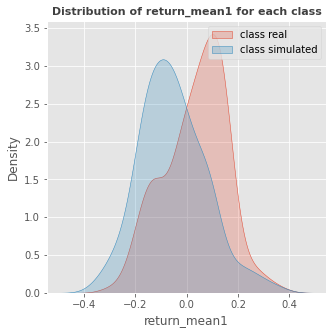

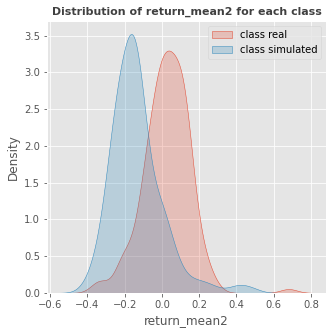

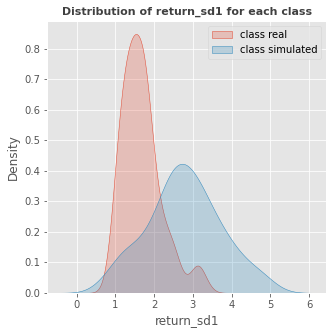

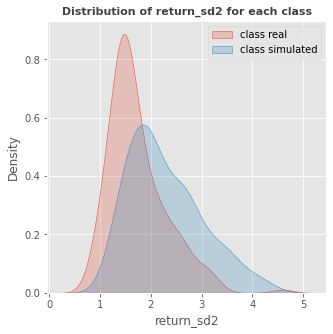

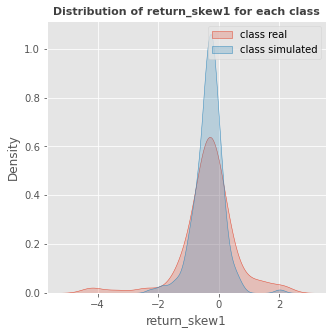

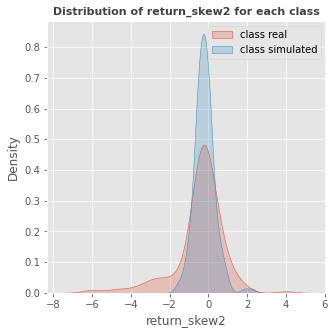

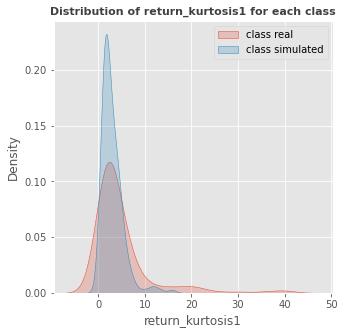

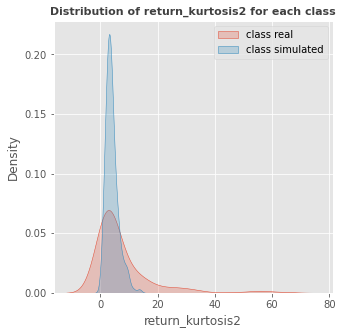

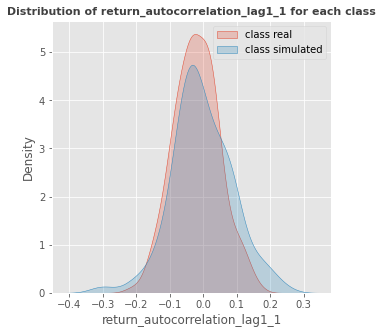

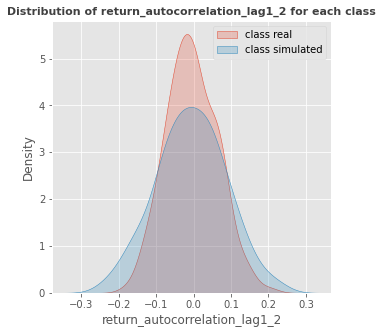

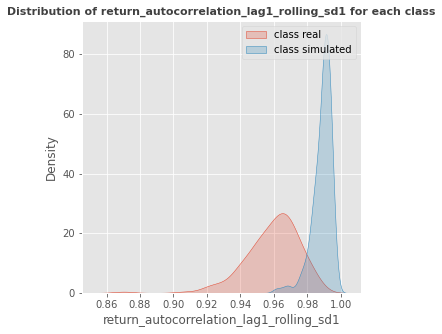

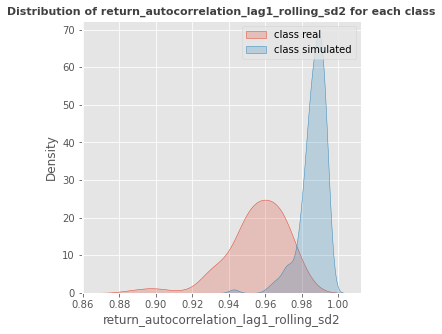

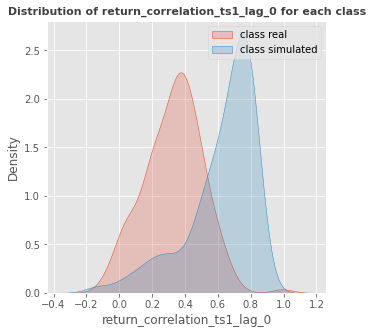

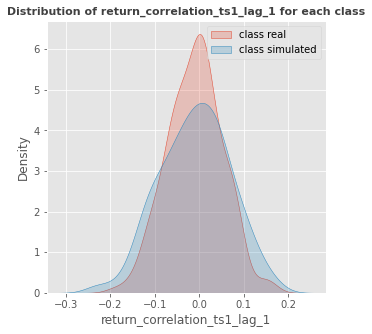

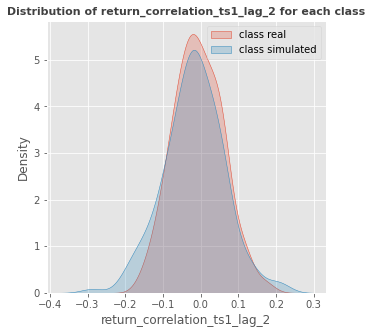

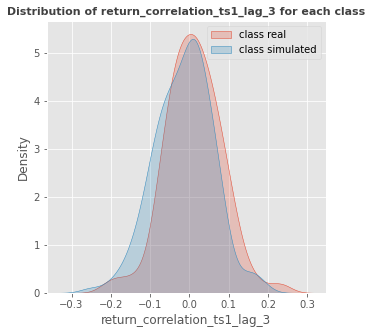

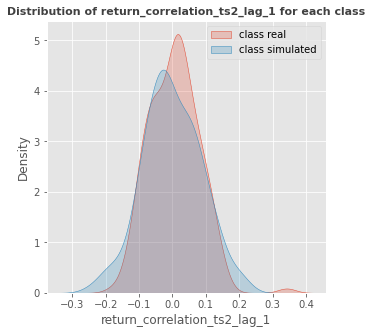

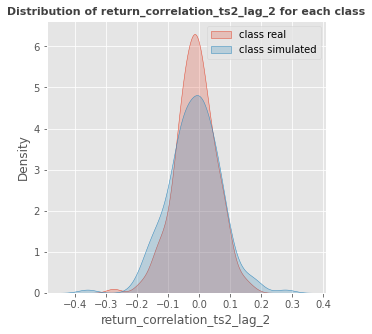

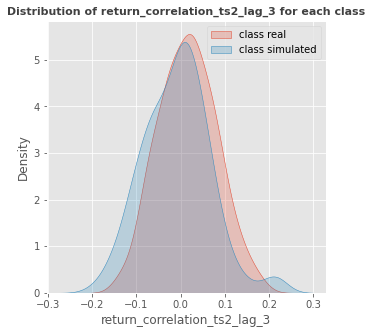

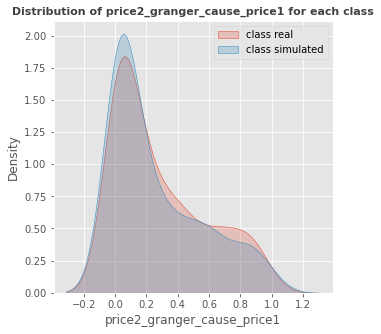

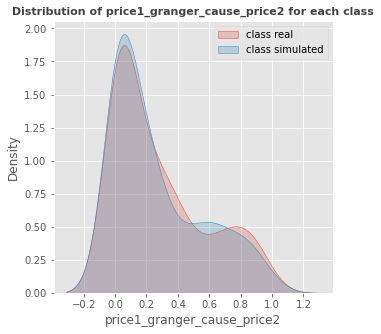

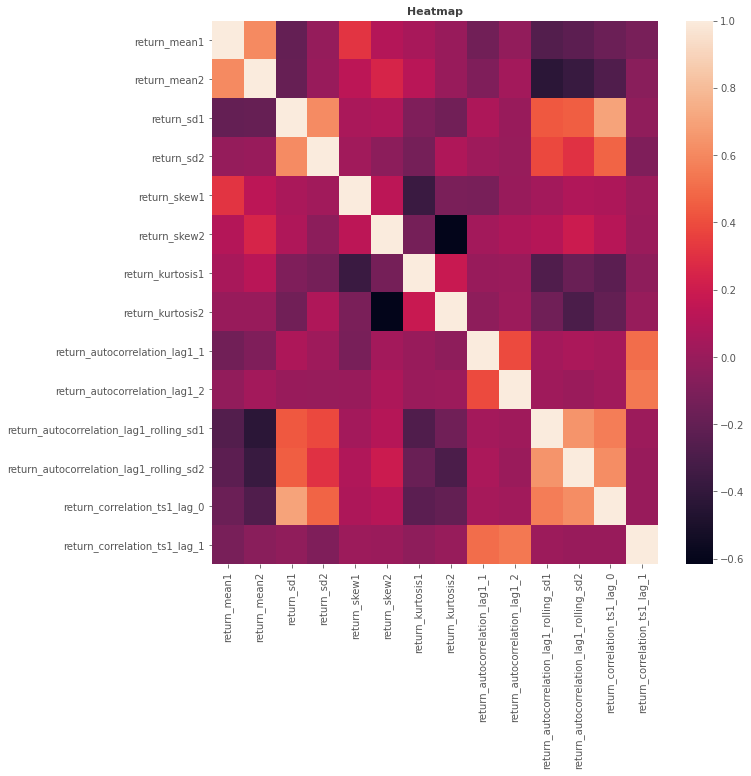

In [6]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_log_prices = n_stvol_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu21=params[1], mu22=params[2], 
    mu31=params[3], mu41=params[4], mu42=params[5],  
    sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
    sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
    sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
    sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
    xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=0, T=1, length=250)
    
    
    n_sim_pair_prices = log_price_to_price(n_log_price=n_sim_log_prices)
    n_sim_pair_returns = price_to_return(n_price=n_sim_pair_prices)
    
    n_sim_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/stvol1998/n_sim_pair_prices.csv")
    n_sim_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/stvol1998/n_sim_pair_returns.csv")

   
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/stvol1998/n_sim_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/stvol1998/n_sim_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/stvol1998/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


In [7]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9530201342281879, 0.9463087248322147, 0.959731543624161, 0.9194630872483222, 0.9731543624161074]
0.9503355704697987
0.017807381424726983
